<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Porsche/Porsche_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "PAH3.DE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-28  38.30  40.42  37.83  39.94      29.25   901567
2009-01-29  39.89  40.00  37.91  38.41      28.13   629475
2009-01-30  38.06  40.95  37.95  39.32      28.80  1467863
2009-02-02  37.01  37.42  35.65  36.11      26.93  1350452
2009-02-03  36.25  36.49  35.10  35.95      26.81  1183009
...           ...    ...    ...    ...        ...      ...
2018-12-19  55.20  55.98  54.92  55.14      53.04   486506
2018-12-20  54.14  54.70  53.30  53.52      51.48   568491
2018-12-21  52.70  54.74  52.22  53.54      51.50  1134954
2018-12-27  53.46  53.68  50.72  51.30      49.35   639096
2018-12-28  51.60  52.14  51.28  51.64      49.67   308952

[2520 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2520.000000  2520.000000  2520.000000  2520.000000  2520.000000  2.520000e+03
mean     53.679849    54.411540    52.849282    53.645980    44.381444  6.314802e+05
std      14.166758    14.140459    14.125244    14.137326    13.199340  4.775679e+05
min      24.920000    25.380000    23.180000    24.650000    18.380000  0.000000e+00
25%      42.900000    43.842500    41.962500    42.845000    33.110000  3.641480e+05
50%      50.900000    51.425000    50.110000    50.910000    43.850000  5.053825e+05
75%      64.445000    65.005000    63.642500    64.362500    54.330000  7.356988e+05
max      93.150000    94.560000    92.820000    94.000000    76.820000  5.944992e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-04-09  38.49  40.32  37.71  40.13      29.93   823372    9          3         99             30             0               0               0                 0      4        2    15        3             1          15  38.150437  34.104230  31.513245  38.672099  36.614852  34.590229      35.185      34.775  32.542087  35.70375  39.481571  36.0480  37.190000  35.70375  38.206667  33.309830               42.094375                 35.70375               29.313125               45.289688                 35.70375               26.117812               48.485001                 35.70375               22.922499               51.680314                 35.70375               19.727186  36.614852  38.654902  33.561149               43.005477                36.614852               30.224226               46.200790                36.614852               27.028913               49.396102                36.614852               23.833601               52.591415                36.614852   
2009-04-14  40.33  42.66  39.07  42.20      31.47  1381309   14          1        104             30             0               0               0                 0      4        2    16        1             4          16  38.352915  34.210447  32.217786  40.421411  37.855996  37.153676      36.570      36.175  33.164320  37.19875  41.446242  37.2125  38.633611  37.19875  41.165000  33.749997               43.369191                 37.19875               31.028309               46.454412                 37.19875               27.943088               49.539632                 37.19875               24.857868               52.624853                 37.19875               21.772647  37.855996  41.222556  34.051988               44.026437                37.855996               31.685555               47.111657                37.855996               28.600334               50.196878                37.855996               25.515113               53.282098                37.855996   
2009-04-15  41.37  42.52  40.48  41.58      3

Open         High          Low       Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2470.000000  2470.000000  2470.000000  2470.00000  2470.000000  2.470000e+03  2470.000000  2470.000000  2470.000000    2470.000000   2470.000000     2470.000000     2470.000000       2470.000000  2470.000000  2470.000000  2470.000000  2470.000000   2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000  2470.000000  2470.000000  2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000   
mean     54.102316    54.822271    53.278227    54.06600    44.783879  6.186176e+05    15.755870     2.003239   186.093117      30.457490      0.031174        0.027935        0.008097          0.007692     6.621053     2.540486    27.064777     2.003239      1.995142    27.064777    54.022355    53.967111    -2.746027    54.070042    54.040733    54.087279    54.013682    53.947518    53.858906    54.042486    54.067690    54.043318    54.051172    54.042486    54.055045    53.979765               56.439326                54.042486               51.645645               57.637746                54.042486               50.447225               58.836167                54.042486               49.248805               60.034587                54.042486               48.050385    54.040733    54.058647    53.989697               56.437574                54.040733               51.643893               57.635994                54.040733               50.445473               58.834414   
std      13.981067    13.971215    13.927470    13.95365    13.016034  4.667658e+05     8.704682     1.407895   103.346105       0.789008      0.173823        0.164821        0.089637          0.087386     3.387808     1.102567    14.783186     1.407895      1.419066    14.783186    13.922545    13.805555    55.804930    13.982336    13.863863    13.853060    13.888688    13.846585    13.987606    13.898027    13.972523    13.913950    13.903992    13.898027    13.951976    13.811784               13.994296                13.898027               13.961861               14.101658                13.898027               14.053348               14.247424                13.898027               14.183636               14.430430                13.898027               14.351668    13.863863    13.934101    13.823864               13.956759                13.863863               13.931471               14.062616                13.863863               14.024953               14.207009   
min      27.710000    28.460000    27.0100

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-04-09  0.164731  0.179425  0.162589  0.192596   0.169795   823372    9          3         99             30             0               0               0                 0      4        2    15        3             1          15  0.147558  0.066983  0.689941  0.161157  0.122458  0.081855    0.103684    0.094892  0.081896  0.111471  0.174040  0.116088  0.133468  0.111471  0.157860  0.063192                0.182641                 0.111471                0.040074                0.214771                 0.111471                0.082078                0.245131                 0.111471                0.148578                0.275275                 0.111471                0.202260  0.122458  0.165196  0.068709                0.196504                 0.122458                0.072348                0.229030                 0.122458                0.114779                0.259854                 0.122458                0.178064                0.291275                 0.122458   
2009-04-14  0.192848  0.214826  0.183255  0.223621   0.197061  1381309   14          1        104             30             0               0               0                 0      4        2    16        1             4          16  0.150804  0.068754  0.693797  0.188111  0.142147  0.123899    0.125442    0.116997  0.091108  0.135088  0.204154  0.134371  0.156181  0.135088  0.202974  0.070380                0.202300                 0.135088                0.067254                0.232342                 0.135088                0.108783                0.260676                 0.135088                0.173955                0.288864                 0.135088                0.226521  0.142147  0.204314  0.076684                0.212545                 0.142147                0.095132                0.243031                 0.142147                0.137346                0.271872                 0.142147                0.199715                0.301372                 0.142147   
2009-04-15  0.208741  0.212708  0.204680  0.214329  

140195

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 48 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_38u2wu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.718741  0.639326              0.327430  0.471579  0.222387
1  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.714851  0.645538              0.361282  0.470848  0.221698
2  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.709323  0.657078              0.332378  0.476672  0.227216
3  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.701611  0.662320              0.330706  0.486022  0.236217
4  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.693284  0.659126              0.368141  0.476548  0.227098
5  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.684821  0.648222              0.349201  0.477339  0.227853
6  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.670079  1.068080              0.369472  0.583656  0.340655
7  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.630289  0.914698              0.440759  0.537241  0.288628
8  DeepLearning_grid_1_AutoML_20190828_162625_mod...  0.616639  3.523699              0.411957  0.650137  0.422678
9              DeepLearning_1_AutoML_20190828_162625  0.571321  2.053773              0.481368  0.681550  0.464510

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.009873
1                  CDLLONGLINE             0.642360           0.642360    0.006342
2           CDLCLOSINGMARUBOZU             0.537420           0.537420    0.005306
3                  CDLBELTHOLD             0.527203           0.527203    0.005205
4                          SUB             0.406754           0.406754    0.004016
...                        ...                  ...                ...         ...
1036   BBANDS_lowerband_12_3_2             0.074770           0.074770    0.000738
1037  BBANDS_middleband_20_2_3             0.074672           0.074672    0.000737
1038   BBANDS_middleband_8_4_4             0.074625           0.074625    0.000737
1039                   DEMA_24             0.074297           0.074297    0.000734
1040            CDL3LINESTRIKE             0.064833           0.064833    0.000640

[1041 rows x 4 columns]

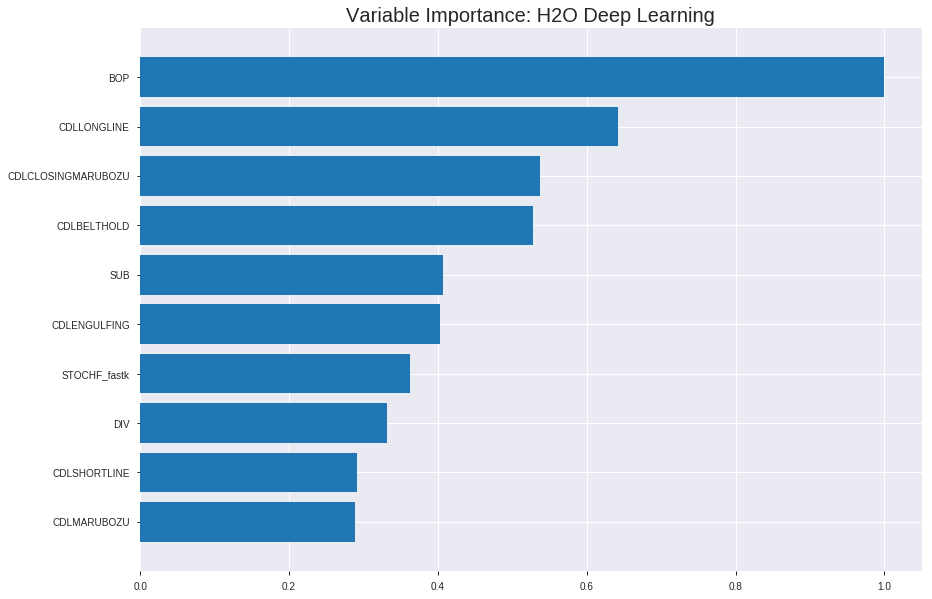

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_162625_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1895277614308243
RMSE: 0.43534786255456026
LogLoss: 0.5573740607898946
Mean Per-Class Error: 0.27612588171459573
AUC: 0.7948560787229624
pr_auc: 0.787318133251296
Gini: 0.5897121574459248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49265470440359427: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      517  338   0.3953   (338.0/855.0)
1      137  736   0.1569   (137.0/873.0)
Total  654  1074  0.2749   (475.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492655     0.756035  219
max f2                       0.224259     0.856689  332
max f0point5                 0.54382      0.727578  180
max accuracy                 0.492655     0.725116  219
max precision                0.985001     1         0
max recall                   0.043508     1         386
max specificity              0.985001     1         0
max absolute_mcc             0.492655     0.461565  219
max min_per_class_accuracy   0.519761     0.717068  197
max mean_per_class_accuracy  0.492655     0.723874  219

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 51.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.941764           1.97938   1.97938            1                0.961564  1                           0.961564            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.920183           1.74651   1.86627            0.882353         0.929934  0.942857                    0.946201            0.0171821       0.0378007                  74.6513   86.6274
    3        0.0300926                   0.896301           1.86295   1.86519            0.941176         0.90912   0.942308                    0.934078            0.0183276       0.0561283                  86.2947   86.5186
    4        0.0405093                   0.885235           1.75945   1.838              0.888889         0.890085  0.928571                    0.922766            0.0183276       0.0744559                  75.945    83.7997
    5        0.0503472                   0.872579           1.63008   1.79737            0.823529         0.878345  0.908046                    0.914086            0.0160367       0.0904926                  63.0079   79.7369
    6        0.100116                    0.8026             1.79525   1.79632            0.906977         0.838381  0.907514                    0.876452            0.0893471       0.17984                    79.5253   79.6317
    7        0.150463                    0.740462           1.5471    1.71293            0.781609         0.770171  0.865385                    0.840889            0.0778923       0.257732                   54.7103   71.2926
    8        0.200231                    0.692043           1.63414   1.69334            0.825581         0.712465  0.855491                    0.808969            0.0813288       0.339061                   63.414    69.3344
    9        0.300347                    0.607351           1.37298   1.58656            0.693642         0.647821  0.801541                    0.755253            0.137457        0.476518                   37.2981   58.6556
    10       0.399884                    0.555122           1.24287   1.50101            0.627907         0.580382  0.758321                    0.711725            0.123711        0.600229                   24.2867   50.1007
    11       0.5                         0.51932            1.15559   1.43184            0.583815         0.53666   0.72338                     0.676671            0.115693        0.715922                   15.5593   43.1844
    12       0.600116                    0.4978             1.04118   1.36667            0.526012         0.5081    0.690453                    0.648549            0.104238        0.82016                    4.11775   36.667
    13       0.699653                    0.456462           0.575402  1.2541             0.290698         0.479372  0.633581                    0.624481            0.0572738       0.877434                   -42.4598  25.4099
    14       0.799769                    0.361306           0.686491  1.18305            0.346821         0.418983  0.597685                    0.598756            0.0687285       0.946163                   -31.3509  18.3046
    15       0.899884                    0.200698           0.411894  1.09725            0.208092         0.290878  0.554341                    0.564504            0.0412371       0.9874                     -58.8106  9.7252
    16       1                           0.000152668        0.125857  1                  0.0635838        0.10353   0.505208                    0.518353           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21134253525602897
RMSE: 0.45972006183766767
LogLoss: 0.6130133426258263
Mean Per-Class Error: 0.330132259919494
AUC: 0.7273309783948081
pr_auc: 0.7260951871771801
Gini: 0.4546619567896162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40828516548292887: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   147  0.6255   (147.0/235.0)
1      21   238  0.0811   (21.0/259.0)
Total  109  385  0.3401   (168.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408285     0.73913   297
max f2                       0.365775     0.851211  317
max f0point5                 0.518435     0.682927  228
max accuracy                 0.481508     0.676113  263
max precision                0.97109      1         0
max recall                   0.0605283    1         394
max specificity              0.97109      1         0
max absolute_mcc             0.476933     0.363151  266
max min_per_class_accuracy   0.552207     0.642553  195
max mean_per_class_accuracy  0.518435     0.669868  228

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101215                   0.941171           1.52587   1.52587            0.8              0.955683  0.8                         0.955683            0.015444        0.015444                   52.5869    52.5869
    2        0.0202429                   0.925135           1.52587   1.52587            0.8              0.932307  0.8                         0.943995            0.015444        0.030888                   52.5869    52.5869
    3        0.0303644                   0.916339           1.52587   1.52587            0.8              0.922458  0.8                         0.936816            0.015444        0.046332                   52.5869    52.5869
    4        0.0404858                   0.909841           1.90734   1.62124            1                0.913191  0.85                        0.93091             0.019305        0.0656371                  90.7336    62.1236
    5        0.0506073                   0.902315           1.90734   1.67846            1                0.906242  0.88                        0.925976            0.019305        0.0849421                  90.7336    67.8456
    6        0.101215                    0.846424           1.67846   1.67846            0.88             0.870975  0.88                        0.898476            0.0849421       0.169884                   67.8456    67.8456
    7        0.149798                    0.805114           1.35103   1.57226            0.708333         0.821923  0.824324                    0.873648            0.0656371       0.235521                   35.103     57.2263
    8        0.200405                    0.769537           1.29699   1.50275            0.68             0.789661  0.787879                    0.852439            0.0656371       0.301158                   29.6988    50.275
    9        0.299595                    0.688907           1.24561   1.41761            0.653061         0.727491  0.743243                    0.811071            0.123552        0.42471                    24.5607    41.7615
    10       0.40081                     0.605586           1.06811   1.32936            0.56             0.651436  0.69697                     0.770759            0.108108        0.532819                   6.81081    32.9355
    11       0.5                         0.555168           1.01206   1.26641            0.530612         0.579647  0.663968                    0.732846            0.100386        0.633205                   1.20558    26.6409
    12       0.59919                     0.517283           1.24561   1.26297            0.653061         0.533582  0.662162                    0.69986             0.123552        0.756757                   24.5607    26.2966
    13       0.700405                    0.475824           0.991815  1.22378            0.52             0.49903   0.641618                    0.670838            0.100386        0.857143                   -0.818533  22.3782
    14       0.799595                    0.390702           0.700654  1.15889            0.367347         0.438329  0.607595                    0.641996            0.0694981       0.926641                   -29.9346   15.8888
    15       0.898785                    0.222923           0.389252  1.07395            0.204082         0.31715   0.563063                    0.606145            0.03861         0.965251                   -61.0748   7.39504
    16       1                           0.0299524          0.34332   1                  0.18             0.122701  0.524291                    0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:50:20  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:50:22  7 min 19.990 sec   169 obs/sec       0.225116  1             389        0.549529         0.872654            -0.20806       0.581581        0.568721           1.20962          0.451968                         0.582665           0.998838              -0.361208        0.582724          0.58506              1.1444             0.439271
    2019-08-28 16:51:10  8 min  7.511 sec   231 obs/sec       6.03009   26            10420      0.497123         0.687402            0.0113674      0.603968        0.57166            1.31959          0.43287                          0.496798           0.686756              0.0104315        0.63746           0.639087             1.52587            0.431174
    2019-08-28 16:51:58  8 min 56.074 sec   243 obs/sec       12.478    54            21562      0.489185         0.671116            0.0426865      0.646707        0.640394           1.75945          0.440394                         0.487822           0.668659              0.0458668        0.650711          0.655386             1.90734            0.433198
    2019-08-28 16:52:47  9 min 45.001 sec   249 obs/sec       19.173    83            33131      0.462329         0.613878            0.144913       0.731509        0.719024           1.64948          0.356481                         0.472887           0.637165              0.103394         0.692122          0.707128             1.90734            0.390688
    2019-08-28 16:53:37  10 min 34.535 sec  253 obs/sec       26.0168   113           44957      0.452118         0.592788            0.182269       0.744009        0.726162           1.75945          0.333333                         0.466986           0.628463              0.125632         0.706194          0.720559             1.90734            0.388664
    2019-08-28 16:54:25  11 min 22.733 sec  255 obs/sec       32.7199   142           56540      0.445657         0.578278            0.205473       0.766735        0.764221           1.86942          0.335069                         0.463543           0.618628              0.138479         0.7098            0.719198             1.90734            0.368421
    2019-08-28 16:55:15  12 min 14.469 sec  258 obs/sec       39.7963   173           68768      0.444267         0.577635            0.210423       0.787816        0.779378           1.97938          0.305556                         0.461281           0.614055              0.146867         0.718746          0.714702             1.1444             0.34413
    2019-08-28 16:56:21  13 min 18.546 sec  261 obs/sec       49.2541   214           85111      0.435348         0.557374            0.241807       0.794856        0.787318           1.97938          0.274884                         0.45972            0.613013              0.15263          0.727331          0.726095             1.52587            0.340081
    2019-08-2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.009872665776901251
CDLLONGLINE               0.6423603296279907     0.6423603296279907   0.00634180884275727
CDLCLOSINGMARUBOZU        0.5374201536178589     0.5374201536178589   0.005305769558440048
CDLBELTHOLD               0.527202844619751      0.527202844619751    0.005204897481562403
SUB                       0.40675443410873413    0.40675443410873413  0.004015750581228134
---                       ---                    ---                  ---
BBANDS_lowerband_12_3_2   0.0747704803943634     0.0747704803943634   0.0007381839629118975
BBANDS_middleband_20_2_3  0.0746719092130661     0.0746719092130661   0.0007372108025837148
BBANDS_middleband_8_4_4   0.07462538033723831    0.07462538033723831  0.0007367514385436921
DEMA_24                   0.07429713010787964    0.07429713010787964  0.0007335107337380428
CDL3LINESTRIKE            0.06483267992734909    0.06483267992734909  0.000640071380343532


See the whole table with table.as_data_frame()


('accuracy', 0.7004048582995951)

('F1', 0.6509803921568628)

('auc', 0.7187414687414687)

('logloss', 0.6393263863565762)

('mean_per_class_error', 0.3153835653835654)

('rmse', 0.47157881203649493)

('mse', 0.2223865759617518)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


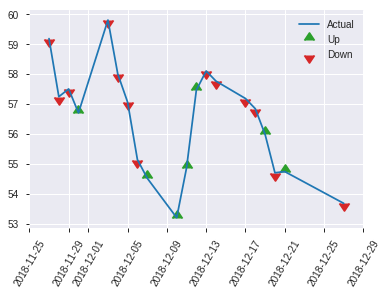


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2223865759617518
RMSE: 0.47157881203649493
LogLoss: 0.6393263863565762
Mean Per-Class Error: 0.3153835653835654
AUC: 0.7187414687414687
pr_auc: 0.6139107267211522
Gini: 0.43748293748293743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4769495392954085: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   73   0.4932   (73.0/148.0)
1      16   83   0.1616   (16.0/99.0)
Total  91   156  0.3603   (89.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47695      0.65098   155
max f2                       0.132561     0.777778  233
max f0point5                 0.621681     0.626822  60
max accuracy                 0.621681     0.700405  60
max precision                0.849531     0.8       9
max recall                   0.0473143    1         242
max specificity              0.920641     0.993243  0
max absolute_mcc             0.563063     0.363978  84
max min_per_class_accuracy   0.514603     0.675676  114
max mean_per_class_accuracy  0.513363     0.684616  119

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.877882           0.83165   0.83165            0.333333         0.905544  0.333333                    0.905544            0.010101        0.010101                   -16.835   -16.835
    2        0.0202429                   0.869737           2.49495   1.49697            1                0.875176  0.6                         0.893397            0.020202        0.030303                   149.495   49.697
    3        0.0323887                   0.85886            2.49495   1.87121            1                0.866127  0.75                        0.883171            0.030303        0.0606061                  149.495   87.1212
    4        0.0404858                   0.842155           2.49495   1.99596            1                0.852166  0.8                         0.87697             0.020202        0.0808081                  149.495   99.596
    5        0.0526316                   0.834728           0.83165   1.72727            0.333333         0.838875  0.692308                    0.868179            0.010101        0.0909091                  -16.835   72.7273
    6        0.101215                    0.74824            2.07912   1.89616            0.833333         0.776153  0.76                        0.824006            0.10101         0.191919                   107.912   89.6162
    7        0.149798                    0.709914           1.6633    1.82064            0.666667         0.72958   0.72973                     0.793382            0.0808081       0.272727                   66.33     82.0639
    8        0.202429                    0.662557           1.53535   1.74646            0.615385         0.689327  0.7                         0.766327            0.0808081       0.353535                   53.5354   74.6465
    9        0.299595                    0.579149           1.45539   1.65206            0.583333         0.615337  0.662162                    0.717357            0.141414        0.494949                   45.5387   65.2061
    10       0.40081                     0.543884           0.99798   1.48689            0.4              0.559508  0.59596                     0.677496            0.10101         0.59596                    -0.20202  48.6889
    11       0.502024                    0.509242           1.19758   1.42856            0.48             0.523473  0.572581                    0.646443            0.121212        0.717172                   19.7576   42.856
    12       0.59919                     0.488693           0.83165   1.33176            0.333333         0.50053   0.533784                    0.622782            0.0808081       0.79798                    -16.835   33.1764
    13       0.700405                    0.435324           0.49899   1.21142            0.2              0.46631   0.485549                    0.60017             0.0505051       0.848485                   -50.101   21.1421
    14       0.797571                    0.345123           0.311869  1.10183            0.125            0.387101  0.441624                    0.574213            0.030303        0.878788                   -68.8131  10.183
    15       0.898785                    0.215005           0.598788  1.04518            0.24             0.278268  0.418919                    0.540885            0.0606061       0.939394                   -40.1212  4.51815
    16       1                           0.00448411         0.598788  1                  0.24             0.120566  0.40081                     0.498343            0

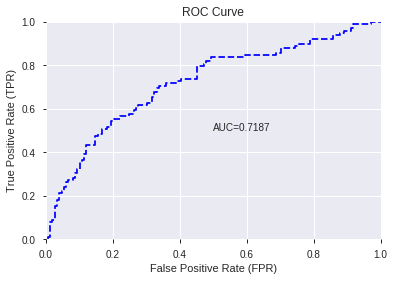

This function is available for GLM models only


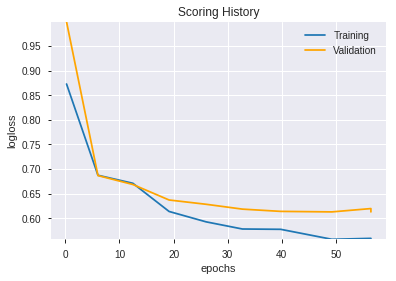

--2019-08-28 16:57:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_162625_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_162625_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_165733_model_9  0.728023  0.612566              0.352853  0.459229  0.210891
1  DeepLearning_grid_1_AutoML_20190828_165733_model_8  0.712804  0.687589              0.329034  0.475228  0.225842
2  DeepLearning_grid_1_AutoML_20190828_165733_model_7  0.711848  0.648077              0.346062  0.462137  0.213570
3  DeepLearning_grid_1_AutoML_20190828_165733_model_6  0.705569  0.633685              0.334118  0.464726  0.215970
4  DeepLearning_grid_1_AutoML_20190828_165733_model_5  0.693352  0.659121              0.330740  0.471153  0.221985
5  DeepLearning_grid_1_AutoML_20190828_165733_model_2  0.683047  0.768605              0.410354  0.491930  0.241995
6  DeepLearning_grid_1_AutoML_20190828_165733_model_3  0.663732  0.735665              0.384930  0.490048  0.240147
7  DeepLearning_grid_1_AutoML_20190828_165733_model_4  0.662640  0.799253              0.359371  0.507261  0.257313
8               DeepLearning_1_AutoML_20190828_165733  0.660183  0.730222              0.350805  0.499535  0.249535
9  DeepLearning_grid_1_AutoML_20190828_165733_model_1  0.650491  0.962117              0.381416  0.519360  0.269735

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.041937
1   CDLCLOSINGMARUBOZU             0.743632           0.743632    0.031186
2          CDLLONGLINE             0.689380           0.689380    0.028911
3                  DIV             0.586359           0.586359    0.024590
4         CDLENGULFING             0.577187           0.577187    0.024206
5          CDLBELTHOLD             0.570635           0.570635    0.023931
6         STOCHF_fastk             0.563433           0.563433    0.023629
7             CORREL_8             0.529884           0.529884    0.022222
8                  SUB             0.506332           0.506332    0.021234
9        CDLHANGINGMAN             0.505573           0.505573    0.021202
10         HT_DCPERIOD             0.493547           0.493547    0.020698
11        CDLSHORTLINE             0.490027           0.490027    0.020550
12                DX_8             0.478567           0.478567    0.020070
13             WILLR_8             0.472830           0.472830    0.019829
14              SAREXT             0.467641           0.467641    0.019612
15              TRANGE             0.466102           0.466102    0.019547
16                 OBV             0.465243           0.465243    0.019511
17        HT_TRENDMODE             0.461583           0.461583    0.019358
18        aroondown_12             0.460549           0.460549    0.019314
19                 day             0.460412           0.460412    0.019308
20      STOCHRSI_fastd             0.459724           0.459724    0.019280
21    CDLDRAGONFLYDOJI             0.455388           0.455388    0.019098
22            WILLR_12             0.453442           0.453442    0.019016
23                 SIN             0.453313           0.453313    0.019011
24                 COS             0.450985           0.450985    0.018913
25        CDLTHRUSTING             0.450122           0.450122    0.018877
26      STOCHRSI_fastk             0.447574           0.447574    0.018770
27           CDLHAMMER             0.443787           0.443787    0.018611
28         CDLMARUBOZU             0.442180           0.442180    0.018544
29   LINEARREG_ANGLE_8             0.440445           0.440445    0.018471
30             BETA_24             0.439551           0.439551    0.018434
31            WILLR_20             0.434732           0.434732    0.018232
32   CDLINVERTEDHAMMER             0.432982           0.432982    0.018158
33         STOCH_slowd             0.428835           0.428835    0.017984
34   LINEARREG_SLOPE_8             0.428614           0.428614    0.017975
35        aroondown_14             0.428547           0.428547    0.017972
36               CMO_8             0.426075           0.426075    0.017868
37        weekday_name             0.426039           0.426039    0.017867
38         STOCH_slowk             0.418412           0.418412    0.017547
39        STOCHF_fastd             0.417843           0.417843    0.017523
40             BETA_12             0.417265           0.417265    0.017499
41              ULTOSC             0.416513           0.416513    0.017467
42   CDLDARKCLOUDCOVER             0.413328           0.413328    0.017334
43            WILLR_14             0.411992           0.411992    0.017278
44           CORREL_30             0.409755           0.409755    0.017184
45             BETA_30             0.407021           0.407021    0.017069
46             BETA_20             0.403728           0.403728    0.016931
47         CDL3OUTSIDE             0.401606           0.401606    0.016842
48               RSI_8             0.400618           0.400618    0.016801
49               ADOSC             0.395746           0.395746    0.016597

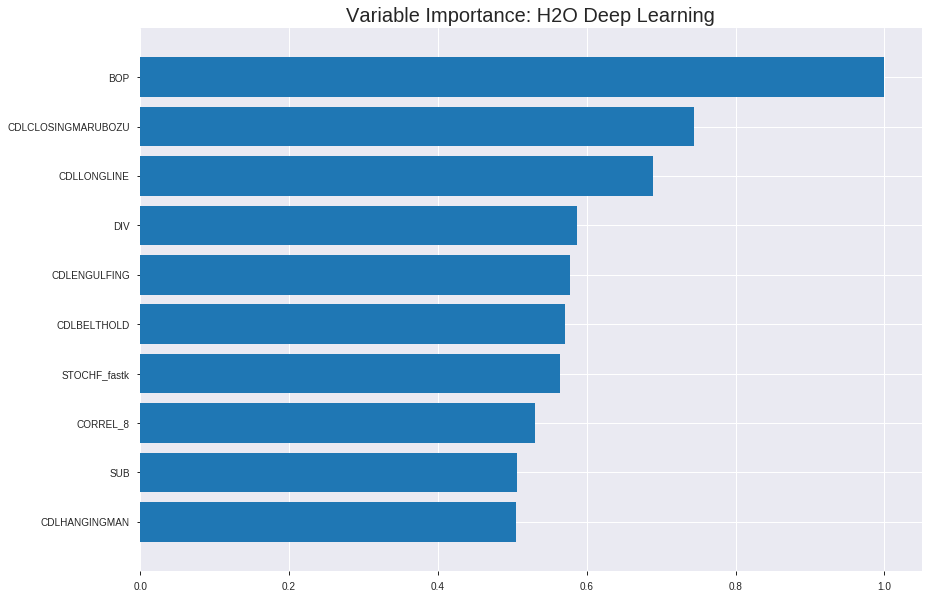

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_165733_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19527219086236322
RMSE: 0.44189613130504235
LogLoss: 0.5719459678140053
Mean Per-Class Error: 0.2925845541689275
AUC: 0.7765291426351293
pr_auc: 0.7664815225377121
Gini: 0.5530582852702586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43659950500316497: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      462  393   0.4596   (393.0/855.0)
1      132  741   0.1512   (132.0/873.0)
Total  594  1134  0.3038   (525.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4366       0.738416  227
max f2                       0.201398     0.857143  334
max f0point5                 0.479026     0.706938  194
max accuracy                 0.479026     0.707755  194
max precision                0.844437     1         0
max recall                   0.131975     1         365
max specificity              0.844437     1         0
max absolute_mcc             0.479026     0.415812  194
max min_per_class_accuracy   0.489463     0.696449  186
max mean_per_class_accuracy  0.479026     0.707415  194

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.820736           1.86942   1.86942            0.944444         0.827986  0.944444                    0.827986            0.0194731       0.0194731                  86.9416   86.9416
    2        0.0202546                   0.810351           1.86295   1.86627            0.941176         0.816574  0.942857                    0.822443            0.0183276       0.0378007                  86.2947   86.6274
    3        0.0300926                   0.796031           1.74651   1.82712            0.882353         0.805331  0.923077                    0.816849            0.0171821       0.0549828                  74.6513   82.7121
    4        0.0405093                   0.783341           1.86942   1.838              0.944444         0.789297  0.928571                    0.809764            0.0194731       0.0744559                  86.9416   83.7997
    5        0.0503472                   0.773012           1.51364   1.77462            0.764706         0.777488  0.896552                    0.803457            0.0148912       0.0893471                  51.3645   77.4618
    6        0.100116                    0.725973           1.7262    1.75055            0.872093         0.74804   0.884393                    0.775909            0.0859107       0.175258                   72.6205   75.0551
    7        0.150463                    0.688734           1.47885   1.65964            0.747126         0.710175  0.838462                    0.753913            0.0744559       0.249714                   47.8848   65.9635
    8        0.200231                    0.653505           1.56509   1.63614            0.790698         0.669768  0.82659                     0.732999            0.0778923       0.327606                   56.5092   63.6136
    9        0.300347                    0.585659           1.41875   1.56367            0.716763         0.620074  0.789981                    0.695357            0.142039        0.469645                   41.8747   56.3673
    10       0.399884                    0.523508           1.1508    1.4609             0.581395         0.552486  0.738061                    0.659794            0.114548        0.584192                   15.0803   46.0904
    11       0.5                         0.489465           1.10983   1.39061            0.560694         0.505165  0.702546                    0.628833            0.111111        0.695304                   10.9827   39.0607
    12       0.600116                    0.458906           1.02974   1.3304             0.520231         0.473357  0.672131                    0.602895            0.103093        0.798396                   2.9736    33.0404
    13       0.699653                    0.406269           0.75953   1.24919            0.383721         0.436847  0.6311                      0.579272            0.0756014       0.873998                   -24.047   24.9188
    14       0.799769                    0.292853           0.640725  1.17302            0.323699         0.356925  0.592619                    0.551438            0.0641466       0.938144                   -35.9275  17.302
    15       0.899884                    0.172032           0.491985  1.09725            0.248555         0.231968  0.554341                    0.515896            0.0492554       0.9874                     -50.8015  9.7252
    16       1                           0.0113299          0.125857  1                  0.0635838        0.119024  0.505208                    0.476163           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20843561747871905
RMSE: 0.45654749750570206
LogLoss: 0.6030520774551017
Mean Per-Class Error: 0.33161915715107204
AUC: 0.732366713217777
pr_auc: 0.7459127013565735
Gini: 0.46473342643555404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40965053292313236: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   154  0.6553   (154.0/235.0)
1      24   235  0.0927   (24.0/259.0)
Total  105  389  0.3603   (178.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409651     0.725309  301
max f2                       0.246034     0.855795  356
max f0point5                 0.588306     0.696489  128
max accuracy                 0.503019     0.665992  199
max precision                0.83291      1         0
max recall                   0.0964708    1         392
max specificity              0.83291      1         0
max absolute_mcc             0.595861     0.361042  121
max min_per_class_accuracy   0.5017       0.656371  201
max mean_per_class_accuracy  0.581198     0.668381  134

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 50.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.810601           1.90734   1.90734            1                0.826542  1                           0.826542            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.788022           1.52587   1.7166             0.8              0.804224  0.9                         0.815383            0.015444        0.034749                   52.5869   71.6602
    3        0.0303644                   0.778764           1.90734   1.78018            1                0.78327   0.933333                    0.804679            0.019305        0.0540541                  90.7336   78.018
    4        0.0404858                   0.773987           1.90734   1.81197            1                0.776585  0.95                        0.797655            0.019305        0.0733591                  90.7336   81.1969
    5        0.0506073                   0.770226           1.90734   1.83104            1                0.77254   0.96                        0.792632            0.019305        0.0926641                  90.7336   83.1042
    6        0.101215                    0.732159           1.60216   1.7166             0.84             0.751048  0.9                         0.77184             0.0810811       0.173745                   60.2162   71.6602
    7        0.149798                    0.705326           1.27156   1.57226            0.666667         0.717814  0.824324                    0.754318            0.0617761       0.235521                   27.1557   57.2263
    8        0.200405                    0.667782           1.60216   1.57981            0.84             0.68627   0.828283                    0.737134            0.0810811       0.316602                   60.2162   57.9814
    9        0.299595                    0.596147           1.40131   1.52071            0.734694         0.634194  0.797297                    0.703053            0.138996        0.455598                   40.1308   52.0714
    10       0.40081                     0.544051           0.915521  1.36789            0.48             0.57108   0.717172                    0.669726            0.0926641       0.548263                   -8.44788  36.7887
    11       0.5                         0.500994           1.08991   1.31274            0.571429         0.523779  0.688259                    0.640773            0.108108        0.656371                   8.99062   31.2741
    12       0.59919                     0.47591            0.778504  1.2243             0.408163         0.488906  0.641892                    0.615633            0.0772201       0.733591                   -22.1496  22.4303
    13       0.700405                    0.451518           1.02996   1.19622            0.54             0.463354  0.627168                    0.593627            0.104247        0.837838                   2.99614   19.6219
    14       0.799595                    0.398615           0.739579  1.13957            0.387755         0.430292  0.597468                    0.573366            0.0733591       0.911197                   -26.0421  13.9573
    15       0.898785                    0.250535           0.622804  1.08254            0.326531         0.328077  0.567568                    0.546295            0.0617761       0.972973                   -37.7196  8.2542
    16       1                           0.0494607          0.267027  1                  0.14             0.154683  0.524291                    0.506659           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:04:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:04:10  2 min 21.409 sec  521 obs/sec       0.636574  1             1100       0.539862         0.957351            -0.165929      0.756773        0.747444           1.86942          0.350116                         0.534203           0.929715              -0.144191        0.725417          0.738957             1.90734            0.352227
    2019-08-28 17:04:20  2 min 31.519 sec  788 obs/sec       5.12384   8             8854       0.446609         0.583885            0.202074       0.771091        0.764032           1.86942          0.300926                         0.461566           0.613923              0.145811         0.724875          0.733569             1.90734            0.336032
    2019-08-28 17:04:31  2 min 42.209 sec  954 obs/sec       11.5718   18            19996      0.441896         0.571946            0.218826       0.776529        0.766482           1.86942          0.303819                         0.456547           0.603052              0.164285         0.732367          0.745913             1.90734            0.360324
    2019-08-28 17:04:41  2 min 52.431 sec  1068 obs/sec      18.6545   29            32235      0.439271         0.566338            0.22808        0.781918        0.771941           1.86942          0.302083                         0.457464           0.60377               0.160927         0.732589          0.746924             1.90734            0.356275
    2019-08-28 17:04:52  3 min  3.104 sec  1171 obs/sec      27.037    42            46720      0.434839         0.555958            0.243578       0.786027        0.77622            1.86942          0.29456                          0.456632           0.603571              0.163974         0.730362          0.745372             1.90734            0.352227
    2019-08-28 17:05:02  3 min 13.232 sec  1246 obs/sec      35.3791   55            61135      0.431914         0.55102             0.253721       0.791995        0.780127           1.97938          0.291088                         0.458304           0.60562               0.157843         0.729105          0.746894             1.90734            0.374494
    2019-08-28 17:05:12  3 min 23.511 sec  1315 obs/sec      44.4097   69            76740      0.427311         0.540631            0.269543       0.7984          0.785442           1.86942          0.284722                         0.458627           0.605541              0.156656         0.731644          0.752665             1.90734            0.354251
    2019-08-28 17:05:13  3 min 24.517 sec  1314 obs/sec      44.4097   69            76740      0.441896         0.571946            0.218826       0.776529        0.766482           1.86942          0.303819                         0.456547           0.603052              0.164285         0.732367          0.745913             1.90734            0.360324

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.041937375833176534
CDLCLOSINGMARUBOZU  0.7436323761940002     0.7436323761940002   0.031185990442165905
CDLLONGLINE         0.6893795132637024     0.6893795132637024   0.028910767739432193
DIV                 0.586359441280365      0.586359441280365    0.024590376262306073
CDLENGULFING        0.5771865248680115     0.5771865248680115   0.02420568821923489
---                 ---                    ---                  ---
BETA_30             0.407020628452301      0.407020628452301    0.017069377067259854
BETA_20             0.4037284553050995     0.4037284553050995   0.01693131196467777
CDL3OUTSIDE         0.40160563588142395    0.40160563588142395  0.01684228648868112
RSI_8               0.4006183445453644     0.4006183445453644   0.016800882080863954
ADOSC               0.39574623107910156    0.39574623107910156  0.01659655842732741


See the whole table with table.as_data_frame()


('accuracy', 0.728744939271255)

('F1', 0.64)

('auc', 0.7280234780234781)

('logloss', 0.6125655029225197)

('mean_per_class_error', 0.2965806715806716)

('rmse', 0.45922883066666464)

('mse', 0.21089111891547216)

deeplearning prediction progress: |███████████████████████████████████████| 100%


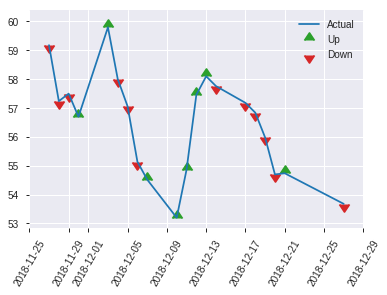


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21089111891547216
RMSE: 0.45922883066666464
LogLoss: 0.6125655029225197
Mean Per-Class Error: 0.2965806715806716
AUC: 0.7280234780234781
pr_auc: 0.620035771008875
Gini: 0.4560469560469562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3675590165715577: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   88   0.5946   (88.0/148.0)
1      11   88   0.1111   (11.0/99.0)
Total  71   176  0.4008   (99.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367559     0.64      175
max f2                       0.158345     0.776     228
max f0point5                 0.511772     0.6691    77
max accuracy                 0.511772     0.728745  77
max precision                0.815048     1         0
max recall                   0.0862202    1         243
max specificity              0.815048     1         0
max absolute_mcc             0.511261     0.423372  81
max min_per_class_accuracy   0.474416     0.668919  115
max mean_per_class_accuracy  0.511261     0.703419  81

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 44.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.799963           1.6633    1.6633             0.666667         0.8104    0.666667                    0.8104              0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.763364           1.24747   1.49697            0.5              0.783824  0.6                         0.79977             0.010101        0.030303                   24.7475   49.697
    3        0.0323887                   0.747061           1.6633    1.55934            0.666667         0.759075  0.625                       0.784509            0.020202        0.0505051                  66.33     55.9343
    4        0.0404858                   0.728902           2.49495   1.74646            1                0.732997  0.7                         0.774207            0.020202        0.0707071                  149.495   74.6465
    5        0.0526316                   0.723733           2.49495   1.91919            1                0.72633   0.769231                    0.763158            0.030303        0.10101                    149.495   91.9192
    6        0.101215                    0.670176           1.6633    1.79636            0.666667         0.698271  0.72                        0.732012            0.0808081       0.181818                   66.33     79.6364
    7        0.149798                    0.609              1.6633    1.75321            0.666667         0.641823  0.702703                    0.702762            0.0808081       0.262626                   66.33     75.3208
    8        0.202429                    0.569117           1.72727   1.74646            0.692308         0.587916  0.7                         0.672902            0.0909091       0.353535                   72.7273   74.6465
    9        0.299595                    0.516207           1.76726   1.75321            0.708333         0.542805  0.702703                    0.630708            0.171717        0.525253                   76.7256   75.3208
    10       0.40081                     0.487943           0.898182  1.53729            0.36             0.504057  0.616162                    0.598726            0.0909091       0.616162                   -10.1818  53.7292
    11       0.502024                    0.463076           0.798384  1.38832            0.32             0.476755  0.556452                    0.574135            0.0808081       0.69697                    -20.1616  38.8319
    12       0.59919                     0.437283           0.623737  1.26433            0.25             0.450993  0.506757                    0.554166            0.0606061       0.757576                   -37.6263  26.4333
    13       0.700405                    0.37937            1.09778   1.24026            0.44             0.41179   0.49711                     0.533591            0.111111        0.868687                   9.77778   24.0264
    14       0.797571                    0.300522           0.311869  1.12716            0.125            0.334254  0.451777                    0.509307            0.030303        0.89899                    -68.8131  12.716
    15       0.898785                    0.187913           0.399192  1.04518            0.16             0.251814  0.418919                    0.48031             0.040404        0.939394                   -60.0808  4.51815
    16       1                           0.0467606          0.598788  1                  0.24             0.134061  0.40081                     0.445264            0

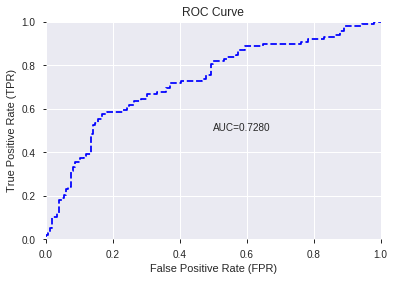

This function is available for GLM models only


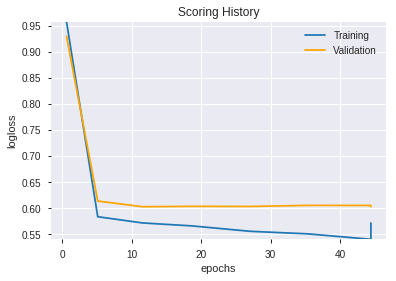

--2019-08-28 17:05:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_165733_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_165733_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'DIV',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CORREL_8',
 'SUB',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'CDLSHORTLINE',
 'DX_8',
 'WILLR_8',
 'SAREXT',
 'TRANGE',
 'OBV',
 'HT_TRENDMODE',
 'aroondown_12',
 'day',
 'STOCHRSI_fastd',
 'CDLDRAGONFLYDOJI',
 'WILLR_12',
 'SIN',
 'COS',
 'CDLTHRUSTING',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CDLMARUBOZU',
 'LINEARREG_ANGLE_8',
 'BETA_24',
 'WILLR_20',
 'CDLINVERTEDHAMMER',
 'STOCH_slowd',
 'LINEARREG_SLOPE_8',
 'aroondown_14',
 'CMO_8',
 'weekday_name',
 'STOCH_slowk',
 'STOCHF_fastd',
 'BETA_12',
 'ULTOSC',
 'CDLDARKCLOUDCOVER',
 'WILLR_14',
 'CORREL_30',
 'BETA_30',
 'BETA_20',
 'CDL3OUTSIDE',
 'RSI_8',
 'ADOSC']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_170527_model_1  0.713896  0.622686              0.325689  0.464015  0.21531

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.489964           1.000000    0.116992
1                  SUB             0.269058           0.549138    0.064245
2         STOCHF_fastk             0.251026           0.512335    0.059939
3              WILLR_8             0.216935           0.442758    0.051799
4          HT_DCPERIOD             0.153145           0.312563    0.036567
5       STOCHRSI_fastd             0.151131           0.308453    0.036086
6         CDLENGULFING             0.146935           0.299890    0.035085
7             WILLR_12             0.138004           0.281662    0.032952
8    LINEARREG_ANGLE_8             0.117968           0.240768    0.028168
9          STOCH_slowk             0.110764           0.226065    0.026448
10        STOCHF_fastd             0.109328           0.223134    0.026105
11           CDLHAMMER             0.108814           0.222085    0.025982
12         CDLLONGLINE             0.104998           0.214298    0.025071
13        aroondown_12             0.104713           0.213715    0.025003
14                 OBV             0.102489           0.209177    0.024472
15   CDLINVERTEDHAMMER             0.101782           0.207733    0.024303
16                DX_8             0.096831           0.197628    0.023121
17        aroondown_14             0.093449           0.190726    0.022313
18               ADOSC             0.092934           0.189675    0.022190
19   LINEARREG_SLOPE_8             0.089269           0.182195    0.021315
20                 DIV             0.081252           0.165833    0.019401
21             BETA_24             0.078051           0.159300    0.018637
22         CDLMARUBOZU             0.077191           0.157545    0.018431
23              ULTOSC             0.074148           0.151334    0.017705
24  CDLCLOSINGMARUBOZU             0.071767           0.146474    0.017136
25           CORREL_30             0.066443           0.135608    0.015865
26         STOCH_slowd             0.063082           0.128747    0.015062
27       CDLHANGINGMAN             0.061008           0.124515    0.014567
28                 COS             0.059632           0.121708    0.014239
29              SAREXT             0.053922           0.110053    0.012875
30            WILLR_14             0.052087           0.106307    0.012437
31              TRANGE             0.048917           0.099838    0.011680
32      STOCHRSI_fastk             0.048844           0.099690    0.011663
33        CDLTHRUSTING             0.047281           0.096499    0.011290
34             BETA_20             0.035221           0.071885    0.008410
35        weekday_name             0.033242           0.067847    0.007938
36        HT_TRENDMODE             0.031116           0.063507    0.007430
37    CDLDRAGONFLYDOJI             0.022879           0.046694    0.005463
38   CDLDARKCLOUDCOVER             0.018321           0.037393    0.004375
39         CDL3OUTSIDE             0.014350           0.029288    0.003426
40               RSI_8             0.013738           0.028038    0.003280
41               CMO_8             0.013365           0.027278    0.003191
42         CDLBELTHOLD             0.012649           0.025816    0.003020
43             BETA_30             0.011390           0.023247    0.002720
44            WILLR_20             0.010196           0.020810    0.002435
45            CORREL_8             0.009751           0.019901    0.002328
46             BETA_12             0.009656           0.019707    0.002306
47        CDLSHORTLINE             0.008433           0.017212    0.002014
48                 SIN             0.006633           0.013537    0.001584
49                 day             0.003919           0.007998    0.000936

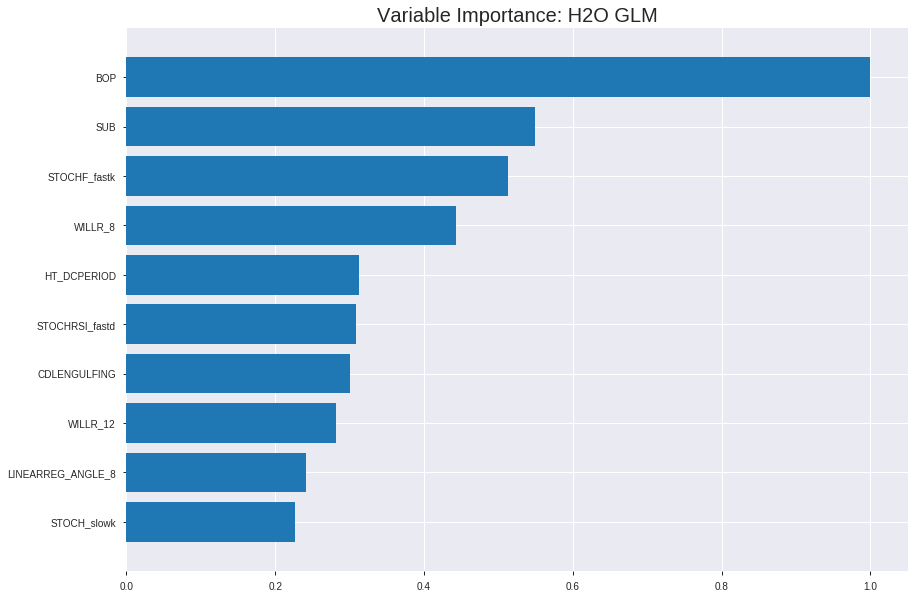

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170527_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19137039971386832
RMSE: 0.4374590263257444
LogLoss: 0.5633902973798087
Null degrees of freedom: 1727
Residual degrees of freedom: 1677
Null deviance: 2395.329152624184
Residual deviance: 1947.0768677446188
AIC: 2049.0768677446185
AUC: 0.7794832633320606
pr_auc: 0.767975988758032
Gini: 0.5589665266641213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3677819637083653: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      420  435   0.5088   (435.0/855.0)
1      100  773   0.1145   (100.0/873.0)
Total  520  1208  0.3096   (535.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367782     0.742912  262
max f2                       0.242944     0.854103  319
max f0point5                 0.520785     0.717406  190
max accuracy                 0.518061     0.714699  191
max precision                0.970031     1         0
max recall                   0.0648796    1         390
max specificity              0.970031     1         0
max absolute_mcc             0.518061     0.429318  191
max min_per_class_accuracy   0.520785     0.71345   190
max mean_per_class_accuracy  0.518061     0.71465   191

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.920977           1.86942   1.86942            0.944444         0.940941  0.944444                    0.940941            0.0194731       0.0194731                  86.9416   86.9416
    2        0.0202546                   0.888949           1.86295   1.86627            0.941176         0.904167  0.942857                    0.92308             0.0183276       0.0378007                  86.2947   86.6274
    3        0.0300926                   0.875231           1.63008   1.78906            0.823529         0.881171  0.903846                    0.909379            0.0160367       0.0538373                  63.0079   78.9056
    4        0.0405093                   0.863735           1.75945   1.78144            0.888889         0.869613  0.9                         0.899153            0.0183276       0.0721649                  75.945    78.1443
    5        0.0503472                   0.845678           1.97938   1.82012            1                0.855029  0.91954                     0.890531            0.0194731       0.091638                   97.9381   82.0121
    6        0.100116                    0.794562           1.56509   1.69334            0.790698         0.819011  0.855491                    0.854978            0.0778923       0.16953                    56.5092   69.3344
    7        0.150463                    0.756602           1.72911   1.70531            0.873563         0.775128  0.861538                    0.828259            0.0870561       0.256586                   72.9115   70.5313
    8        0.200231                    0.728072           1.47303   1.64758            0.744186         0.741612  0.83237                     0.806722            0.0733104       0.329897                   47.3028   64.7578
    9        0.300347                    0.659436           1.3501    1.54842            0.682081         0.693893  0.782274                    0.769113            0.135166        0.465063                   35.0098   54.8418
    10       0.399884                    0.582728           1.20834   1.46377            0.610465         0.621597  0.739508                    0.732394            0.120275        0.585338                   20.8343   46.3768
    11       0.5                         0.521997           1.25857   1.42268            0.635838         0.550995  0.71875                     0.696072            0.126002        0.71134                    25.8566   42.268
    12       0.600116                    0.449066           0.880996  1.33231            0.445087         0.486195  0.673095                    0.661059            0.0882016       0.799542                   -11.9004  33.2313
    13       0.699653                    0.366415           0.863102  1.26556            0.436047         0.408142  0.639371                    0.625077            0.0859107       0.885452                   -13.6898  26.556
    14       0.799769                    0.274684           0.491985  1.16872            0.248555         0.320723  0.590449                    0.586978            0.0492554       0.934708                   -50.8015  16.8723
    15       0.899884                    0.187061           0.491985  1.09343            0.248555         0.230909  0.552412                    0.547364            0.0492554       0.983963                   -50.8015  9.34332
    16       1                           0.00613412         0.160181  1                  0.0809249        0.126296  0.505208                    0.505208           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20830529395496944
RMSE: 0.45640474795401664
LogLoss: 0.6016731358573415
Null degrees of freedom: 493
Residual degrees of freedom: 443
Null deviance: 684.3830016464425
Residual deviance: 594.4530582270534
AIC: 696.4530582270534
AUC: 0.7330239053643308
pr_auc: 0.7380980685368195
Gini: 0.46604781072866164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3421541038922908: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   154  0.6553   (154.0/235.0)
1      18   241  0.0695   (18.0/259.0)
Total  99   395  0.3482   (172.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342154     0.737003  310
max f2                       0.253142     0.858792  346
max f0point5                 0.621912     0.68903   165
max accuracy                 0.459398     0.665992  259
max precision                0.963377     1         0
max recall                   0.102175     1         392
max specificity              0.963377     1         0
max absolute_mcc             0.342154     0.343312  310
max min_per_class_accuracy   0.568939     0.65251   192
max mean_per_class_accuracy  0.621912     0.667904  165

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.907611           1.90734   1.90734            1                0.933242  1                           0.933242            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.893976           1.52587   1.7166             0.8              0.90365   0.9                         0.918446            0.015444        0.034749                   52.5869   71.6602
    3        0.0303644                   0.882189           1.90734   1.78018            1                0.889926  0.933333                    0.90894             0.019305        0.0540541                  90.7336   78.018
    4        0.0404858                   0.872815           1.52587   1.7166             0.8              0.878252  0.9                         0.901268            0.015444        0.0694981                  52.5869   71.6602
    5        0.0506073                   0.862545           1.52587   1.67846            0.8              0.868757  0.88                        0.894766            0.015444        0.0849421                  52.5869   67.8456
    6        0.101215                    0.824797           1.52587   1.60216            0.8              0.844773  0.84                        0.869769            0.0772201       0.162162                   52.5869   60.2162
    7        0.149798                    0.792648           1.50997   1.57226            0.791667         0.809271  0.824324                    0.850148            0.0733591       0.235521                   50.9974   57.2263
    8        0.200405                    0.763947           1.60216   1.57981            0.84             0.77725   0.828283                    0.831739            0.0810811       0.316602                   60.2162   57.9814
    9        0.299595                    0.699126           1.16776   1.44339            0.612245         0.730067  0.756757                    0.798078            0.11583         0.432432                   16.7757   44.3389
    10       0.40081                     0.63705            1.18255   1.37752            0.62             0.671205  0.722222                    0.766039            0.119691        0.552124                   18.2548   37.752
    11       0.5                         0.568545           1.01206   1.30502            0.530612         0.605475  0.684211                    0.734186            0.100386        0.65251                    1.20558   30.5019
    12       0.59919                     0.50748            0.856355  1.23075            0.44898          0.535912  0.64527                     0.701364            0.0849421       0.737452                   -14.3645  23.0747
    13       0.700405                    0.434375           1.06811   1.20724            0.56             0.474443  0.632948                    0.668572            0.108108        0.84556                    6.81081   20.7244
    14       0.799595                    0.340805           0.856355  1.16372            0.44898          0.388061  0.610127                    0.633774            0.0849421       0.930502                   -14.3645  16.3716
    15       0.898785                    0.228553           0.467103  1.08684            0.244898         0.290064  0.56982                     0.595842            0.046332        0.976834                   -53.2897  8.68378
    16       1                           0.0471793          0.22888   1                  0.12             0.159426  0.524291                    0.551671           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:05:27  0.000 sec   2            21        51            1.36655           1.36876
    2019-08-28 17:05:27  0.019 sec   4            13        51            1.35666           1.36044
    2019-08-28 17:05:27  0.032 sec   6            8.1       51            1.34307           1.34909
    2019-08-28 17:05:27  0.046 sec   8            5         51            1.32529           1.33439
    2019-08-28 17:05:27  0.059 sec   10           3.1       51            1.30333           1.31646
    2019-08-28 17:05:27  0.072 sec   12           1.9       51            1.27783           1.29602
    2019-08-28 17:05:27  0.088 sec   14           1.2       51            1.25029           1.27454
    2019-08-28 17:05:27  0.101 sec   16           0.75      51            1.22283           1.25399
    2019-08-28 17:05:27  0.114 sec   18           0.47      51            1.19773           1.23639
    2019-08-28 17:05:27  0.127 sec   20           0.29      51            1.17661           1.223
    2019-08-28 17:05:27  0.140 sec   22           0.18      51            1.15999           1.21394
    2019-08-28 17:05:28  0.153 sec   24           0.11      51            1.14754           1.20845
    2019-08-28 17:05:28  0.166 sec   26           0.069     51            1.13841           1.20542
    2019-08-28 17:05:28  0.182 sec   28           0.043     51            1.13174           1.20393
    2019-08-28 17:05:28  0.195 sec   30           0.027     51            1.12678           1.20335
    2019-08-28 17:05:28  0.208 sec   32           0.017     51            1.12303           1.20335
    2019-08-28 17:05:28  0.222 sec   34           0.01      51            1.12018           1.20373
    2019-08-28 17:05:28  0.235 sec   36           0.0064    51            1.11803           1.20446
    2019-08-28 17:05:28  0.251 sec   38           0.004     51            1.11651           1.20538
    2019-08-28 17:05:28  0.266 sec   40           0.0025    51            1.1155            1.20637

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882591093117408)

('F1', 0.6477732793522267)

('auc', 0.7138957138957139)

('logloss', 0.6226861471155015)

('mean_per_class_error', 0.3186936936936937)

('rmse', 0.464015396780549)

('mse', 0.2153102884494103)

glm prediction progress: |████████████████████████████████████████████████| 100%


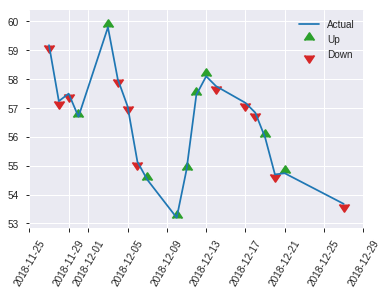


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2153102884494103
RMSE: 0.464015396780549
LogLoss: 0.6226861471155015
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.4623801242943
Residual deviance: 307.60695667505775
AIC: 409.60695667505775
AUC: 0.7138957138957139
pr_auc: 0.5810539969677128
Gini: 0.42779142779142787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4036700461731363: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   68   0.4595   (68.0/148.0)
1      19   80   0.1919   (19.0/99.0)
Total  99   148  0.3522   (87.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40367      0.647773  147
max f2                       0.229651     0.777414  214
max f0point5                 0.57289      0.610278  91
max accuracy                 0.57289      0.688259  91
max precision                0.800222     0.75      11
max recall                   0.088177     1         242
max specificity              0.896877     0.993243  0
max absolute_mcc             0.522269     0.35724   110
max min_per_class_accuracy   0.516025     0.676768  113
max mean_per_class_accuracy  0.522269     0.681306  110

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.866631           0.83165   0.83165            0.333333         0.887434  0.333333                    0.887434            0.010101        0.010101                   -16.835   -16.835
    2        0.0202429                   0.857598           1.24747   0.99798            0.5              0.86119   0.4                         0.876936            0.010101        0.020202                   24.7475   -0.20202
    3        0.0323887                   0.824801           2.49495   1.55934            1                0.839795  0.625                       0.863008            0.030303        0.0505051                  149.495   55.9343
    4        0.0404858                   0.808947           2.49495   1.74646            1                0.816764  0.7                         0.853759            0.020202        0.0707071                  149.495   74.6465
    5        0.0526316                   0.792928           1.6633    1.72727            0.666667         0.800224  0.692308                    0.841405            0.020202        0.0909091                  66.33     72.7273
    6        0.101215                    0.748276           1.6633    1.69657            0.666667         0.772391  0.68                        0.808278            0.0808081       0.171717                   66.33     69.6566
    7        0.149798                    0.71341            1.45539   1.61835            0.583333         0.728656  0.648649                    0.782455            0.0707071       0.242424                   45.5387   61.8346
    8        0.202429                    0.677991           1.91919   1.69657            0.769231         0.69914   0.68                        0.760793            0.10101         0.343434                   91.9192   69.6566
    9        0.299595                    0.617865           1.14352   1.5172             0.458333         0.646516  0.608108                    0.72373             0.111111        0.454545                   14.3519   51.7199
    10       0.40081                     0.553442           1.39717   1.48689            0.56             0.582449  0.59596                     0.688053            0.141414        0.59596                    39.7172   48.6889
    11       0.502024                    0.465946           0.99798   1.38832            0.4              0.519857  0.556452                    0.654143            0.10101         0.69697                    -0.20202  38.8319
    12       0.59919                     0.393472           1.14352   1.34862            0.458333         0.428948  0.540541                    0.617625            0.111111        0.808081                   14.3519   34.8621
    13       0.700405                    0.33024            0.598788  1.24026            0.24             0.363534  0.49711                     0.580906            0.0606061       0.868687                   -40.1212  24.0264
    14       0.797571                    0.277802           0.311869  1.12716            0.125            0.300635  0.451777                    0.546762            0.030303        0.89899                    -68.8131  12.716
    15       0.898785                    0.207361           0.598788  1.06766            0.24             0.24807   0.427928                    0.513125            0.0606061       0.959596                   -40.1212  6.76586
    16       1                           0.0330996          0.399192  1                  0.16             0.13867   0.40081                     0.475225         

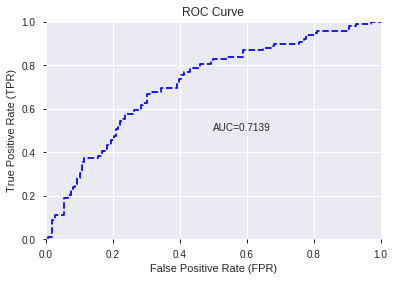

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


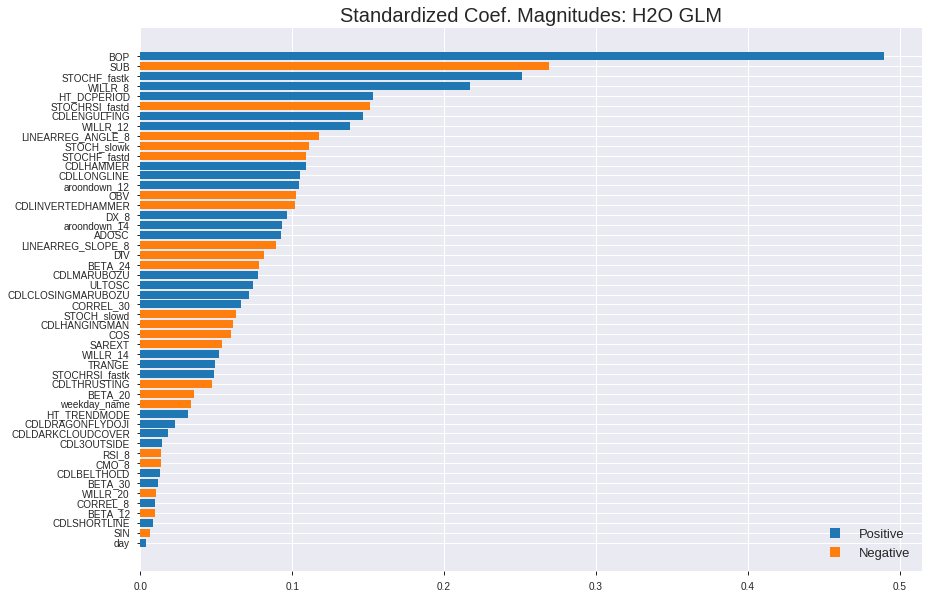

'log_likelihood'
--2019-08-28 17:05:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.83.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.83.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170527_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170527_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLHAMMER',
 'CDLLONGLINE',
 'aroondown_12',
 'OBV',
 'CDLINVERTEDHAMMER',
 'DX_8',
 'aroondown_14',
 'ADOSC',
 'LINEARREG_SLOPE_8',
 'DIV',
 'BETA_24',
 'CDLMARUBOZU',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CORREL_30',
 'STOCH_slowd',
 'CDLHANGINGMAN',
 'COS',
 'SAREXT',
 'WILLR_14',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLTHRUSTING',
 'BETA_20',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLDARKCLOUDCOVER',
 'CDL3OUTSIDE',
 'RSI_8',
 'CMO_8',
 'CDLBELTHOLD',
 'BETA_30',
 'WILLR_20',
 'CORREL_8',
 'BETA_12',
 'CDLSHORTLINE',
 'SIN',
 'day']

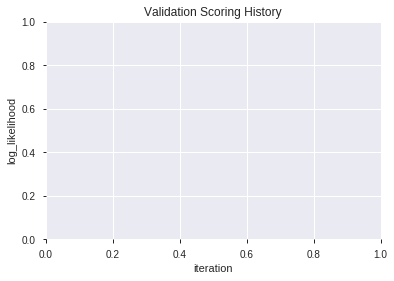

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170538_model_5  0.727068  0.620138              0.340875  0.460345  0.211917
1  XGBoost_grid_1_AutoML_20190828_170538_model_4  0.725293  0.607271              0.330808  0.457433  0.209245
2  XGBoost_grid_1_AutoML_20190828_170538_model_1  0.721608  0.617433              0.320536  0.461671  0.213140
3  XGBoost_grid_1_AutoML_20190828_170538_model_2  0.719902  0.614024              0.312108  0.460381  0.211951
4  XGBoost_grid_1_AutoML_20190828_170538_model_6  0.717786  0.619514              0.330740  0.462949  0.214322
5               XGBoost_3_AutoML_20190828_170538  0.716626  0.620683              0.340943  0.463611  0.214935
6  XGBoost_grid_1_AutoML_20190828_170538_model_3  0.705842  0.628104              0.378208  0.466457  0.217582
7               XGBoost_2_AutoML_20190828_170538  0.699563  0.633203              0.357835  0.469949  0.220852
8               XGBoost_1_AutoML_20190828_170538  0.691578  0.642446              0.345994  0.473109  0.223832
9  XGBoost_grid_1_AutoML_20190828_170538_model_7  0.686664  0.642341              0.342513  0.473921  0.224601

variable  relative_importance  scaled_importance  percentage
0                  BOP          2772.047119           1.000000    0.117377
1                  DIV           918.845642           0.331468    0.038907
2          HT_DCPERIOD           844.543701           0.304664    0.035761
3               SAREXT           843.541504           0.304303    0.035718
4                 DX_8           827.831055           0.298635    0.035053
5                  day           803.422607           0.289830    0.034019
6                  COS           773.655823           0.279092    0.032759
7             CORREL_8           747.532410           0.269668    0.031653
8                  SUB           746.612732           0.269336    0.031614
9                  SIN           734.519104           0.264974    0.031102
10        STOCHF_fastk           717.069214           0.258679    0.030363
11              TRANGE           693.285583           0.250099    0.029356
12         STOCH_slowd           677.814941           0.244518    0.028701
13             WILLR_8           667.329895           0.240735    0.028257
14               CMO_8           655.660645           0.236526    0.027763
15              ULTOSC           636.714661           0.229691    0.026961
16            WILLR_12           609.217224           0.219772    0.025796
17                 OBV           606.570435           0.218817    0.025684
18             BETA_30           572.853821           0.206654    0.024256
19             BETA_12           566.633728           0.204410    0.023993
20         STOCH_slowk           537.050049           0.193738    0.022740
21      STOCHRSI_fastk           513.356934           0.185191    0.021737
22             BETA_24           511.202301           0.184413    0.021646
23           CORREL_30           502.462555           0.181260    0.021276
24               ADOSC           494.950104           0.178550    0.020958
25            WILLR_20           477.562805           0.172278    0.020222
26             BETA_20           472.981445           0.170625    0.020028
27   LINEARREG_ANGLE_8           469.644440           0.169422    0.019886
28      STOCHRSI_fastd           456.963654           0.164847    0.019349
29        weekday_name           415.453766           0.149873    0.017592
30            WILLR_14           404.323334           0.145857    0.017120
31        aroondown_12           329.956390           0.119030    0.013971
32        aroondown_14           327.302521           0.118072    0.013859
33               RSI_8           290.776276           0.104896    0.012312
34   LINEARREG_SLOPE_8           241.855728           0.087248    0.010241
35        STOCHF_fastd           213.405518           0.076985    0.009036
36         CDLLONGLINE            89.094673           0.032140    0.003773
37         CDLBELTHOLD            76.542107           0.027612    0.003241
38  CDLCLOSINGMARUBOZU            69.468346           0.025060    0.002942
39        CDLSHORTLINE            62.469025           0.022535    0.002645
40        CDLENGULFING            61.108746           0.022045    0.002588
41           CDLHAMMER            60.468987           0.021814    0.002560
42        HT_TRENDMODE            34.186840           0.012333    0.001448
43         CDL3OUTSIDE            29.518831           0.010649    0.001250
44   CDLINVERTEDHAMMER            15.743896           0.005680    0.000667
45       CDLHANGINGMAN            14.376320           0.005186    0.000609
46    CDLDRAGONFLYDOJI            12.971012           0.004679    0.000549
47         CDLMARUBOZU             7.611218           0.002746    0.000322
48   CDLDARKCLOUDCOVER             4.992580           0.001801    0.000211
49        CDLTHRUSTING             3.054596           0.001102    0.000129

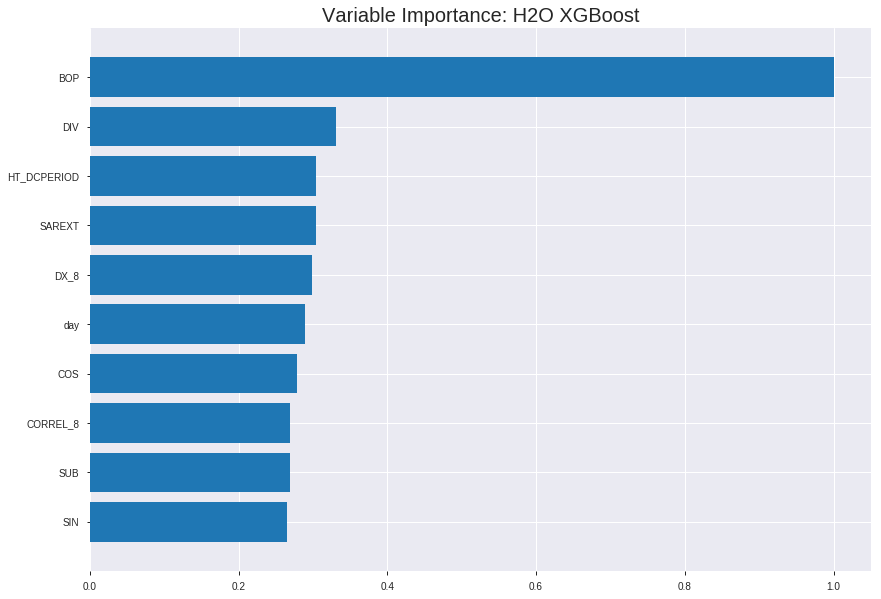

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170538_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.033098270190694834
RMSE: 0.18192929997857638
LogLoss: 0.18312127041305945
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988545246277205
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.537236213684082: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      855  0    0        (0.0/855.0)
1      0    873  0        (0.0/873.0)
Total  855  873  0        (0.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.537236     1        198
max f2                       0.537236     1        198
max f0point5                 0.537236     1        198
max accuracy                 0.537236     1        198
max precision                0.953384     1        0
max recall                   0.537236     1        198
max specificity              0.953384     1        0
max absolute_mcc             0.537236     1        198
max min_per_class_accuracy   0.537236     1        198
max mean_per_class_accuracy  0.537236     1        198

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.936586           1.97938   1.97938            1                0.943432   1                           0.943432            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.931816           1.97938   1.97938            1                0.933903   1                           0.938804            0.0194731       0.0400916                  97.9381   97.9381
    3        0.0300926                   0.927238           1.97938   1.97938            1                0.929821   1                           0.935867            0.0194731       0.0595647                  97.9381   97.9381
    4        0.0405093                   0.921481           1.97938   1.97938            1                0.923978   1                           0.93281             0.0206186       0.0801833                  97.9381   97.9381
    5        0.0503472                   0.916808           1.97938   1.97938            1                0.919079   1                           0.930127            0.0194731       0.0996564                  97.9381   97.9381
    6        0.100116                    0.901357           1.97938   1.97938            1                0.909252   1                           0.91975             0.0985109       0.198167                   97.9381   97.9381
    7        0.150463                    0.887382           1.97938   1.97938            1                0.893962   1                           0.911121            0.0996564       0.297824                   97.9381   97.9381
    8        0.200231                    0.870913           1.97938   1.97938            1                0.87875    1                           0.903075            0.0985109       0.396334                   97.9381   97.9381
    9        0.300347                    0.836196           1.97938   1.97938            1                0.854109   1                           0.886753            0.198167        0.594502                   97.9381   97.9381
    10       0.399884                    0.779312           1.97938   1.97938            1                0.810819   1                           0.867852            0.197022        0.791523                   97.9381   97.9381
    11       0.5                         0.59993            1.97938   1.97938            1                0.722578   1                           0.838763            0.198167        0.989691                   97.9381   97.9381
    12       0.600116                    0.236923           0.102974  1.66635            0.0520231        0.313668   0.841851                    0.751163            0.0103093       1                          -89.7026  66.6345
    13       0.699653                    0.165988           0         1.42928            0                0.198946   0.722084                    0.672601            0               1                          -100      42.928
    14       0.799769                    0.122598           0         1.25036            0                0.144188   0.631693                    0.606454            0               1                          -100      25.0362
    15       0.899884                    0.088055           0         1.11125            0                0.103843   0.561415                    0.550536            0               1                          -100      11.1254
    16       1                           0.0451429          0         1                  0                0.0718852  0.505208                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22047567371647356
RMSE: 0.4695483720730736
LogLoss: 0.6326889326506192
Mean Per-Class Error: 0.33134806539061856
AUC: 0.7168487636572742
pr_auc: 0.7223571974729387
Gini: 0.43369752731454847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2597741186618805: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   168  0.7149   (168.0/235.0)
1      18   241  0.0695   (18.0/259.0)
Total  85   409  0.3765   (186.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.259774     0.721557  321
max f2                       0.112066     0.857713  375
max f0point5                 0.672934     0.688847  148
max accuracy                 0.641074     0.665992  164
max precision                0.941436     1         0
max recall                   0.0907882    1         383
max specificity              0.941436     1         0
max absolute_mcc             0.672934     0.338801  148
max min_per_class_accuracy   0.605605     0.65251   185
max mean_per_class_accuracy  0.641074     0.668652  164

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.919851           1.52587   1.52587            0.8              0.930523  0.8                         0.930523            0.015444        0.015444                   52.5869   52.5869
    2        0.0202429                   0.909754           1.90734   1.7166             1                0.914256  0.9                         0.922389            0.019305        0.034749                   90.7336   71.6602
    3        0.0303644                   0.896422           1.52587   1.65302            0.8              0.907366  0.866667                    0.917381            0.015444        0.0501931                  52.5869   65.3024
    4        0.0404858                   0.889865           1.90734   1.7166             1                0.893512  0.9                         0.911414            0.019305        0.0694981                  90.7336   71.6602
    5        0.0506073                   0.883064           0.762934  1.52587            0.4              0.88744   0.8                         0.906619            0.00772201      0.0772201                  -23.7066  52.5869
    6        0.101215                    0.862012           1.75475   1.64031            0.92             0.873544  0.86                        0.890082            0.0888031       0.166023                   75.4749   64.0309
    7        0.149798                    0.834489           1.35103   1.54649            0.708333         0.846205  0.810811                    0.875851            0.0656371       0.23166                    35.103    54.6489
    8        0.200405                    0.7976             1.29699   1.48348            0.68             0.8173    0.777778                    0.861066            0.0656371       0.297297                   29.6988   48.3483
    9        0.299595                    0.740007           1.36238   1.44339            0.714286         0.772068  0.756757                    0.8316              0.135135        0.432432                   36.2383   44.3389
    10       0.40081                     0.67732            1.22069   1.38715            0.64             0.710737  0.727273                    0.801079            0.123552        0.555985                   22.0695   38.7153
    11       0.5                         0.607286           0.89528   1.28958            0.469388         0.642756  0.676113                    0.769671            0.0888031       0.644788                   -10.472   28.9575
    12       0.59919                     0.526278           0.89528   1.2243             0.469388         0.568076  0.641892                    0.736299            0.0888031       0.733591                   -10.472   22.4303
    13       0.700405                    0.412577           0.762934  1.15763            0.4              0.468295  0.606936                    0.69757             0.0772201       0.810811                   -23.7066  15.7632
    14       0.799595                    0.294873           0.89528   1.12509            0.469388         0.360771  0.589873                    0.65579             0.0888031       0.899614                   -10.472   12.5087
    15       0.898785                    0.159627           0.583878  1.06536            0.306122         0.225868  0.558559                    0.608343            0.0579151       0.957529                   -41.6122  6.53588
    16       1                           0.0497562          0.419614  1                  0.22             0.10481   0.524291                    0.557379         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:05:48  4.902 sec   0                  0.5              0.693147            0.5             0                  1                0.494792                         0.5                0.693147              0.5               0                    1                  0.475709
    2019-08-28 17:05:48  5.241 sec   5                  0.438494         0.576535            0.978056        0.966828           1.97938          0.0775463                        0.483093           0.659559              0.686076          0.691057             1.90734            0.34413
    2019-08-28 17:05:48  5.566 sec   10                 0.38541          0.484528            0.995935        0.987157           1.97938          0.0266204                        0.472872           0.63905               0.705586          0.704866             1.90734            0.338057
    2019-08-28 17:05:49  5.875 sec   15                 0.34563          0.419515            0.998144        0.994566           1.97938          0.0185185                        0.466813           0.626449              0.71431           0.713998             1.52587            0.34413
    2019-08-28 17:05:49  6.211 sec   20                 0.31015          0.36396             0.999018        0.99558            1.97938          0.0121528                        0.464874           0.621893              0.713891          0.707573             1.52587            0.360324
    2019-08-28 17:05:49  6.548 sec   25                 0.279485         0.318169            0.999594        0.995015           1.97938          0.00752315                       0.464843           0.620993              0.710704          0.708124             1.52587            0.370445
    2019-08-28 17:05:50  6.903 sec   30                 0.252756         0.279317            0.999848        0.998704           1.97938          0.00462963                       0.465795           0.622645              0.710071          0.710907             1.52587            0.368421
    2019-08-28 17:05:50  7.250 sec   35                 0.229799         0.247271            0.999977        0.997686           1.97938          0.00173611                       0.465382           0.622022              0.715304          0.716143             1.52587            0.37247
    2019-08-28 17:05:50  7.618 sec   40                 0.211479         0.222113            0.999995        0.998849           1.97938          0.00115741                       0.468334           0.629526              0.711197          0.706944             1.52587            0.37247
    2019-08-28 17:05:51  7.960 sec   45                 0.196047         0.201267            1               0.998855           1.97938          0                                0.468731           0.630776              0.715288          0.715723             1.52587            0.376518
    2019-08-28 17:05:51  8.327 sec   50                 0.181929         0.183121            1               0.998855           1.97938          0                                0.469548           0.632689              0.716849          0.722357             1.52587            0.376518

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                2772.047119140625      1.0                    0.11737727638552507
DIV                918.8456420898438      0.33146826247841676    0.038906841857958896
HT_DCPERIOD        844.543701171875       0.30466426610875785    0.03576066176784083
SAREXT             843.54150390625        0.3043027292291338     0.03571822555359763
DX_8               827.8310546875         0.2986352753427004     0.035052995252367526
---                ---                    ---                    ---
CDLHANGINGMAN      14.376319885253906     0.005186174428994113   0.0006087390293355846
CDLDRAGONFLYDOJI   12.971012115478516     0.004679217761456998   0.000549233836454596
CDLMARUBOZU        7.611218452453613      0.002745703130332504   0.00032228315520163966
CDLDARKCLOUDCOVER  4.992579936981201      0.0018010443987434722  0.00021140168617391435
CDLTHRUSTING       3.054596424102783      0.0011019280310970157  0.00012934131106303185


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.6345381526104418)

('auc', 0.7270679770679771)

('logloss', 0.620137808923581)

('mean_per_class_error', 0.2966147966147966)

('rmse', 0.4603445365951318)

('mse', 0.21191709237298664)

xgboost prediction progress: |████████████████████████████████████████████| 100%


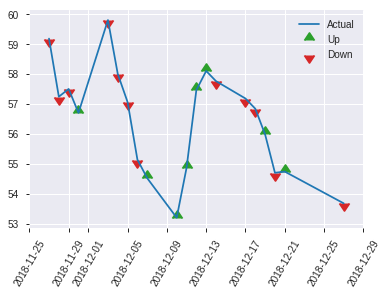


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21191709237298664
RMSE: 0.4603445365951318
LogLoss: 0.620137808923581
Mean Per-Class Error: 0.2966147966147966
AUC: 0.7270679770679771
pr_auc: 0.6327102199102177
Gini: 0.4541359541359542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38452279567718506: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   71   0.4797   (71.0/148.0)
1      20   79   0.202    (20.0/99.0)
Total  97   150  0.3684   (91.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384523     0.634538  149
max f2                       0.0649728    0.773438  243
max f0point5                 0.596888     0.659955  86
max accuracy                 0.596888     0.724696  86
max precision                0.821825     0.826087  22
max recall                   0.0649728    1         243
max specificity              0.915483     0.993243  0
max absolute_mcc             0.596888     0.417329  86
max min_per_class_accuracy   0.475475     0.676768  113
max mean_per_class_accuracy  0.596888     0.703385  86

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 46.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.896246           1.6633    1.6633             0.666667         0.906558   0.666667                    0.906558            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.878598           1.24747   1.49697            0.5              0.886484   0.6                         0.898529            0.010101        0.030303                   24.7475   49.697
    3        0.0323887                   0.873696           2.49495   1.87121            1                0.876747   0.75                        0.890361            0.030303        0.0606061                  149.495   87.1212
    4        0.0404858                   0.86122            1.24747   1.74646            0.5              0.869716   0.7                         0.886232            0.010101        0.0707071                  24.7475   74.6465
    5        0.0526316                   0.855455           2.49495   1.91919            1                0.85875    0.769231                    0.87989             0.030303        0.10101                    149.495   91.9192
    6        0.101215                    0.813357           2.07912   1.99596            0.833333         0.832334   0.8                         0.857063            0.10101         0.20202                    107.912   99.596
    7        0.149798                    0.76911            1.24747   1.75321            0.5              0.790337   0.702703                    0.835422            0.0606061       0.262626                   24.7475   75.3208
    8        0.202429                    0.754637           2.11111   1.84626            0.846154         0.760284   0.74                        0.815886            0.111111        0.373737                   111.111   84.6263
    9        0.299595                    0.655462           1.45539   1.71949            0.583333         0.702949   0.689189                    0.779258            0.141414        0.515152                   45.5387   71.9492
    10       0.40081                     0.547306           0.898182  1.51209            0.36             0.5985     0.606061                    0.733612            0.0909091       0.606061                   -10.1818  51.2091
    11       0.502024                    0.450968           0.99798   1.40844            0.4              0.490432   0.564516                    0.684584            0.10101         0.707071                   -0.20202  40.8439
    12       0.59919                     0.385903           0.83165   1.31491            0.333333         0.41842    0.527027                    0.641422            0.0808081       0.787879                   -16.835   31.4906
    13       0.700405                    0.277105           0.698586  1.22584            0.28             0.337769   0.491329                    0.597541            0.0707071       0.858586                   -30.1414  22.5842
    14       0.797571                    0.202659           0.311869  1.1145             0.125            0.237638   0.446701                    0.553695            0.030303        0.888889                   -68.8131  11.4495
    15       0.898785                    0.129313           0.598788  1.05642            0.24             0.16888    0.423423                    0.51036             0.0606061       0.949495                   -40.1212  5.64201
    16       1                           0.0520216          0.49899   1                  0.2              0.0942509  0.40081                     0.4

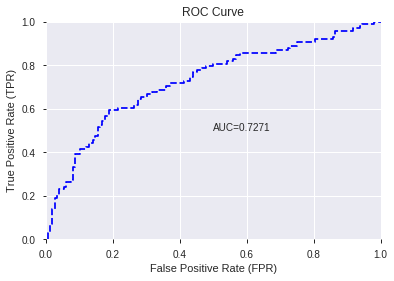

This function is available for GLM models only


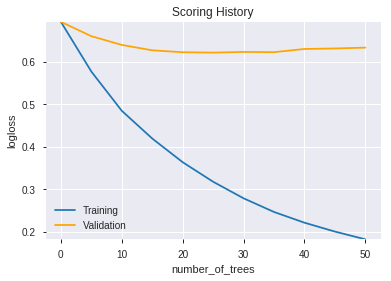

--2019-08-28 17:05:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170538_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170538_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'HT_DCPERIOD',
 'SAREXT',
 'DX_8',
 'day',
 'COS',
 'CORREL_8',
 'SUB',
 'SIN',
 'STOCHF_fastk',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_8',
 'CMO_8',
 'ULTOSC',
 'WILLR_12',
 'OBV',
 'BETA_30',
 'BETA_12',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'BETA_24',
 'CORREL_30',
 'ADOSC',
 'WILLR_20',
 'BETA_20',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastd',
 'weekday_name',
 'WILLR_14',
 'aroondown_12',
 'aroondown_14',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'STOCHF_fastd',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'CDL3OUTSIDE',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_170604_model_1  0.719697  0.620124              0.311937  0.463328  0.214673

variable  relative_importance  scaled_importance    percentage
0                          BOP         3.157995e-01       1.000000e+00  3.123810e-02
1                          SUB         1.671217e-01       5.292018e-01  1.653126e-02
2                 STOCHF_fastk         1.471021e-01       4.658086e-01  1.455097e-02
3                  HT_DCPERIOD         1.212778e-01       3.840342e-01  1.199650e-02
4                  CDLLONGLINE         1.165568e-01       3.690849e-01  1.152951e-02
...                        ...                  ...                ...           ...
1036   BBANDS_lowerband_12_2_3         1.140015e-05       3.609934e-05  1.127675e-06
1037  BBANDS_middleband_20_2_2         8.948259e-06       2.833525e-05  8.851395e-07
1038   BBANDS_upperband_24_2_4         7.184039e-06       2.274873e-05  7.106272e-07
1039   BBANDS_upperband_12_0_2         1.575782e-06       4.989818e-06  1.558724e-07
1040                    SUM_12         1.595256e-07       5.051485e-07  1.577988e-08

[1041 rows x 4 columns]

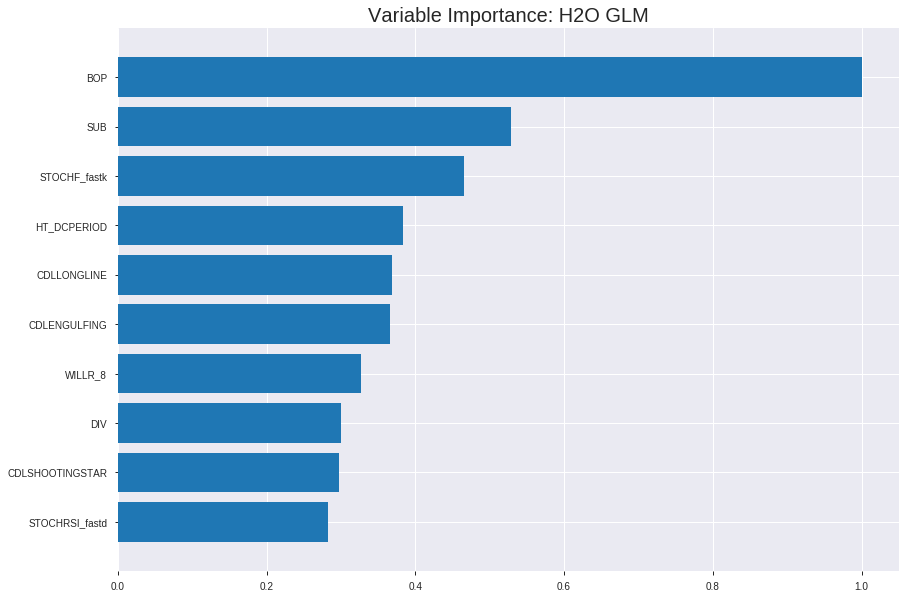

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170604_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18442347344961163
RMSE: 0.42944554189048423
LogLoss: 0.5480212558963948
Null degrees of freedom: 1727
Residual degrees of freedom: 686
Null deviance: 2395.329152624184
Residual deviance: 1893.9614603779405
AIC: 3977.9614603779405
AUC: 0.8010141811190826
pr_auc: 0.7970341854490353
Gini: 0.6020283622381652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42224482961484977: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      502  353   0.4129   (353.0/855.0)
1      130  743   0.1489   (130.0/873.0)
Total  632  1096  0.2795   (483.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422245     0.754698  235
max f2                       0.207023     0.851295  341
max f0point5                 0.558679     0.730381  167
max accuracy                 0.477317     0.734375  209
max precision                0.954356     1         0
max recall                   0.0927607    1         382
max specificity              0.954356     1         0
max absolute_mcc             0.477317     0.470733  209
max min_per_class_accuracy   0.51252      0.715789  189
max mean_per_class_accuracy  0.477317     0.733798  209

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.911452           1.97938   1.97938            1                0.928533  1                           0.928533            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.880926           1.86295   1.92283            0.941176         0.894813  0.971429                    0.912155            0.0183276       0.0389462                  86.2947   92.2828
    3        0.0300926                   0.867342           1.74651   1.86519            0.882353         0.874777  0.942308                    0.899935            0.0171821       0.0561283                  74.6513   86.5186
    4        0.0405093                   0.841354           1.86942   1.86627            0.944444         0.85499   0.942857                    0.888378            0.0194731       0.0756014                  86.9416   86.6274
    5        0.0503472                   0.830775           1.86295   1.86562            0.941176         0.83613   0.942529                    0.878168            0.0183276       0.093929                   86.2947   86.5624
    6        0.100116                    0.777758           1.77224   1.8192             0.895349         0.800868  0.919075                    0.839741            0.0882016       0.182131                   77.2237   81.92
    7        0.150463                    0.73823            1.63811   1.7586             0.827586         0.75699   0.888462                    0.812052            0.0824742       0.264605                   63.8109   75.8604
    8        0.200231                    0.710436           1.54208   1.70479            0.77907          0.724369  0.861272                    0.790258            0.0767468       0.341352                   54.2076   70.4785
    9        0.300347                    0.647562           1.33866   1.58274            0.676301         0.678843  0.799615                    0.753119            0.134021        0.475372                   33.8657   58.2742
    10       0.399884                    0.580311           1.33493   1.52106            0.674419         0.613438  0.768452                    0.718351            0.132875        0.608247                   33.4932   52.1059
    11       0.5                         0.514034           1.05262   1.42726            0.531792         0.546478  0.721065                    0.683937            0.105384        0.713631                   5.2619    42.7262
    12       0.600116                    0.450729           1.06406   1.36667            0.537572         0.48118   0.690453                    0.650111            0.106529        0.82016                    6.40605   36.667
    13       0.699653                    0.376617           0.748022  1.27866            0.377907         0.412618  0.645988                    0.616324            0.0744559       0.894616                   -25.1978  27.8657
    14       0.799769                    0.299377           0.514868  1.18305            0.260116         0.340926  0.597685                    0.581849            0.0515464       0.946163                   -48.5132  18.3046
    15       0.899884                    0.212702           0.366128  1.09216            0.184971         0.25512   0.551768                    0.545499            0.0366552       0.982818                   -63.3872  9.21603
    16       1                           0.00761267         0.171623  1                  0.0867052        0.143054  0.505208                    0.505208            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20751692058296847
RMSE: 0.455540251331283
LogLoss: 0.60380725062304
Null degrees of freedom: 493
Residual degrees of freedom: -548
Null deviance: 684.3830016464425
Residual deviance: 596.5615636155634
AIC: 2680.5615636155635
AUC: 0.737492811960897
pr_auc: 0.7228743640656154
Gini: 0.474985623921794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43310199862048016: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  127  0.5404   (127.0/235.0)
1      33   226  0.1274   (33.0/259.0)
Total  141  353  0.3239   (160.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433102     0.738562  281
max f2                       0.299626     0.855578  340
max f0point5                 0.629664     0.704091  164
max accuracy                 0.446907     0.680162  273
max precision                0.955423     1         0
max recall                   0.147156     1         386
max specificity              0.955423     1         0
max absolute_mcc             0.446907     0.371014  273
max min_per_class_accuracy   0.565664     0.655319  200
max mean_per_class_accuracy  0.593888     0.680235  184

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101215                   0.930223           1.52587   1.52587            0.8              0.943997  0.8                         0.943997            0.015444        0.015444                   52.5869    52.5869
    2        0.0202429                   0.909869           1.52587   1.52587            0.8              0.920593  0.8                         0.932295            0.015444        0.030888                   52.5869    52.5869
    3        0.0303644                   0.888939           1.52587   1.52587            0.8              0.902142  0.8                         0.922244            0.015444        0.046332                   52.5869    52.5869
    4        0.0404858                   0.879486           1.52587   1.52587            0.8              0.883938  0.8                         0.912668            0.015444        0.0617761                  52.5869    52.5869
    5        0.0506073                   0.872097           1.90734   1.60216            1                0.875598  0.84                        0.905254            0.019305        0.0810811                  90.7336    60.2162
    6        0.101215                    0.825032           1.37328   1.48772            0.72             0.843036  0.78                        0.874145            0.0694981       0.150579                   37.3282    48.7722
    7        0.149798                    0.789319           1.35103   1.44339            0.708333         0.806778  0.756757                    0.852296            0.0656371       0.216216                   35.103     44.3389
    8        0.200405                    0.763697           1.52587   1.46422            0.8              0.77543   0.767677                    0.832886            0.0772201       0.293436                   52.5869    46.4217
    9        0.299595                    0.694904           1.51808   1.48205            0.795918         0.729047  0.777027                    0.798507            0.150579        0.444015                   51.8084    48.2052
    10       0.40081                     0.62952            1.25884   1.42569            0.66             0.663039  0.747475                    0.764298            0.127413        0.571429                   25.8842    42.5685
    11       0.5                         0.569124           0.778504  1.2973             0.408163         0.601176  0.680162                    0.731938            0.0772201       0.648649                   -22.1496   29.7297
    12       0.59919                     0.507335           1.12883   1.26941            0.591837         0.541271  0.665541                    0.700375            0.111969        0.760618                   12.8831    26.9409
    13       0.700405                    0.441056           0.991815  1.22929            0.52             0.474273  0.644509                    0.667701            0.100386        0.861004                   -0.818533  22.9295
    14       0.799595                    0.360816           0.661729  1.15889            0.346939         0.401412  0.607595                    0.634668            0.0656371       0.926641                   -33.8271   15.8888
    15       0.898785                    0.238027           0.389252  1.07395            0.204082         0.308105  0.563063                    0.598628            0.03861         0.965251                   -61.0748   7.39504
    16       1                           0.0717927          0.34332   1                  0.18             0.179389  0.524291                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:06:08  0.000 sec   2            .21E2     1017          1.3604565239475976  1.366417358851023
     2019-08-28 17:06:10  2.235 sec   4            .15E2     1035          1.353306487474812   1.3610316718100979
     2019-08-28 17:06:12  4.535 sec   6            .11E2     1036          1.3444806802832518  1.3543584493861893
     2019-08-28 17:06:14  6.808 sec   8            .81E1     1036          1.3337619609514835  1.3462624362391085
     2019-08-28 17:06:17  9.094 sec   10           .59E1     1040          1.3209871181831812  1.3366142684548175
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:06:49  41.148 sec  38           .69E-1    1042          1.0846853132415022  1.2092118929701214
     2019-08-28 17:06:51  43.423 sec  40           .5E-1     1042          1.0744117196680565  1.2124292091364017
     2019-08-28 17:06:53  45.732 sec  42           .37E-1    1042          1.0651007415085052  1.2171837179041043
     2019-08-28 17:06:56  48.099 sec  44           .27E-1    1042          1.0566519072773508  1.22310929133507
     2019-08-28 17:06:58  50.405 sec  46           .19E-1    1042          1.0489631054738149  1.2299860312718878


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.708502024291498)

('F1', 0.6346153846153847)

('auc', 0.7196969696969697)

('logloss', 0.6201242201139374)

('mean_per_class_error', 0.3119369369369369)

('rmse', 0.4633277381965502)

('mse', 0.21467259298233096)

glm prediction progress: |████████████████████████████████████████████████| 100%


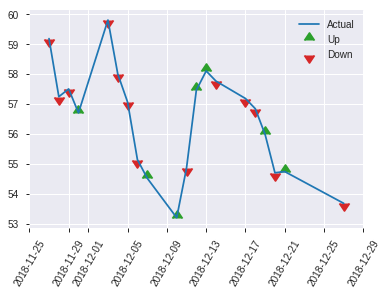


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21467259298233096
RMSE: 0.4633277381965502
LogLoss: 0.6201242201139374
Null degrees of freedom: 246
Residual degrees of freedom: -795
Null deviance: 343.4623801242943
Residual deviance: 306.3413647362851
AIC: 2390.341364736285
AUC: 0.7196969696969697
pr_auc: 0.5988344205512898
Gini: 0.43939393939393945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5110236578789884: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      105  43   0.2905   (43.0/148.0)
1      33   66   0.3333   (33.0/99.0)
Total  138  109  0.3077   (76.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511024     0.634615  108
max f2                       0.19873      0.778491  226
max f0point5                 0.598067     0.638554  78
max accuracy                 0.598067     0.708502  78
max precision                0.902718     1         0
max recall                   0.141806     1         239
max specificity              0.902718     1         0
max absolute_mcc             0.598067     0.377915  78
max min_per_class_accuracy   0.506144     0.676768  112
max mean_per_class_accuracy  0.511024     0.688063  108

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.880778           1.6633    1.6633             0.666667         0.893019  0.666667                    0.893019            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.840265           1.24747   1.49697            0.5              0.880054  0.6                         0.887833            0.010101        0.030303                   24.7475   49.697
    3        0.0323887                   0.824071           1.6633    1.55934            0.666667         0.829085  0.625                       0.865802            0.020202        0.0505051                  66.33     55.9343
    4        0.0404858                   0.818338           2.49495   1.74646            1                0.821872  0.7                         0.857016            0.020202        0.0707071                  149.495   74.6465
    5        0.0526316                   0.79493            1.6633    1.72727            0.666667         0.805393  0.692308                    0.845103            0.020202        0.0909091                  66.33     72.7273
    6        0.101215                    0.746887           1.6633    1.69657            0.666667         0.775375  0.68                        0.811634            0.0808081       0.171717                   66.33     69.6566
    7        0.149798                    0.694109           1.6633    1.68578            0.666667         0.717151  0.675676                    0.780991            0.0808081       0.252525                   66.33     68.5777
    8        0.202429                    0.664002           1.91919   1.74646            0.769231         0.678443  0.7                         0.754328            0.10101         0.353535                   91.9192   74.6465
    9        0.299595                    0.609728           1.35143   1.61835            0.541667         0.637758  0.648649                    0.716522            0.131313        0.484848                   35.1431   61.8346
    10       0.40081                     0.532771           1.09778   1.48689            0.44             0.575496  0.59596                     0.680909            0.111111        0.59596                    9.77778   48.6889
    11       0.502024                    0.488272           0.99798   1.38832            0.4              0.50853   0.556452                    0.646155            0.10101         0.69697                    -0.20202  38.8319
    12       0.59919                     0.407299           0.727694  1.28119            0.291667         0.446957  0.513514                    0.613853            0.0707071       0.767677                   -27.2306  28.119
    13       0.700405                    0.352075           0.798384  1.21142            0.32             0.381301  0.485549                    0.580247            0.0808081       0.848485                   -20.1616  21.1421
    14       0.797571                    0.304565           0.727694  1.15249            0.291667         0.329015  0.461929                    0.54964             0.0707071       0.919192                   -27.2306  15.2489
    15       0.898785                    0.224779           0.399192  1.06766            0.16             0.272486  0.427928                    0.518429            0.040404        0.959596                   -60.0808  6.76586
    16       1                           0.0508999          0.399192  1                  0.16             0.159045  0.40081                     0.482054            0

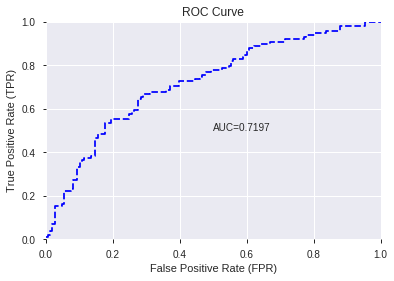

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


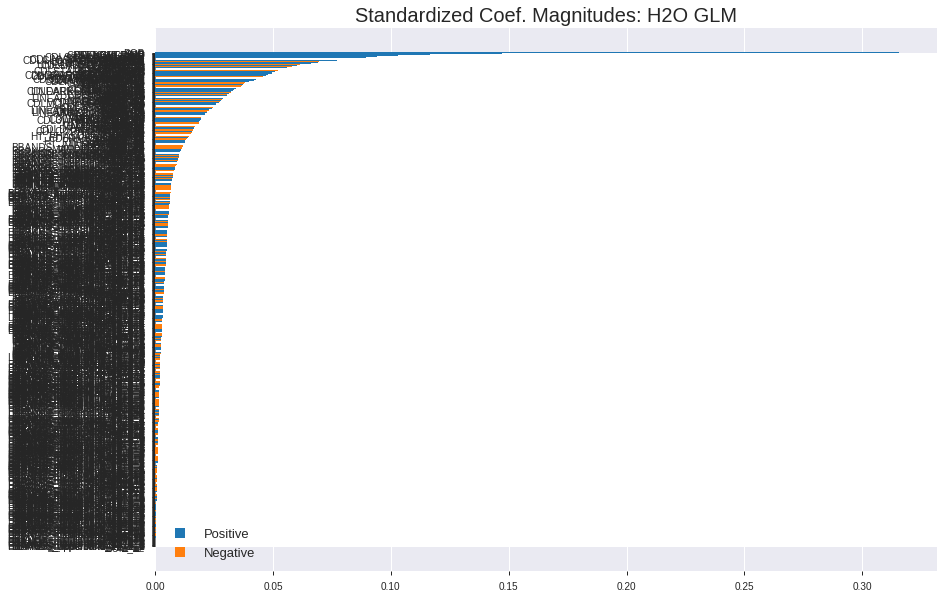

'log_likelihood'
--2019-08-28 17:07:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.68
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170604_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170604_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

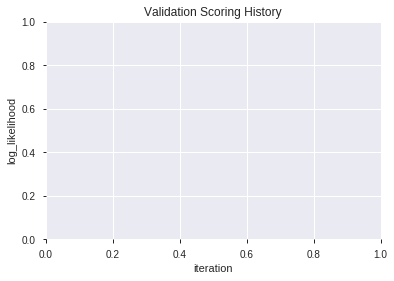

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170729_model_1  0.737169  0.607576              0.320673  0.456302  0.208212
1  XGBoost_grid_1_AutoML_20190828_170729_model_4  0.735121  0.601635              0.332514  0.454627  0.206685
2  XGBoost_grid_1_AutoML_20190828_170729_model_2  0.733074  0.603587              0.329034  0.455929  0.207872
3               XGBoost_3_AutoML_20190828_170729  0.733006  0.606490              0.324154  0.457287  0.209111
4  XGBoost_grid_1_AutoML_20190828_170729_model_5  0.730822  0.624448              0.330808  0.463524  0.214854
5  XGBoost_grid_1_AutoML_20190828_170729_model_6  0.726044  0.610766              0.351215  0.459444  0.211089
6               XGBoost_2_AutoML_20190828_170729  0.723860  0.611726              0.335824  0.459224  0.210887
7  XGBoost_grid_1_AutoML_20190828_170729_model_3  0.723109  0.608035              0.322345  0.458576  0.210292
8  XGBoost_grid_1_AutoML_20190828_170729_model_7  0.719970  0.615154              0.324017  0.461234  0.212737
9               XGBoost_1_AutoML_20190828_170729  0.705774  0.633370              0.328931  0.470396  0.221273

variable  relative_importance  scaled_importance  percentage
0                        BOP          2987.250732           1.000000    0.307429
1                        DIV           412.937927           0.138233    0.042497
2                        SUB           385.456940           0.129034    0.039669
3               STOCHF_fastk           304.283691           0.101861    0.031315
4             STOCHRSI_fastk           265.037750           0.088723    0.027276
..                       ...                  ...                ...         ...
238  BBANDS_lowerband_14_3_4             1.314647           0.000440    0.000135
239                   ATR_12             1.291016           0.000432    0.000133
240                    ATR_8             1.077459           0.000361    0.000111
241               PLUS_DM_20             0.411900           0.000138    0.000042
242                  ROCP_24             0.027479           0.000009    0.000003

[243 rows x 4 columns]

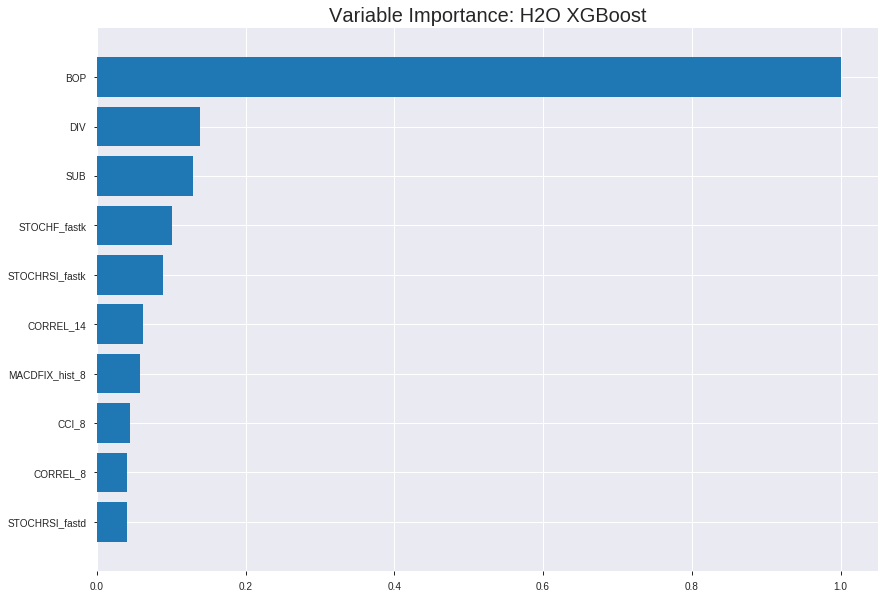

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170729_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12762469322868486
RMSE: 0.35724598420232084
LogLoss: 0.4193576363314444
Mean Per-Class Error: 0.14040513655272202
AUC: 0.9381014583040266
pr_auc: 0.9423995136668657
Gini: 0.8762029166080532
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5326773524284363: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      753  102  0.1193   (102.0/855.0)
1      141  732  0.1615   (141.0/873.0)
Total  894  834  0.1406   (243.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532677     0.857645  186
max f2                       0.341265     0.907647  274
max f0point5                 0.569483     0.88281   168
max accuracy                 0.532677     0.859375  186
max precision                0.936299     1         0
max recall                   0.244552     1         318
max specificity              0.936299     1         0
max absolute_mcc             0.532677     0.719585  186
max min_per_class_accuracy   0.51229      0.852234  196
max mean_per_class_accuracy  0.532677     0.859595  186

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.901209           1.97938    1.97938            1                0.914413  1                           0.914413            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.891503           1.97938    1.97938            1                0.896721  1                           0.90582             0.0194731       0.0400916                  97.9381   97.9381
    3        0.0300926                   0.884537           1.97938    1.97938            1                0.887459  1                           0.899817            0.0194731       0.0595647                  97.9381   97.9381
    4        0.0405093                   0.871421           1.97938    1.97938            1                0.877549  1                           0.894091            0.0206186       0.0801833                  97.9381   97.9381
    5        0.0503472                   0.8622             1.97938    1.97938            1                0.865682  1                           0.88854             0.0194731       0.0996564                  97.9381   97.9381
    6        0.100116                    0.818606           1.97938    1.97938            1                0.843267  1                           0.866034            0.0985109       0.198167                   97.9381   97.9381
    7        0.150463                    0.779258           1.97938    1.97938            1                0.797406  1                           0.84307             0.0996564       0.297824                   97.9381   97.9381
    8        0.200231                    0.742932           1.95637    1.97366            0.988372         0.760043  0.99711                     0.822434            0.0973654       0.395189                   95.6365   97.3661
    9        0.300347                    0.665433           1.8192     1.92217            0.919075         0.707045  0.971098                    0.783971            0.182131        0.57732                    81.92     92.2174
    10       0.399884                    0.588985           1.56509    1.83329            0.790698         0.626912  0.926194                    0.744877            0.155785        0.733104                   56.5092   83.3291
    11       0.5                         0.514528           1.16703    1.69989            0.589595         0.554956  0.858796                    0.706849            0.116838        0.849943                   16.7034   69.9885
    12       0.600116                    0.436555           0.732257   1.53846            0.369942         0.472315  0.777242                    0.667722            0.0733104       0.923253                   -26.7743  53.8458
    13       0.699653                    0.352191           0.529369   1.3949             0.267442         0.393429  0.704715                    0.628699            0.0526919       0.975945                   -47.0631  39.4899
    14       0.799769                    0.259984           0.22883    1.24893            0.115607         0.302593  0.63097                     0.587877            0.0229095       0.998855                   -77.117   24.893
    15       0.899884                    0.173843           0.0114415  1.11125            0.00578035       0.217116  0.561415                    0.546628            0.00114548      1                          -98.8558  11.1254
    16       1                           0.0616029          0          1                  0                0.12896   0.505208                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21225944654403897
RMSE: 0.46071623212563173
LogLoss: 0.6103801342267083
Mean Per-Class Error: 0.3394643884005586
AUC: 0.72242668200115
pr_auc: 0.7369654968112639
Gini: 0.4448533640023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3384827971458435: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   157  0.6681   (157.0/235.0)
1      19   240  0.0734   (19.0/259.0)
Total  97   397  0.3563   (176.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338483     0.731707  314
max f2                       0.177908     0.855438  378
max f0point5                 0.592198     0.679654  176
max accuracy                 0.515636     0.659919  228
max precision                0.898846     1         0
max recall                   0.155558     1         385
max specificity              0.898846     1         0
max absolute_mcc             0.367685     0.328058  301
max min_per_class_accuracy   0.56707      0.637066  195
max mean_per_class_accuracy  0.592198     0.660536  176

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 54.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.876438           1.90734   1.90734            1                0.888456  1                           0.888456            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.861904           1.90734   1.90734            1                0.867921  1                           0.878188            0.019305        0.03861                    90.7336   90.7336
    3        0.0303644                   0.85936            1.90734   1.90734            1                0.861158  1                           0.872512            0.019305        0.0579151                  90.7336   90.7336
    4        0.0404858                   0.852314           1.1444    1.7166             0.6              0.854853  0.9                         0.868097            0.011583        0.0694981                  14.4402   71.6602
    5        0.0506073                   0.846087           1.90734   1.75475            1                0.850424  0.92                        0.864562            0.019305        0.0888031                  90.7336   75.4749
    6        0.101215                    0.802836           1.44958   1.60216            0.76             0.822516  0.84                        0.843539            0.0733591       0.162162                   44.9575   60.2162
    7        0.149798                    0.776644           1.74839   1.64959            0.916667         0.787168  0.864865                    0.825257            0.0849421       0.247104                   74.8391   64.9588
    8        0.200405                    0.749707           1.37328   1.57981            0.72             0.764116  0.828283                    0.809817            0.0694981       0.316602                   37.3282   57.9814
    9        0.299595                    0.689666           1.24561   1.46916            0.653061         0.714672  0.77027                     0.778316            0.123552        0.440154                   24.5607   46.9164
    10       0.40081                     0.635853           0.953668  1.33899            0.5              0.662592  0.70202                     0.749093            0.0965251       0.53668                    -4.6332   33.8988
    11       0.5                         0.569348           0.973131  1.26641            0.510204         0.597325  0.663968                    0.718985            0.0965251       0.633205                   -2.68694  26.6409
    12       0.59919                     0.511418           1.12883   1.24363            0.591837         0.541391  0.652027                    0.689586            0.111969        0.745174                   12.8831   24.3635
    13       0.700405                    0.443121           0.762934  1.17417            0.4              0.480621  0.615607                    0.659389            0.0772201       0.822394                   -23.7066  17.4169
    14       0.799595                    0.340488           0.973131  1.14923            0.510204         0.395344  0.602532                    0.626634            0.0965251       0.918919                   -2.68694  14.923
    15       0.898785                    0.256976           0.428177  1.06965            0.22449          0.298921  0.560811                    0.590467            0.042471        0.96139                    -57.1823  6.96546
    16       1                           0.0630067          0.381467  1                  0.2              0.187319  0.524291                    0.549663          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:07:49  0.012 sec   0                  0.5              0.693147            0.5             0                  1                0.494792                         0.5                0.693147              0.5               0                    1                  0.475709
    2019-08-28 17:07:51  1.149 sec   5                  0.467723         0.630214            0.859707        0.836904           1.97938          0.233218                         0.482548           0.658599              0.71965           0.728136             1.90734            0.366397
    2019-08-28 17:07:51  1.393 sec   10                 0.443712         0.584503            0.873134        0.875586           1.97938          0.219329                         0.473535           0.640432              0.712741          0.730567             1.90734            0.348178
    2019-08-28 17:07:51  1.640 sec   15                 0.425282         0.549549            0.886256        0.894616           1.97938          0.20081                          0.469237           0.631289              0.708708          0.726453             1.52587            0.354251
    2019-08-28 17:07:51  1.902 sec   20                 0.410038         0.520308            0.896765        0.903921           1.97938          0.189236                         0.465046           0.622393              0.715017          0.728375             1.52587            0.34413
    2019-08-28 17:07:52  2.160 sec   25                 0.398475         0.497863            0.904007        0.910096           1.97938          0.182292                         0.463547           0.618615              0.715436          0.724043             1.52587            0.3583
    2019-08-28 17:07:52  2.405 sec   30                 0.389098         0.479434            0.90995         0.914869           1.97938          0.180556                         0.462434           0.615837              0.716315          0.724725             1.52587            0.350202
    2019-08-28 17:07:52  2.647 sec   35                 0.380045         0.462179            0.917923        0.921879           1.97938          0.168981                         0.461229           0.61293               0.719059          0.727931             1.90734            0.350202
    2019-08-28 17:07:52  2.894 sec   40                 0.373371         0.449238            0.923086        0.927987           1.97938          0.164352                         0.460854           0.611694              0.720554          0.731541             1.90734            0.356275
    2019-08-28 17:07:53  3.146 sec   45                 0.366979         0.437161            0.929166        0.931288           1.97938          0.155093                         0.460803           0.611068              0.720932          0.734413             1.90734            0.350202
    2019-08-28 17:07:53  3.378 sec   50                 0.36075          0.42596             0.935796        0.939312           1.97938          0.14294                          0.460724           0.610724              0.721038          0.731862             1.90734            0.348178
    2019-08-28 17:07:53  3.600 sec   55                 0.357246         0.419358            0.938101        0.9424             1.97938          0.140625                         0.460716           0.61038               0.722427          0.73

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2987.250732421875      1.0                     0.30742935658548487
DIV                      412.93792724609375     0.13823343409520555     0.04249701570249107
SUB                      385.4569396972656      0.129034009604129       0.03966884255024265
STOCHF_fastk             304.28369140625        0.10186078058454635     0.031314994236402334
STOCHRSI_fastk           265.0377502441406      0.08872296769989062     0.02727604487433213
---                      ---                    ---                     ---
BBANDS_lowerband_14_3_4  1.3146467208862305     0.00044008583096752564  0.00013529530385673487
ATR_12                   1.291015625            0.0004321751806730082   0.0001328633377265186
ATR_8                    1.0774593353271484     0.00036068593895819794  0.00011088544614335026
PLUS_DM_20               0.4118995666503906     0.00013788583669253914  4.239015405663855e-05
ROCP_24                  0.027479171752929688   9.198816642569305e-06   2.8279862817729315e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7004048582995951)

('F1', 0.6561264822134387)

('auc', 0.7371689871689872)

('logloss', 0.6075756561851278)

('mean_per_class_error', 0.30350805350805343)

('rmse', 0.4563022819371513)

('mse', 0.20821177250105147)

xgboost prediction progress: |████████████████████████████████████████████| 100%


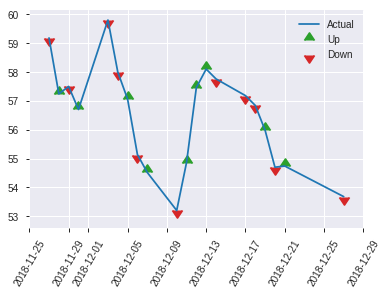


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20821177250105147
RMSE: 0.4563022819371513
LogLoss: 0.6075756561851278
Mean Per-Class Error: 0.30350805350805343
AUC: 0.7371689871689872
pr_auc: 0.6173884570986483
Gini: 0.4743379743379743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38854366540908813: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   71   0.4797   (71.0/148.0)
1      16   83   0.1616   (16.0/99.0)
Total  93   154  0.3522   (87.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388544     0.656126  153
max f2                       0.326693     0.78125   179
max f0point5                 0.556239     0.626424  84
max accuracy                 0.556239     0.700405  84
max precision                0.836526     0.8       4
max recall                   0.083617     1         244
max specificity              0.896388     0.993243  0
max absolute_mcc             0.512582     0.387856  108
max min_per_class_accuracy   0.502918     0.686869  111
max mean_per_class_accuracy  0.512582     0.696492  108

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.851755           1.6633    1.6633             0.666667         0.876295  0.666667                    0.876295            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.835864           2.49495   1.99596            1                0.83949   0.8                         0.861573            0.020202        0.040404                   149.495   99.596
    3        0.0323887                   0.827354           0.83165   1.55934            0.333333         0.832608  0.625                       0.850711            0.010101        0.0505051                  -16.835   55.9343
    4        0.0404858                   0.823167           1.24747   1.49697            0.5              0.824966  0.6                         0.845562            0.010101        0.0606061                  24.7475   49.697
    5        0.0526316                   0.819425           2.49495   1.72727            1                0.821337  0.692308                    0.839972            0.030303        0.0909091                  149.495   72.7273
    6        0.101215                    0.770999           1.87121   1.79636            0.75             0.805479  0.72                        0.823415            0.0909091       0.181818                   87.1212   79.6364
    7        0.149798                    0.720128           1.87121   1.82064            0.75             0.741947  0.72973                     0.796993            0.0909091       0.272727                   87.1212   82.0639
    8        0.202429                    0.666953           1.72727   1.79636            0.692308         0.695937  0.72                        0.770718            0.0909091       0.363636                   72.7273   79.6364
    9        0.299595                    0.603036           1.14352   1.58463            0.458333         0.637399  0.635135                    0.72748             0.111111        0.474747                   14.3519   58.463
    10       0.40081                     0.536061           1.49697   1.56249            0.6              0.557111  0.626263                    0.684457            0.151515        0.626263                   49.697    56.2494
    11       0.502024                    0.467622           0.898182  1.42856            0.36             0.506082  0.572581                    0.648494            0.0909091       0.717172                   -10.1818  42.856
    12       0.59919                     0.408024           0.83165   1.33176            0.333333         0.442214  0.533784                    0.615044            0.0808081       0.79798                    -16.835   33.1764
    13       0.700405                    0.341076           0.898182  1.26911            0.36             0.36959   0.508671                    0.579573            0.0909091       0.888889                   -10.1818  26.9107
    14       0.797571                    0.274968           0.311869  1.15249            0.125            0.310256  0.461929                    0.546763            0.030303        0.919192                   -68.8131  15.2489
    15       0.898785                    0.224083           0.399192  1.06766            0.16             0.250924  0.427928                    0.513448            0.040404        0.959596                   -60.0808  6.76586
    16       1                           0.060977           0.399192  1                  0.16             0.148455  0.40081                     0.476505            0.0

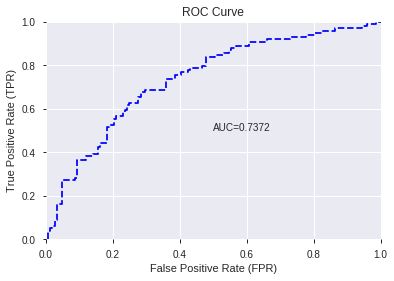

This function is available for GLM models only


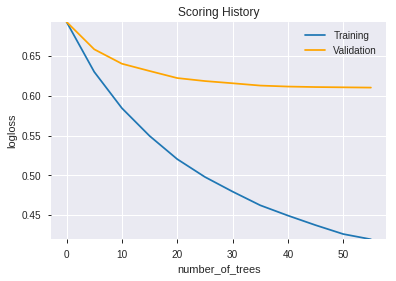

--2019-08-28 17:08:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170729_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170729_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_170840_model_8  0.715056  0.624679              0.337599  0.464499  0.215759
1  DeepLearning_grid_1_AutoML_20190828_170840_model_9  0.714169  0.626291              0.327327  0.464662  0.215911
2  DeepLearning_grid_1_AutoML_20190828_170840_model_6  0.711848  0.664226              0.303610  0.468460  0.219455
3  DeepLearning_grid_1_AutoML_20190828_170840_model_5  0.705296  0.645345              0.307194  0.471529  0.222340
4  DeepLearning_grid_1_AutoML_20190828_170840_model_7  0.696970  0.728363              0.398546  0.474959  0.225586
5               DeepLearning_1_AutoML_20190828_170840  0.684753  0.650899              0.337326  0.466720  0.217828
6  DeepLearning_grid_1_AutoML_20190828_170840_model_4  0.656156  0.803537              0.384828  0.506065  0.256101
7  DeepLearning_grid_1_AutoML_20190828_170840_model_3  0.655883  0.808419              0.396704  0.498796  0.248797
8  DeepLearning_grid_1_AutoML_20190828_170840_model_2  0.646669  0.879419              0.440793  0.512561  0.262719
9  DeepLearning_grid_1_AutoML_20190828_170840_model_1  0.642233  1.056798              0.420455  0.530866  0.281819

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.036180
1   CDLCLOSINGMARUBOZU             0.711643           0.711643    0.025747
2                  SUB             0.709949           0.709949    0.025686
3                  DIV             0.669021           0.669021    0.024205
4          CDLLONGLINE             0.640822           0.640822    0.023185
5         STOCHF_fastk             0.635226           0.635226    0.022982
6                  COS             0.592337           0.592337    0.021430
7             CORREL_8             0.591630           0.591630    0.021405
8                 DX_8             0.591156           0.591156    0.021388
9         aroondown_12             0.588530           0.588530    0.021293
10                 day             0.581601           0.581601    0.021042
11         CDLBELTHOLD             0.578907           0.578907    0.020945
12         CDLMARUBOZU             0.577953           0.577953    0.020910
13         HT_DCPERIOD             0.575260           0.575260    0.020813
14             WILLR_8             0.574736           0.574736    0.020794
15                 OBV             0.570541           0.570541    0.020642
16      STOCHRSI_fastk             0.566421           0.566421    0.020493
17        CDLENGULFING             0.561101           0.561101    0.020300
18             BETA_12             0.552471           0.552471    0.019988
19              TRANGE             0.550618           0.550618    0.019921
20              SAREXT             0.550444           0.550444    0.019915
21         STOCH_slowd             0.548452           0.548452    0.019843
22        CDLSHORTLINE             0.543534           0.543534    0.019665
23      STOCHRSI_fastd             0.536889           0.536889    0.019424
24        aroondown_14             0.532630           0.532630    0.019270
25         STOCH_slowk             0.532420           0.532420    0.019263
26   LINEARREG_ANGLE_8             0.531875           0.531875    0.019243
27                 SIN             0.528002           0.528002    0.019103
28   LINEARREG_SLOPE_8             0.526334           0.526334    0.019043
29            WILLR_20             0.526251           0.526251    0.019040
30             BETA_30             0.525067           0.525067    0.018997
31           CDLHAMMER             0.518605           0.518605    0.018763
32        HT_TRENDMODE             0.516971           0.516971    0.018704
33    CDLDRAGONFLYDOJI             0.513799           0.513799    0.018589
34             BETA_24             0.510551           0.510551    0.018471
35            WILLR_12             0.505300           0.505300    0.018282
36             BETA_20             0.505210           0.505210    0.018278
37            WILLR_14             0.504791           0.504791    0.018263
38               RSI_8             0.501533           0.501533    0.018145
39        STOCHF_fastd             0.501054           0.501054    0.018128
40              ULTOSC             0.497378           0.497378    0.017995
41               ADOSC             0.496738           0.496738    0.017972
42        weekday_name             0.493093           0.493093    0.017840
43           CORREL_30             0.490287           0.490287    0.017738
44       CDLHANGINGMAN             0.484416           0.484416    0.017526
45               CMO_8             0.483234           0.483234    0.017483
46         CDL3OUTSIDE             0.471450           0.471450    0.017057
47   CDLINVERTEDHAMMER             0.470516           0.470516    0.017023
48   CDLDARKCLOUDCOVER             0.443077           0.443077    0.016030
49        CDLTHRUSTING             0.430110           0.430110    0.015561

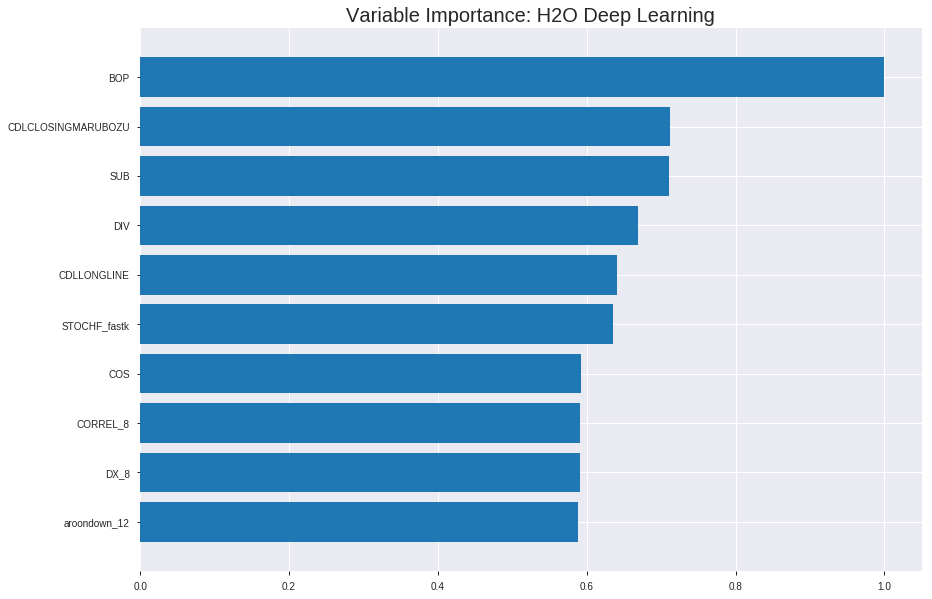

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_170840_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1925520062798396
RMSE: 0.43880748202354025
LogLoss: 0.5643999393201857
Mean Per-Class Error: 0.29377826008319774
AUC: 0.7818378515973018
pr_auc: 0.7762347439119412
Gini: 0.5636757031946036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4337069914472055: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  418   0.4889   (418.0/855.0)
1      113  760   0.1294   (113.0/873.0)
Total  550  1178  0.3073   (531.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433707     0.741102  234
max f2                       0.222705     0.859172  326
max f0point5                 0.512576     0.707835  182
max accuracy                 0.485017     0.706597  203
max precision                0.951181     1         0
max recall                   0.0942402    1         379
max specificity              0.951181     1         0
max absolute_mcc             0.455316     0.418075  223
max min_per_class_accuracy   0.489626     0.700585  198
max mean_per_class_accuracy  0.485017     0.706222  203

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 48.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.913434           1.97938   1.97938            1                0.926429  1                           0.926429            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.894222           1.86295   1.92283            0.941176         0.902827  0.971429                    0.914965            0.0183276       0.0389462                  86.2947   92.2828
    3        0.0300926                   0.873537           1.97938   1.94132            1                0.881507  0.980769                    0.904027            0.0194731       0.0584192                  97.9381   94.1316
    4        0.0405093                   0.839699           1.64948   1.86627            0.833333         0.859021  0.942857                    0.892454            0.0171821       0.0756014                  64.9485   86.6274
    5        0.0503472                   0.815949           1.86295   1.86562            0.941176         0.825903  0.942529                    0.87945             0.0183276       0.093929                   86.2947   86.5624
    6        0.100116                    0.746274           1.61112   1.73911            0.813953         0.776033  0.878613                    0.82804             0.0801833       0.174112                   61.1124   73.911
    7        0.150463                    0.689946           1.61536   1.6977             0.816092         0.716287  0.857692                    0.790646            0.0813288       0.255441                   61.5357   69.77
    8        0.200231                    0.6513             1.45001   1.63614            0.732558         0.672592  0.82659                     0.761303            0.0721649       0.327606                   45.0012   63.6136
    9        0.300347                    0.583215           1.45307   1.57511            0.734104         0.616549  0.795761                    0.713052            0.145475        0.473081                   45.3072   57.5115
    10       0.399884                    0.520065           1.16231   1.47236            0.587209         0.55051   0.743849                    0.672593            0.115693        0.588774                   16.2311   47.2362
    11       0.5                         0.48968            1.09839   1.39748            0.554913         0.50166   0.706019                    0.638367            0.109966        0.69874                    9.83851   39.748
    12       0.600116                    0.475855           0.98397   1.3285             0.49711          0.482959  0.671167                    0.61244             0.0985109       0.797251                   -1.603    32.8495
    13       0.699653                    0.4177             0.851594  1.26065            0.430233         0.450746  0.63689                     0.589437            0.0847652       0.882016                   -14.8406  26.0648
    14       0.799769                    0.308051           0.594959  1.17732            0.300578         0.365804  0.59479                     0.561442            0.0595647       0.941581                   -40.5041  17.7317
    15       0.899884                    0.187426           0.469102  1.09852            0.236994         0.2516    0.554984                    0.526971            0.0469645       0.988545                   -53.0898  9.85249
    16       1                           0.0127605          0.114415  1                  0.0578035        0.122672  0.505208                    0.486494            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20732073928803055
RMSE: 0.4553248722484096
LogLoss: 0.6005403849430806
Mean Per-Class Error: 0.32985295325720854
AUC: 0.7331553437936417
pr_auc: 0.740841367503647
Gini: 0.46631068758728333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4234137087157476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   155  0.6596   (155.0/235.0)
1      20   239  0.0772   (20.0/259.0)
Total  100  394  0.3543   (175.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423414     0.732006  306
max f2                       0.234638     0.857334  366
max f0point5                 0.624885     0.68836   118
max accuracy                 0.506245     0.67004   210
max precision                0.941399     1         0
max recall                   0.107728     1         390
max specificity              0.941399     1         0
max absolute_mcc             0.624885     0.356733  118
max min_per_class_accuracy   0.506245     0.667954  210
max mean_per_class_accuracy  0.506245     0.670147  210

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 52.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.895346           1.52587   1.52587            0.8              0.923195  0.8                         0.923195            0.015444        0.015444                   52.5869   52.5869
    2        0.0202429                   0.871439           1.52587   1.52587            0.8              0.889801  0.8                         0.906498            0.015444        0.030888                   52.5869   52.5869
    3        0.0303644                   0.841757           1.90734   1.65302            1                0.853314  0.866667                    0.88877             0.019305        0.0501931                  90.7336   65.3024
    4        0.0404858                   0.825758           1.90734   1.7166             1                0.83443   0.9                         0.875185            0.019305        0.0694981                  90.7336   71.6602
    5        0.0506073                   0.818594           1.52587   1.67846            0.8              0.822582  0.88                        0.864664            0.015444        0.0849421                  52.5869   67.8456
    6        0.101215                    0.764372           1.60216   1.64031            0.84             0.793945  0.86                        0.829305            0.0810811       0.166023                   60.2162   64.0309
    7        0.149798                    0.721771           1.66892   1.64959            0.875            0.74      0.864865                    0.800341            0.0810811       0.247104                   66.8919   64.9588
    8        0.200405                    0.681224           1.44958   1.59908            0.76             0.700243  0.838384                    0.775064            0.0733591       0.320463                   44.9575   59.908
    9        0.299595                    0.608333           1.32346   1.50783            0.693878         0.641792  0.790541                    0.73094             0.131274        0.451737                   32.3458   50.7826
    10       0.40081                     0.546191           0.953668  1.36789            0.5              0.573003  0.717172                    0.691057            0.0965251       0.548263                   -4.6332   36.7887
    11       0.5                         0.509274           1.08991   1.31274            0.571429         0.527317  0.688259                    0.658574            0.108108        0.656371                   8.99062   31.2741
    12       0.59919                     0.485274           0.856355  1.23719            0.44898          0.495358  0.648649                    0.631555            0.0849421       0.741313                   -14.3645  23.7191
    13       0.700405                    0.472828           0.915521  1.19071            0.48             0.479713  0.624277                    0.609613            0.0926641       0.833977                   -8.44788  19.0707
    14       0.799595                    0.420471           0.89528   1.15406            0.469388         0.449008  0.605063                    0.58969             0.0888031       0.92278                    -10.472   15.4059
    15       0.898785                    0.256696           0.506028  1.08254            0.265306         0.345655  0.567568                    0.562758            0.0501931       0.972973                   -49.3972  8.2542
    16       1                           0.0388845          0.267027  1                  0.14             0.171341  0.524291                    0.523141           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:14:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:14:22  1 min 14.809 sec  645 obs/sec       0.517361  1             894        0.49821          0.770984            0.00704062     0.724682        0.71648            1.86942          0.373264                         0.518092           0.820753              -0.0762168       0.698538          0.716965             1.52587            0.392713
    2019-08-28 17:14:33  1 min 25.604 sec  986 obs/sec       6.386     12            11035      0.438807         0.5644              0.229708       0.781838        0.776235           1.97938          0.307292                         0.455325           0.60054               0.168755         0.733155          0.740841             1.52587            0.354251
    2019-08-28 17:14:44  1 min 36.096 sec  1108 obs/sec      13.2749   25            22939      0.43329          0.548414            0.248957       0.793626        0.789215           1.97938          0.306713                         0.457704           0.605578              0.160045         0.738791          0.747582             1.52587            0.346154
    2019-08-28 17:14:54  1 min 46.143 sec  1203 obs/sec      20.7211   39            35806      0.423724         0.525214            0.281755       0.804875        0.799548           1.86942          0.288194                         0.461325           0.6168                0.146701         0.725376          0.739378             1.90734            0.398785
    2019-08-28 17:15:04  1 min 56.446 sec  1268 obs/sec      28.6869   54            49571      0.411327         0.498592            0.323168       0.829885        0.824311           1.97938          0.292824                         0.461515           0.621555              0.146001         0.731915          0.746586             1.52587            0.362348
    2019-08-28 17:15:14  2 min  6.468 sec  1314 obs/sec      36.6157   69            63272      0.407726         0.489965            0.334965       0.838187        0.825591           1.97938          0.272569                         0.462747           0.628408              0.141436         0.718845          0.734554             1.52587            0.380567
    2019-08-28 17:15:24  2 min 16.407 sec  1347 obs/sec      44.5278   84            76944      0.388309         0.444197            0.396798       0.861295        0.841966           1.97938          0.255787                         0.4658             0.64749               0.130067         0.725031          0.736853             1.52587            0.402834
    2019-08-28 17:15:25  2 min 17.420 sec  1346 obs/sec      44.5278   84            76944      0.438807         0.5644              0.229708       0.781838        0.776235           1.97938          0.307292                         0.455325           0.60054               0.168755         0.733155          0.740841             1.52587            0.354251

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03617953965786962
CDLCLOSINGMARUBOZU  0.711643397808075      0.711643397808075    0.025746930533258328
SUB                 0.7099485397338867     0.7099485397338867   0.025685611348348774
DIV                 0.6690205931663513     0.6690205931663513   0.02420485708239346
CDLLONGLINE         0.6408215165138245     0.6408215165138245   0.02318462747032806
---                 ---                    ---                  ---
CMO_8               0.4832339286804199     0.4832339286804199   0.017483181086721387
CDL3OUTSIDE         0.47145017981529236    0.47145017981529236  0.01705685047733713
CDLINVERTEDHAMMER   0.470515638589859      0.470515638589859    0.01702303920600965
CDLDARKCLOUDCOVER   0.4430769979953766     0.4430769979953766   0.01603032182046354
CDLTHRUSTING        0.43010973930358887    0.43010973930358887  0.015561172370370155


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.708502024291498)

('F1', 0.6463878326996199)

('auc', 0.715055965055965)

('logloss', 0.6246789175959887)

('mean_per_class_error', 0.31514469014469015)

('rmse', 0.4644985305352485)

('mse', 0.21575888486940517)

deeplearning prediction progress: |███████████████████████████████████████| 100%


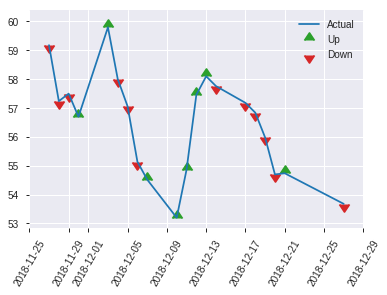


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21575888486940517
RMSE: 0.4644985305352485
LogLoss: 0.6246789175959887
Mean Per-Class Error: 0.31514469014469015
AUC: 0.715055965055965
pr_auc: 0.597538534411104
Gini: 0.43011193011193005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4070298603665711: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   79   0.5338   (79.0/148.0)
1      14   85   0.1414   (14.0/99.0)
Total  83   164  0.3765   (93.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40703      0.646388  163
max f2                       0.153499     0.777778  233
max f0point5                 0.520862     0.637813  84
max accuracy                 0.520862     0.708502  84
max precision                0.853582     0.75      3
max recall                   0.0730811    1         243
max specificity              0.896373     0.993243  0
max absolute_mcc             0.520862     0.381367  84
max min_per_class_accuracy   0.487411     0.666667  114
max mean_per_class_accuracy  0.520862     0.684855  84

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 45.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.867209           1.6633    1.6633             0.666667         0.890438  0.666667                    0.890438            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.821424           1.24747   1.49697            0.5              0.838676  0.6                         0.869733            0.010101        0.030303                   24.7475   49.697
    3        0.0323887                   0.804251           1.6633    1.55934            0.666667         0.815473  0.625                       0.849386            0.020202        0.0505051                  66.33     55.9343
    4        0.0404858                   0.770172           1.24747   1.49697            0.5              0.78999   0.6                         0.837507            0.010101        0.0606061                  24.7475   49.697
    5        0.0526316                   0.759319           2.49495   1.72727            1                0.765152  0.692308                    0.820809            0.030303        0.0909091                  149.495   72.7273
    6        0.101215                    0.673868           1.6633    1.69657            0.666667         0.717299  0.68                        0.771124            0.0808081       0.171717                   66.33     69.6566
    7        0.149798                    0.621811           1.87121   1.75321            0.75             0.646789  0.702703                    0.730799            0.0909091       0.262626                   87.1212   75.3208
    8        0.202429                    0.588618           1.72727   1.74646            0.692308         0.601182  0.7                         0.697099            0.0909091       0.353535                   72.7273   74.6465
    9        0.299595                    0.531787           1.45539   1.65206            0.583333         0.556611  0.662162                    0.651535            0.141414        0.494949                   45.5387   65.2061
    10       0.40081                     0.503146           1.09778   1.51209            0.44             0.517924  0.606061                    0.617795            0.111111        0.606061                   9.77778   51.2091
    11       0.502024                    0.480724           0.898182  1.38832            0.36             0.490413  0.556452                    0.592113            0.0909091       0.69697                    -10.1818  38.8319
    12       0.59919                     0.453513           0.519781  1.24747            0.208333         0.469923  0.5                         0.572299            0.0505051       0.747475                   -48.0219  24.7475
    13       0.700405                    0.375394           1.29737   1.25469            0.52             0.413286  0.50289                     0.54932             0.131313        0.878788                   29.7374   25.4686
    14       0.797571                    0.300611           0.103956  1.1145             0.0416667        0.33929   0.446701                    0.523732            0.010101        0.888889                   -89.6044  11.4495
    15       0.898785                    0.210542           0.49899   1.04518            0.2              0.25982   0.418919                    0.494013            0.0505051       0.939394                   -50.101   4.51815
    16       1                           0.0261774          0.598788  1                  0.24             0.13685   0.40081                     0.457863            0

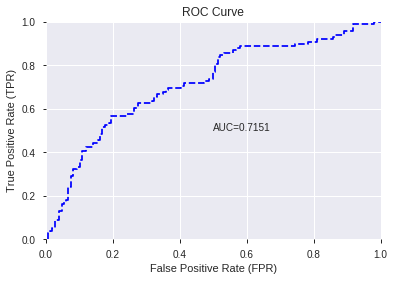

This function is available for GLM models only


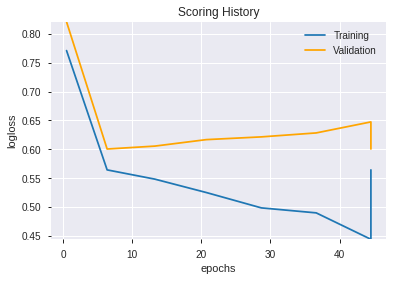

--2019-08-28 17:16:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_170840_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_170840_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'DIV',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'COS',
 'CORREL_8',
 'DX_8',
 'aroondown_12',
 'day',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'HT_DCPERIOD',
 'WILLR_8',
 'OBV',
 'STOCHRSI_fastk',
 'CDLENGULFING',
 'BETA_12',
 'TRANGE',
 'SAREXT',
 'STOCH_slowd',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'aroondown_14',
 'STOCH_slowk',
 'LINEARREG_ANGLE_8',
 'SIN',
 'LINEARREG_SLOPE_8',
 'WILLR_20',
 'BETA_30',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'BETA_24',
 'WILLR_12',
 'BETA_20',
 'WILLR_14',
 'RSI_8',
 'STOCHF_fastd',
 'ULTOSC',
 'ADOSC',
 'weekday_name',
 'CORREL_30',
 'CDLHANGINGMAN',
 'CMO_8',
 'CDL3OUTSIDE',
 'CDLINVERTEDHAMMER',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_171653_model_1  0.713896  0.622686              0.325689  0.464015  0.21531

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.489964           1.000000    0.116992
1                  SUB             0.269058           0.549138    0.064245
2         STOCHF_fastk             0.251026           0.512335    0.059939
3              WILLR_8             0.216935           0.442758    0.051799
4          HT_DCPERIOD             0.153145           0.312563    0.036567
5       STOCHRSI_fastd             0.151131           0.308453    0.036086
6         CDLENGULFING             0.146935           0.299890    0.035085
7             WILLR_12             0.138004           0.281662    0.032952
8    LINEARREG_ANGLE_8             0.117968           0.240768    0.028168
9          STOCH_slowk             0.110764           0.226065    0.026448
10        STOCHF_fastd             0.109328           0.223134    0.026105
11           CDLHAMMER             0.108814           0.222085    0.025982
12         CDLLONGLINE             0.104998           0.214298    0.025071
13        aroondown_12             0.104713           0.213715    0.025003
14                 OBV             0.102489           0.209177    0.024472
15   CDLINVERTEDHAMMER             0.101782           0.207733    0.024303
16                DX_8             0.096831           0.197628    0.023121
17        aroondown_14             0.093449           0.190726    0.022313
18               ADOSC             0.092934           0.189675    0.022190
19   LINEARREG_SLOPE_8             0.089269           0.182195    0.021315
20                 DIV             0.081252           0.165833    0.019401
21             BETA_24             0.078051           0.159300    0.018637
22         CDLMARUBOZU             0.077191           0.157545    0.018431
23              ULTOSC             0.074148           0.151334    0.017705
24  CDLCLOSINGMARUBOZU             0.071767           0.146474    0.017136
25           CORREL_30             0.066443           0.135608    0.015865
26         STOCH_slowd             0.063082           0.128747    0.015062
27       CDLHANGINGMAN             0.061008           0.124515    0.014567
28                 COS             0.059632           0.121708    0.014239
29              SAREXT             0.053922           0.110053    0.012875
30            WILLR_14             0.052087           0.106307    0.012437
31              TRANGE             0.048917           0.099838    0.011680
32      STOCHRSI_fastk             0.048844           0.099690    0.011663
33        CDLTHRUSTING             0.047281           0.096499    0.011290
34             BETA_20             0.035221           0.071885    0.008410
35        weekday_name             0.033242           0.067847    0.007938
36        HT_TRENDMODE             0.031116           0.063507    0.007430
37    CDLDRAGONFLYDOJI             0.022879           0.046694    0.005463
38   CDLDARKCLOUDCOVER             0.018321           0.037393    0.004375
39         CDL3OUTSIDE             0.014350           0.029288    0.003426
40               RSI_8             0.013738           0.028038    0.003280
41               CMO_8             0.013365           0.027278    0.003191
42         CDLBELTHOLD             0.012649           0.025816    0.003020
43             BETA_30             0.011390           0.023247    0.002720
44            WILLR_20             0.010196           0.020810    0.002435
45            CORREL_8             0.009751           0.019901    0.002328
46             BETA_12             0.009656           0.019707    0.002306
47        CDLSHORTLINE             0.008433           0.017212    0.002014
48                 SIN             0.006633           0.013537    0.001584
49                 day             0.003919           0.007998    0.000936

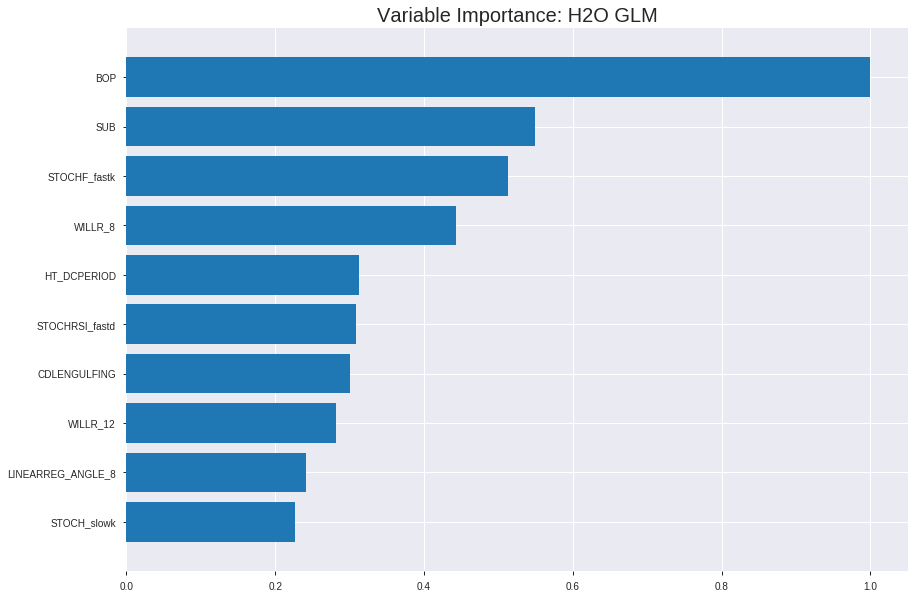

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_171653_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19137039971386832
RMSE: 0.4374590263257444
LogLoss: 0.5633902973798087
Null degrees of freedom: 1727
Residual degrees of freedom: 1677
Null deviance: 2395.329152624184
Residual deviance: 1947.0768677446188
AIC: 2049.0768677446185
AUC: 0.7794832633320606
pr_auc: 0.767975988758032
Gini: 0.5589665266641213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3677819637083653: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      420  435   0.5088   (435.0/855.0)
1      100  773   0.1145   (100.0/873.0)
Total  520  1208  0.3096   (535.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367782     0.742912  262
max f2                       0.242944     0.854103  319
max f0point5                 0.520785     0.717406  190
max accuracy                 0.518061     0.714699  191
max precision                0.970031     1         0
max recall                   0.0648796    1         390
max specificity              0.970031     1         0
max absolute_mcc             0.518061     0.429318  191
max min_per_class_accuracy   0.520785     0.71345   190
max mean_per_class_accuracy  0.518061     0.71465   191

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.920977           1.86942   1.86942            0.944444         0.940941  0.944444                    0.940941            0.0194731       0.0194731                  86.9416   86.9416
    2        0.0202546                   0.888949           1.86295   1.86627            0.941176         0.904167  0.942857                    0.92308             0.0183276       0.0378007                  86.2947   86.6274
    3        0.0300926                   0.875231           1.63008   1.78906            0.823529         0.881171  0.903846                    0.909379            0.0160367       0.0538373                  63.0079   78.9056
    4        0.0405093                   0.863735           1.75945   1.78144            0.888889         0.869613  0.9                         0.899153            0.0183276       0.0721649                  75.945    78.1443
    5        0.0503472                   0.845678           1.97938   1.82012            1                0.855029  0.91954                     0.890531            0.0194731       0.091638                   97.9381   82.0121
    6        0.100116                    0.794562           1.56509   1.69334            0.790698         0.819011  0.855491                    0.854978            0.0778923       0.16953                    56.5092   69.3344
    7        0.150463                    0.756602           1.72911   1.70531            0.873563         0.775128  0.861538                    0.828259            0.0870561       0.256586                   72.9115   70.5313
    8        0.200231                    0.728072           1.47303   1.64758            0.744186         0.741612  0.83237                     0.806722            0.0733104       0.329897                   47.3028   64.7578
    9        0.300347                    0.659436           1.3501    1.54842            0.682081         0.693893  0.782274                    0.769113            0.135166        0.465063                   35.0098   54.8418
    10       0.399884                    0.582728           1.20834   1.46377            0.610465         0.621597  0.739508                    0.732394            0.120275        0.585338                   20.8343   46.3768
    11       0.5                         0.521997           1.25857   1.42268            0.635838         0.550995  0.71875                     0.696072            0.126002        0.71134                    25.8566   42.268
    12       0.600116                    0.449066           0.880996  1.33231            0.445087         0.486195  0.673095                    0.661059            0.0882016       0.799542                   -11.9004  33.2313
    13       0.699653                    0.366415           0.863102  1.26556            0.436047         0.408142  0.639371                    0.625077            0.0859107       0.885452                   -13.6898  26.556
    14       0.799769                    0.274684           0.491985  1.16872            0.248555         0.320723  0.590449                    0.586978            0.0492554       0.934708                   -50.8015  16.8723
    15       0.899884                    0.187061           0.491985  1.09343            0.248555         0.230909  0.552412                    0.547364            0.0492554       0.983963                   -50.8015  9.34332
    16       1                           0.00613412         0.160181  1                  0.0809249        0.126296  0.505208                    0.505208           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20830529395496944
RMSE: 0.45640474795401664
LogLoss: 0.6016731358573415
Null degrees of freedom: 493
Residual degrees of freedom: 443
Null deviance: 684.3830016464425
Residual deviance: 594.4530582270534
AIC: 696.4530582270534
AUC: 0.7330239053643308
pr_auc: 0.7380980685368195
Gini: 0.46604781072866164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3421541038922908: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   154  0.6553   (154.0/235.0)
1      18   241  0.0695   (18.0/259.0)
Total  99   395  0.3482   (172.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342154     0.737003  310
max f2                       0.253142     0.858792  346
max f0point5                 0.621912     0.68903   165
max accuracy                 0.459398     0.665992  259
max precision                0.963377     1         0
max recall                   0.102175     1         392
max specificity              0.963377     1         0
max absolute_mcc             0.342154     0.343312  310
max min_per_class_accuracy   0.568939     0.65251   192
max mean_per_class_accuracy  0.621912     0.667904  165

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.907611           1.90734   1.90734            1                0.933242  1                           0.933242            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.893976           1.52587   1.7166             0.8              0.90365   0.9                         0.918446            0.015444        0.034749                   52.5869   71.6602
    3        0.0303644                   0.882189           1.90734   1.78018            1                0.889926  0.933333                    0.90894             0.019305        0.0540541                  90.7336   78.018
    4        0.0404858                   0.872815           1.52587   1.7166             0.8              0.878252  0.9                         0.901268            0.015444        0.0694981                  52.5869   71.6602
    5        0.0506073                   0.862545           1.52587   1.67846            0.8              0.868757  0.88                        0.894766            0.015444        0.0849421                  52.5869   67.8456
    6        0.101215                    0.824797           1.52587   1.60216            0.8              0.844773  0.84                        0.869769            0.0772201       0.162162                   52.5869   60.2162
    7        0.149798                    0.792648           1.50997   1.57226            0.791667         0.809271  0.824324                    0.850148            0.0733591       0.235521                   50.9974   57.2263
    8        0.200405                    0.763947           1.60216   1.57981            0.84             0.77725   0.828283                    0.831739            0.0810811       0.316602                   60.2162   57.9814
    9        0.299595                    0.699126           1.16776   1.44339            0.612245         0.730067  0.756757                    0.798078            0.11583         0.432432                   16.7757   44.3389
    10       0.40081                     0.63705            1.18255   1.37752            0.62             0.671205  0.722222                    0.766039            0.119691        0.552124                   18.2548   37.752
    11       0.5                         0.568545           1.01206   1.30502            0.530612         0.605475  0.684211                    0.734186            0.100386        0.65251                    1.20558   30.5019
    12       0.59919                     0.50748            0.856355  1.23075            0.44898          0.535912  0.64527                     0.701364            0.0849421       0.737452                   -14.3645  23.0747
    13       0.700405                    0.434375           1.06811   1.20724            0.56             0.474443  0.632948                    0.668572            0.108108        0.84556                    6.81081   20.7244
    14       0.799595                    0.340805           0.856355  1.16372            0.44898          0.388061  0.610127                    0.633774            0.0849421       0.930502                   -14.3645  16.3716
    15       0.898785                    0.228553           0.467103  1.08684            0.244898         0.290064  0.56982                     0.595842            0.046332        0.976834                   -53.2897  8.68378
    16       1                           0.0471793          0.22888   1                  0.12             0.159426  0.524291                    0.551671           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:16:54  0.000 sec   2            21        51            1.36655           1.36876
    2019-08-28 17:16:54  0.025 sec   4            13        51            1.35666           1.36044
    2019-08-28 17:16:54  0.039 sec   6            8.1       51            1.34307           1.34909
    2019-08-28 17:16:54  0.052 sec   8            5         51            1.32529           1.33439
    2019-08-28 17:16:54  0.065 sec   10           3.1       51            1.30333           1.31646
    2019-08-28 17:16:54  0.078 sec   12           1.9       51            1.27783           1.29602
    2019-08-28 17:16:54  0.091 sec   14           1.2       51            1.25029           1.27454
    2019-08-28 17:16:54  0.104 sec   16           0.75      51            1.22283           1.25399
    2019-08-28 17:16:54  0.118 sec   18           0.47      51            1.19773           1.23639
    2019-08-28 17:16:54  0.131 sec   20           0.29      51            1.17661           1.223
    2019-08-28 17:16:54  0.144 sec   22           0.18      51            1.15999           1.21394
    2019-08-28 17:16:54  0.158 sec   24           0.11      51            1.14754           1.20845
    2019-08-28 17:16:54  0.174 sec   26           0.069     51            1.13841           1.20542
    2019-08-28 17:16:54  0.187 sec   28           0.043     51            1.13174           1.20393
    2019-08-28 17:16:54  0.201 sec   30           0.027     51            1.12678           1.20335
    2019-08-28 17:16:54  0.214 sec   32           0.017     51            1.12303           1.20335
    2019-08-28 17:16:54  0.230 sec   34           0.01      51            1.12018           1.20373
    2019-08-28 17:16:54  0.248 sec   36           0.0064    51            1.11803           1.20446
    2019-08-28 17:16:54  0.263 sec   38           0.004     51            1.11651           1.20538
    2019-08-28 17:16:54  0.277 sec   40           0.0025    51            1.1155            1.20637

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882591093117408)

('F1', 0.6477732793522267)

('auc', 0.7138957138957139)

('logloss', 0.6226861471155015)

('mean_per_class_error', 0.3186936936936937)

('rmse', 0.464015396780549)

('mse', 0.2153102884494103)

glm prediction progress: |████████████████████████████████████████████████| 100%


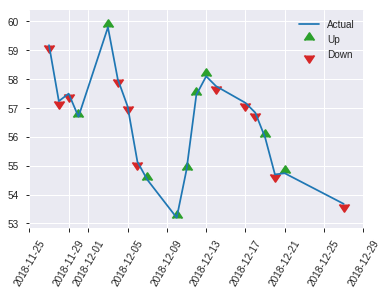


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2153102884494103
RMSE: 0.464015396780549
LogLoss: 0.6226861471155015
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.4623801242943
Residual deviance: 307.60695667505775
AIC: 409.60695667505775
AUC: 0.7138957138957139
pr_auc: 0.5810539969677128
Gini: 0.42779142779142787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4036700461731363: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   68   0.4595   (68.0/148.0)
1      19   80   0.1919   (19.0/99.0)
Total  99   148  0.3522   (87.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40367      0.647773  147
max f2                       0.229651     0.777414  214
max f0point5                 0.57289      0.610278  91
max accuracy                 0.57289      0.688259  91
max precision                0.800222     0.75      11
max recall                   0.088177     1         242
max specificity              0.896877     0.993243  0
max absolute_mcc             0.522269     0.35724   110
max min_per_class_accuracy   0.516025     0.676768  113
max mean_per_class_accuracy  0.522269     0.681306  110

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.866631           0.83165   0.83165            0.333333         0.887434  0.333333                    0.887434            0.010101        0.010101                   -16.835   -16.835
    2        0.0202429                   0.857598           1.24747   0.99798            0.5              0.86119   0.4                         0.876936            0.010101        0.020202                   24.7475   -0.20202
    3        0.0323887                   0.824801           2.49495   1.55934            1                0.839795  0.625                       0.863008            0.030303        0.0505051                  149.495   55.9343
    4        0.0404858                   0.808947           2.49495   1.74646            1                0.816764  0.7                         0.853759            0.020202        0.0707071                  149.495   74.6465
    5        0.0526316                   0.792928           1.6633    1.72727            0.666667         0.800224  0.692308                    0.841405            0.020202        0.0909091                  66.33     72.7273
    6        0.101215                    0.748276           1.6633    1.69657            0.666667         0.772391  0.68                        0.808278            0.0808081       0.171717                   66.33     69.6566
    7        0.149798                    0.71341            1.45539   1.61835            0.583333         0.728656  0.648649                    0.782455            0.0707071       0.242424                   45.5387   61.8346
    8        0.202429                    0.677991           1.91919   1.69657            0.769231         0.69914   0.68                        0.760793            0.10101         0.343434                   91.9192   69.6566
    9        0.299595                    0.617865           1.14352   1.5172             0.458333         0.646516  0.608108                    0.72373             0.111111        0.454545                   14.3519   51.7199
    10       0.40081                     0.553442           1.39717   1.48689            0.56             0.582449  0.59596                     0.688053            0.141414        0.59596                    39.7172   48.6889
    11       0.502024                    0.465946           0.99798   1.38832            0.4              0.519857  0.556452                    0.654143            0.10101         0.69697                    -0.20202  38.8319
    12       0.59919                     0.393472           1.14352   1.34862            0.458333         0.428948  0.540541                    0.617625            0.111111        0.808081                   14.3519   34.8621
    13       0.700405                    0.33024            0.598788  1.24026            0.24             0.363534  0.49711                     0.580906            0.0606061       0.868687                   -40.1212  24.0264
    14       0.797571                    0.277802           0.311869  1.12716            0.125            0.300635  0.451777                    0.546762            0.030303        0.89899                    -68.8131  12.716
    15       0.898785                    0.207361           0.598788  1.06766            0.24             0.24807   0.427928                    0.513125            0.0606061       0.959596                   -40.1212  6.76586
    16       1                           0.0330996          0.399192  1                  0.16             0.13867   0.40081                     0.475225         

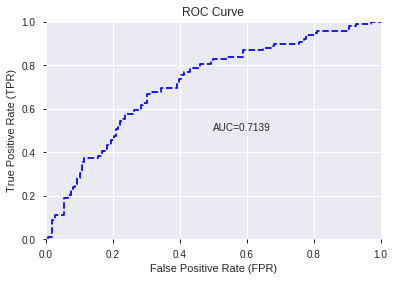

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


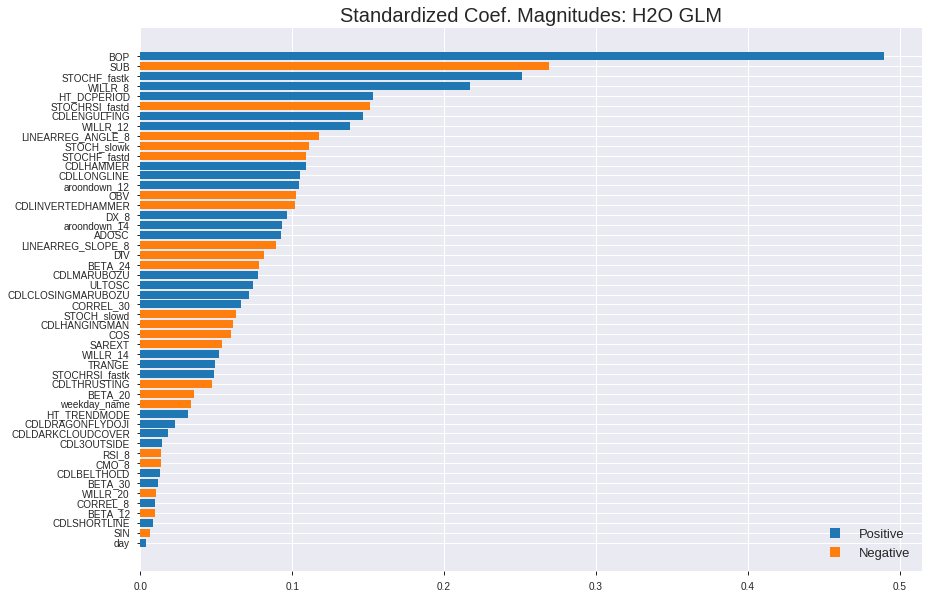

'log_likelihood'
--2019-08-28 17:16:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_171653_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_171653_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLHAMMER',
 'CDLLONGLINE',
 'aroondown_12',
 'OBV',
 'CDLINVERTEDHAMMER',
 'DX_8',
 'aroondown_14',
 'ADOSC',
 'LINEARREG_SLOPE_8',
 'DIV',
 'BETA_24',
 'CDLMARUBOZU',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CORREL_30',
 'STOCH_slowd',
 'CDLHANGINGMAN',
 'COS',
 'SAREXT',
 'WILLR_14',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLTHRUSTING',
 'BETA_20',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLDARKCLOUDCOVER',
 'CDL3OUTSIDE',
 'RSI_8',
 'CMO_8',
 'CDLBELTHOLD',
 'BETA_30',
 'WILLR_20',
 'CORREL_8',
 'BETA_12',
 'CDLSHORTLINE',
 'SIN',
 'day']

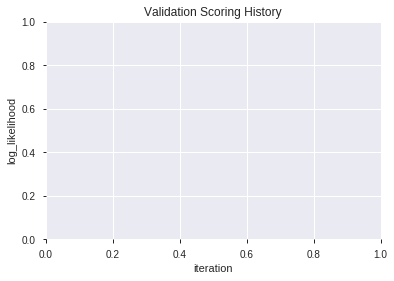

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_171705_model_5  0.727068  0.620138              0.340875  0.460345  0.211917
1  XGBoost_grid_1_AutoML_20190828_171705_model_4  0.725293  0.607271              0.330808  0.457433  0.209245
2  XGBoost_grid_1_AutoML_20190828_171705_model_1  0.721608  0.617433              0.320536  0.461671  0.213140
3  XGBoost_grid_1_AutoML_20190828_171705_model_2  0.719902  0.614024              0.312108  0.460381  0.211951
4  XGBoost_grid_1_AutoML_20190828_171705_model_6  0.717786  0.619514              0.330740  0.462949  0.214322
5               XGBoost_3_AutoML_20190828_171705  0.716626  0.620683              0.340943  0.463611  0.214935
6  XGBoost_grid_1_AutoML_20190828_171705_model_3  0.705842  0.628104              0.378208  0.466457  0.217582
7               XGBoost_2_AutoML_20190828_171705  0.699563  0.633203              0.357835  0.469949  0.220852
8               XGBoost_1_AutoML_20190828_171705  0.691578  0.642446              0.345994  0.473109  0.223832
9  XGBoost_grid_1_AutoML_20190828_171705_model_7  0.686664  0.642341              0.342513  0.473921  0.224601

variable  relative_importance  scaled_importance  percentage
0                  BOP          2772.047119           1.000000    0.117377
1                  DIV           918.845642           0.331468    0.038907
2          HT_DCPERIOD           844.543701           0.304664    0.035761
3               SAREXT           843.541504           0.304303    0.035718
4                 DX_8           827.831055           0.298635    0.035053
5                  day           803.422607           0.289830    0.034019
6                  COS           773.655823           0.279092    0.032759
7             CORREL_8           747.532410           0.269668    0.031653
8                  SUB           746.612732           0.269336    0.031614
9                  SIN           734.519104           0.264974    0.031102
10        STOCHF_fastk           717.069214           0.258679    0.030363
11              TRANGE           693.285583           0.250099    0.029356
12         STOCH_slowd           677.814941           0.244518    0.028701
13             WILLR_8           667.329895           0.240735    0.028257
14               CMO_8           655.660645           0.236526    0.027763
15              ULTOSC           636.714661           0.229691    0.026961
16            WILLR_12           609.217224           0.219772    0.025796
17                 OBV           606.570435           0.218817    0.025684
18             BETA_30           572.853821           0.206654    0.024256
19             BETA_12           566.633728           0.204410    0.023993
20         STOCH_slowk           537.050049           0.193738    0.022740
21      STOCHRSI_fastk           513.356934           0.185191    0.021737
22             BETA_24           511.202301           0.184413    0.021646
23           CORREL_30           502.462555           0.181260    0.021276
24               ADOSC           494.950104           0.178550    0.020958
25            WILLR_20           477.562805           0.172278    0.020222
26             BETA_20           472.981445           0.170625    0.020028
27   LINEARREG_ANGLE_8           469.644440           0.169422    0.019886
28      STOCHRSI_fastd           456.963654           0.164847    0.019349
29        weekday_name           415.453766           0.149873    0.017592
30            WILLR_14           404.323334           0.145857    0.017120
31        aroondown_12           329.956390           0.119030    0.013971
32        aroondown_14           327.302521           0.118072    0.013859
33               RSI_8           290.776276           0.104896    0.012312
34   LINEARREG_SLOPE_8           241.855728           0.087248    0.010241
35        STOCHF_fastd           213.405518           0.076985    0.009036
36         CDLLONGLINE            89.094673           0.032140    0.003773
37         CDLBELTHOLD            76.542107           0.027612    0.003241
38  CDLCLOSINGMARUBOZU            69.468346           0.025060    0.002942
39        CDLSHORTLINE            62.469025           0.022535    0.002645
40        CDLENGULFING            61.108746           0.022045    0.002588
41           CDLHAMMER            60.468987           0.021814    0.002560
42        HT_TRENDMODE            34.186840           0.012333    0.001448
43         CDL3OUTSIDE            29.518831           0.010649    0.001250
44   CDLINVERTEDHAMMER            15.743896           0.005680    0.000667
45       CDLHANGINGMAN            14.376320           0.005186    0.000609
46    CDLDRAGONFLYDOJI            12.971012           0.004679    0.000549
47         CDLMARUBOZU             7.611218           0.002746    0.000322
48   CDLDARKCLOUDCOVER             4.992580           0.001801    0.000211
49        CDLTHRUSTING             3.054596           0.001102    0.000129

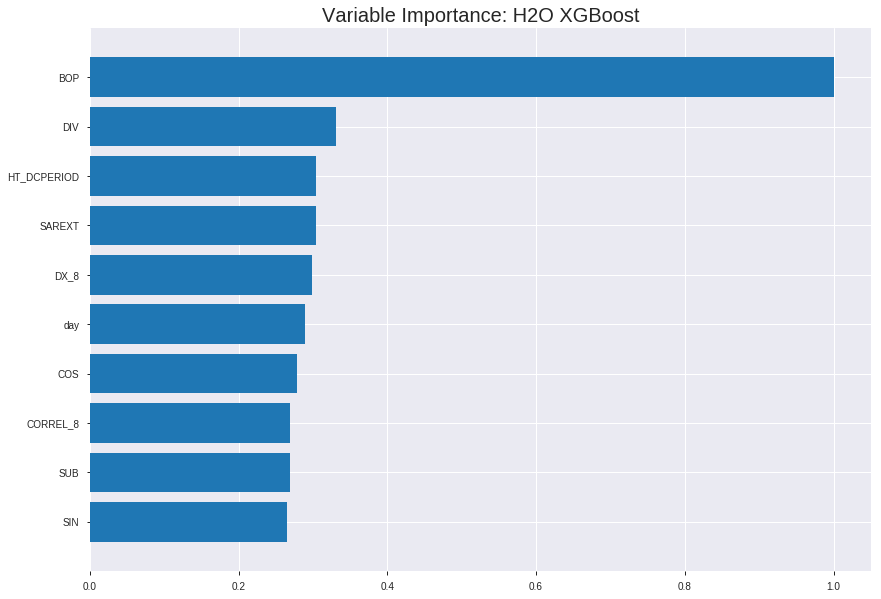

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_171705_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.033098270190694834
RMSE: 0.18192929997857638
LogLoss: 0.18312127041305945
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988545246277205
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.537236213684082: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      855  0    0        (0.0/855.0)
1      0    873  0        (0.0/873.0)
Total  855  873  0        (0.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.537236     1        198
max f2                       0.537236     1        198
max f0point5                 0.537236     1        198
max accuracy                 0.537236     1        198
max precision                0.953384     1        0
max recall                   0.537236     1        198
max specificity              0.953384     1        0
max absolute_mcc             0.537236     1        198
max min_per_class_accuracy   0.537236     1        198
max mean_per_class_accuracy  0.537236     1        198

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.936586           1.97938   1.97938            1                0.943432   1                           0.943432            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.931816           1.97938   1.97938            1                0.933903   1                           0.938804            0.0194731       0.0400916                  97.9381   97.9381
    3        0.0300926                   0.927238           1.97938   1.97938            1                0.929821   1                           0.935867            0.0194731       0.0595647                  97.9381   97.9381
    4        0.0405093                   0.921481           1.97938   1.97938            1                0.923978   1                           0.93281             0.0206186       0.0801833                  97.9381   97.9381
    5        0.0503472                   0.916808           1.97938   1.97938            1                0.919079   1                           0.930127            0.0194731       0.0996564                  97.9381   97.9381
    6        0.100116                    0.901357           1.97938   1.97938            1                0.909252   1                           0.91975             0.0985109       0.198167                   97.9381   97.9381
    7        0.150463                    0.887382           1.97938   1.97938            1                0.893962   1                           0.911121            0.0996564       0.297824                   97.9381   97.9381
    8        0.200231                    0.870913           1.97938   1.97938            1                0.87875    1                           0.903075            0.0985109       0.396334                   97.9381   97.9381
    9        0.300347                    0.836196           1.97938   1.97938            1                0.854109   1                           0.886753            0.198167        0.594502                   97.9381   97.9381
    10       0.399884                    0.779312           1.97938   1.97938            1                0.810819   1                           0.867852            0.197022        0.791523                   97.9381   97.9381
    11       0.5                         0.59993            1.97938   1.97938            1                0.722578   1                           0.838763            0.198167        0.989691                   97.9381   97.9381
    12       0.600116                    0.236923           0.102974  1.66635            0.0520231        0.313668   0.841851                    0.751163            0.0103093       1                          -89.7026  66.6345
    13       0.699653                    0.165988           0         1.42928            0                0.198946   0.722084                    0.672601            0               1                          -100      42.928
    14       0.799769                    0.122598           0         1.25036            0                0.144188   0.631693                    0.606454            0               1                          -100      25.0362
    15       0.899884                    0.088055           0         1.11125            0                0.103843   0.561415                    0.550536            0               1                          -100      11.1254
    16       1                           0.0451429          0         1                  0                0.0718852  0.505208                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22047567371647356
RMSE: 0.4695483720730736
LogLoss: 0.6326889326506192
Mean Per-Class Error: 0.33134806539061856
AUC: 0.7168487636572742
pr_auc: 0.7223571974729387
Gini: 0.43369752731454847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2597741186618805: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   168  0.7149   (168.0/235.0)
1      18   241  0.0695   (18.0/259.0)
Total  85   409  0.3765   (186.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.259774     0.721557  321
max f2                       0.112066     0.857713  375
max f0point5                 0.672934     0.688847  148
max accuracy                 0.641074     0.665992  164
max precision                0.941436     1         0
max recall                   0.0907882    1         383
max specificity              0.941436     1         0
max absolute_mcc             0.672934     0.338801  148
max min_per_class_accuracy   0.605605     0.65251   185
max mean_per_class_accuracy  0.641074     0.668652  164

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.919851           1.52587   1.52587            0.8              0.930523  0.8                         0.930523            0.015444        0.015444                   52.5869   52.5869
    2        0.0202429                   0.909754           1.90734   1.7166             1                0.914256  0.9                         0.922389            0.019305        0.034749                   90.7336   71.6602
    3        0.0303644                   0.896422           1.52587   1.65302            0.8              0.907366  0.866667                    0.917381            0.015444        0.0501931                  52.5869   65.3024
    4        0.0404858                   0.889865           1.90734   1.7166             1                0.893512  0.9                         0.911414            0.019305        0.0694981                  90.7336   71.6602
    5        0.0506073                   0.883064           0.762934  1.52587            0.4              0.88744   0.8                         0.906619            0.00772201      0.0772201                  -23.7066  52.5869
    6        0.101215                    0.862012           1.75475   1.64031            0.92             0.873544  0.86                        0.890082            0.0888031       0.166023                   75.4749   64.0309
    7        0.149798                    0.834489           1.35103   1.54649            0.708333         0.846205  0.810811                    0.875851            0.0656371       0.23166                    35.103    54.6489
    8        0.200405                    0.7976             1.29699   1.48348            0.68             0.8173    0.777778                    0.861066            0.0656371       0.297297                   29.6988   48.3483
    9        0.299595                    0.740007           1.36238   1.44339            0.714286         0.772068  0.756757                    0.8316              0.135135        0.432432                   36.2383   44.3389
    10       0.40081                     0.67732            1.22069   1.38715            0.64             0.710737  0.727273                    0.801079            0.123552        0.555985                   22.0695   38.7153
    11       0.5                         0.607286           0.89528   1.28958            0.469388         0.642756  0.676113                    0.769671            0.0888031       0.644788                   -10.472   28.9575
    12       0.59919                     0.526278           0.89528   1.2243             0.469388         0.568076  0.641892                    0.736299            0.0888031       0.733591                   -10.472   22.4303
    13       0.700405                    0.412577           0.762934  1.15763            0.4              0.468295  0.606936                    0.69757             0.0772201       0.810811                   -23.7066  15.7632
    14       0.799595                    0.294873           0.89528   1.12509            0.469388         0.360771  0.589873                    0.65579             0.0888031       0.899614                   -10.472   12.5087
    15       0.898785                    0.159627           0.583878  1.06536            0.306122         0.225868  0.558559                    0.608343            0.0579151       0.957529                   -41.6122  6.53588
    16       1                           0.0497562          0.419614  1                  0.22             0.10481   0.524291                    0.557379         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:17:13  4.395 sec   0                  0.5              0.693147            0.5             0                  1                0.494792                         0.5                0.693147              0.5               0                    1                  0.475709
    2019-08-28 17:17:14  4.735 sec   5                  0.438494         0.576535            0.978056        0.966828           1.97938          0.0775463                        0.483093           0.659559              0.686076          0.691057             1.90734            0.34413
    2019-08-28 17:17:14  5.054 sec   10                 0.38541          0.484528            0.995935        0.987157           1.97938          0.0266204                        0.472872           0.63905               0.705586          0.704866             1.90734            0.338057
    2019-08-28 17:17:14  5.373 sec   15                 0.342263         0.414131            0.998014        0.994458           1.97938          0.0202546                        0.466285           0.625172              0.712577          0.712743             1.52587            0.352227
    2019-08-28 17:17:15  5.702 sec   20                 0.306149         0.357843            0.999075        0.996787           1.97938          0.0144676                        0.464534           0.621048              0.714672          0.709372             1.52587            0.366397
    2019-08-28 17:17:15  6.035 sec   25                 0.27637          0.313561            0.999603        0.997315           1.97938          0.00752315                       0.464365           0.619892              0.712413          0.70832              1.90734            0.374494
    2019-08-28 17:17:15  6.404 sec   30                 0.251342         0.277292            0.999853        0.997564           1.97938          0.00462963                       0.465795           0.622645              0.710071          0.710907             1.52587            0.368421
    2019-08-28 17:17:16  6.748 sec   35                 0.229799         0.247271            0.999977        0.997686           1.97938          0.00173611                       0.465382           0.622022              0.715304          0.716143             1.52587            0.37247
    2019-08-28 17:17:16  7.109 sec   40                 0.211479         0.222113            0.999995        0.998849           1.97938          0.00115741                       0.468334           0.629526              0.711197          0.706944             1.52587            0.37247
    2019-08-28 17:17:16  7.457 sec   45                 0.196047         0.201267            1               0.998855           1.97938          0                                0.468731           0.630776              0.715288          0.715723             1.52587            0.376518
    2019-08-28 17:17:17  7.811 sec   50                 0.181929         0.183121            1               0.998855           1.97938          0                                0.469548           0.632689              0.716849          0.722357             1.52587            0.376518

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                2772.047119140625      1.0                    0.11737727638552507
DIV                918.8456420898438      0.33146826247841676    0.038906841857958896
HT_DCPERIOD        844.543701171875       0.30466426610875785    0.03576066176784083
SAREXT             843.54150390625        0.3043027292291338     0.03571822555359763
DX_8               827.8310546875         0.2986352753427004     0.035052995252367526
---                ---                    ---                    ---
CDLHANGINGMAN      14.376319885253906     0.005186174428994113   0.0006087390293355846
CDLDRAGONFLYDOJI   12.971012115478516     0.004679217761456998   0.000549233836454596
CDLMARUBOZU        7.611218452453613      0.002745703130332504   0.00032228315520163966
CDLDARKCLOUDCOVER  4.992579936981201      0.0018010443987434722  0.00021140168617391435
CDLTHRUSTING       3.054596424102783      0.0011019280310970157  0.00012934131106303185


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.6345381526104418)

('auc', 0.7270679770679771)

('logloss', 0.620137808923581)

('mean_per_class_error', 0.2966147966147966)

('rmse', 0.4603445365951318)

('mse', 0.21191709237298664)

xgboost prediction progress: |████████████████████████████████████████████| 100%


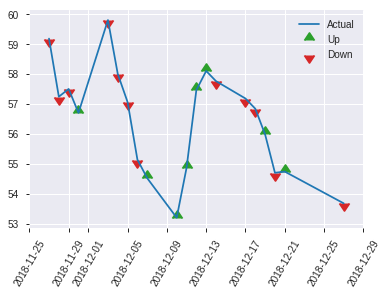


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21191709237298664
RMSE: 0.4603445365951318
LogLoss: 0.620137808923581
Mean Per-Class Error: 0.2966147966147966
AUC: 0.7270679770679771
pr_auc: 0.6327102199102177
Gini: 0.4541359541359542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38452279567718506: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   71   0.4797   (71.0/148.0)
1      20   79   0.202    (20.0/99.0)
Total  97   150  0.3684   (91.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384523     0.634538  149
max f2                       0.0649728    0.773438  243
max f0point5                 0.596888     0.659955  86
max accuracy                 0.596888     0.724696  86
max precision                0.821825     0.826087  22
max recall                   0.0649728    1         243
max specificity              0.915483     0.993243  0
max absolute_mcc             0.596888     0.417329  86
max min_per_class_accuracy   0.475475     0.676768  113
max mean_per_class_accuracy  0.596888     0.703385  86

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 46.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.896246           1.6633    1.6633             0.666667         0.906558   0.666667                    0.906558            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.878598           1.24747   1.49697            0.5              0.886484   0.6                         0.898529            0.010101        0.030303                   24.7475   49.697
    3        0.0323887                   0.873696           2.49495   1.87121            1                0.876747   0.75                        0.890361            0.030303        0.0606061                  149.495   87.1212
    4        0.0404858                   0.86122            1.24747   1.74646            0.5              0.869716   0.7                         0.886232            0.010101        0.0707071                  24.7475   74.6465
    5        0.0526316                   0.855455           2.49495   1.91919            1                0.85875    0.769231                    0.87989             0.030303        0.10101                    149.495   91.9192
    6        0.101215                    0.813357           2.07912   1.99596            0.833333         0.832334   0.8                         0.857063            0.10101         0.20202                    107.912   99.596
    7        0.149798                    0.76911            1.24747   1.75321            0.5              0.790337   0.702703                    0.835422            0.0606061       0.262626                   24.7475   75.3208
    8        0.202429                    0.754637           2.11111   1.84626            0.846154         0.760284   0.74                        0.815886            0.111111        0.373737                   111.111   84.6263
    9        0.299595                    0.655462           1.45539   1.71949            0.583333         0.702949   0.689189                    0.779258            0.141414        0.515152                   45.5387   71.9492
    10       0.40081                     0.547306           0.898182  1.51209            0.36             0.5985     0.606061                    0.733612            0.0909091       0.606061                   -10.1818  51.2091
    11       0.502024                    0.450968           0.99798   1.40844            0.4              0.490432   0.564516                    0.684584            0.10101         0.707071                   -0.20202  40.8439
    12       0.59919                     0.385903           0.83165   1.31491            0.333333         0.41842    0.527027                    0.641422            0.0808081       0.787879                   -16.835   31.4906
    13       0.700405                    0.277105           0.698586  1.22584            0.28             0.337769   0.491329                    0.597541            0.0707071       0.858586                   -30.1414  22.5842
    14       0.797571                    0.202659           0.311869  1.1145             0.125            0.237638   0.446701                    0.553695            0.030303        0.888889                   -68.8131  11.4495
    15       0.898785                    0.129313           0.598788  1.05642            0.24             0.16888    0.423423                    0.51036             0.0606061       0.949495                   -40.1212  5.64201
    16       1                           0.0520216          0.49899   1                  0.2              0.0942509  0.40081                     0.4

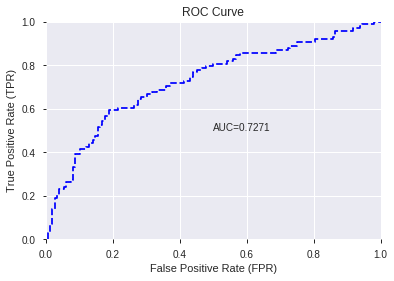

This function is available for GLM models only


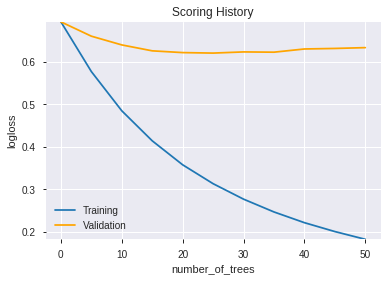

--2019-08-28 17:17:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_171705_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_171705_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'HT_DCPERIOD',
 'SAREXT',
 'DX_8',
 'day',
 'COS',
 'CORREL_8',
 'SUB',
 'SIN',
 'STOCHF_fastk',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_8',
 'CMO_8',
 'ULTOSC',
 'WILLR_12',
 'OBV',
 'BETA_30',
 'BETA_12',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'BETA_24',
 'CORREL_30',
 'ADOSC',
 'WILLR_20',
 'BETA_20',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastd',
 'weekday_name',
 'WILLR_14',
 'aroondown_12',
 'aroondown_14',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'STOCHF_fastd',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'CDL3OUTSIDE',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


36

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_171732_model_9  0.740854  0.608930              0.291769  0.457579  0.209379
1  DeepLearning_grid_1_AutoML_20190828_171732_model_8  0.740172  0.629721              0.308763  0.464334  0.215606
2  DeepLearning_grid_1_AutoML_20190828_171732_model_5  0.738875  0.612385              0.296888  0.451927  0.204238
3  DeepLearning_grid_1_AutoML_20190828_171732_model_6  0.736759  0.628211              0.296751  0.454223  0.206318
4  DeepLearning_grid_1_AutoML_20190828_171732_model_7  0.731095  0.645281              0.322345  0.457023  0.208870
5  DeepLearning_grid_1_AutoML_20190828_171732_model_3  0.727750  0.645236              0.319069  0.457505  0.209311
6  DeepLearning_grid_1_AutoML_20190828_171732_model_2  0.723314  0.605859              0.346062  0.455959  0.207898
7  DeepLearning_grid_1_AutoML_20190828_171732_model_1  0.705501  0.775567              0.339305  0.479138  0.229573
8               DeepLearning_1_AutoML_20190828_171732  0.704204  0.762756              0.344253  0.513688  0.263875
9  DeepLearning_grid_1_AutoML_20190828_171732_model_4  0.696833  0.676886              0.327396  0.477317  0.227832

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.067639
1   CDLCLOSINGMARUBOZU             0.793723           0.793723    0.053687
2          CDLLONGLINE             0.717394           0.717394    0.048524
3                  SUB             0.614669           0.614669    0.041576
4                  DIV             0.581573           0.581573    0.039337
5          CDLBELTHOLD             0.562648           0.562648    0.038057
6         CDLENGULFING             0.543610           0.543610    0.036769
7         CDLSHORTLINE             0.507829           0.507829    0.034349
8               TRANGE             0.464530           0.464530    0.031420
9         STOCHF_fastk             0.432310           0.432310    0.029241
10         CDLMARUBOZU             0.425700           0.425700    0.028794
11              ULTOSC             0.362326           0.362326    0.024507
12              ROCP_8             0.355306           0.355306    0.024033
13              CCI_14             0.354554           0.354554    0.023982
14      STOCHRSI_fastk             0.353574           0.353574    0.023915
15           ROCR100_8             0.341063           0.341063    0.023069
16               ADOSC             0.339747           0.339747    0.022980
17               MOM_8             0.337651           0.337651    0.022838
18            WILLR_20             0.337515           0.337515    0.022829
19              CCI_12             0.335703           0.335703    0.022707
20              ROCR_8             0.332492           0.332492    0.022489
21               ROC_8             0.331042           0.331042    0.022391
22               CCI_8             0.330940           0.330940    0.022385
23               RSI_8             0.324314           0.324314    0.021936
24            WILLR_12             0.322161           0.322161    0.021791
25              RSI_12             0.319567           0.319567    0.021615
26              RSI_20             0.317299           0.317299    0.021462
27               CMO_8             0.316205           0.316205    0.021388
28             WILLR_8             0.311951           0.311951    0.021100
29            WILLR_24             0.310138           0.310138    0.020977
30              CMO_14             0.306700           0.306700    0.020745
31              CMO_20             0.304851           0.304851    0.020620
32              CMO_12             0.304171           0.304171    0.020574
33            WILLR_14             0.301623           0.301623    0.020402
34              RSI_14             0.301530           0.301530    0.020395
35            WILLR_30             0.287923           0.287923    0.019475

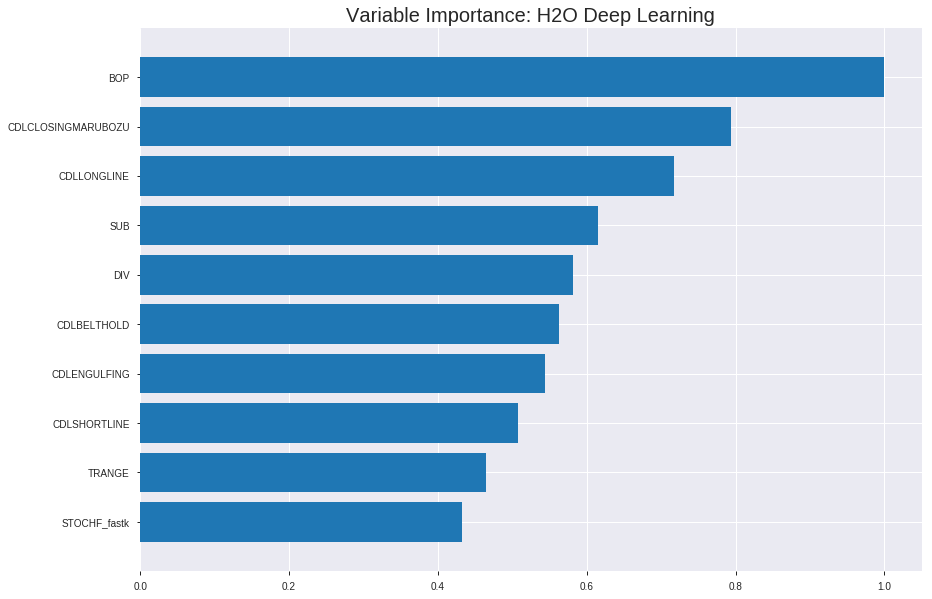

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_171732_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1963569351850541
RMSE: 0.44312180626217673
LogLoss: 0.5748550997535576
Mean Per-Class Error: 0.2972810031952734
AUC: 0.7697313156889934
pr_auc: 0.7600402166921634
Gini: 0.5394626313779869
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45248514656138894: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      470  385   0.4503   (385.0/855.0)
1      139  734   0.1592   (139.0/873.0)
Total  609  1119  0.3032   (524.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452485     0.736948  239
max f2                       0.199875     0.852058  349
max f0point5                 0.505972     0.706156  199
max accuracy                 0.476091     0.703704  223
max precision                0.949367     1         0
max recall                   0.118062     1         384
max specificity              0.949367     1         0
max absolute_mcc             0.476091     0.413208  223
max min_per_class_accuracy   0.504554     0.697595  200
max mean_per_class_accuracy  0.476091     0.702719  223

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.916473           1.86942   1.86942            0.944444         0.929778  0.944444                    0.929778            0.0194731       0.0194731                  86.9416   86.9416
    2        0.0202546                   0.906009           1.97938   1.92283            1                0.910683  0.971429                    0.920503            0.0194731       0.0389462                  97.9381   92.2828
    3        0.0300926                   0.898884           1.86295   1.90325            0.941176         0.902051  0.961538                    0.914471            0.0183276       0.0572738                  86.2947   90.3251
    4        0.0405093                   0.874762           1.31959   1.75317            0.666667         0.885144  0.885714                    0.90693             0.0137457       0.0710195                  31.9588   75.3166
    5        0.0503472                   0.864856           1.97938   1.79737            1                0.869836  0.908046                    0.899681            0.0194731       0.0904926                  97.9381   79.7369
    6        0.100116                    0.796189           1.7262    1.76199            0.872093         0.827726  0.890173                    0.863912            0.0859107       0.176403                   72.6205   76.1993
    7        0.150463                    0.750371           1.5016    1.67486            0.758621         0.772763  0.846154                    0.833412            0.0756014       0.252005                   50.16     67.4861
    8        0.200231                    0.695529           1.45001   1.61897            0.732558         0.724405  0.817919                    0.806318            0.0721649       0.32417                    45.0012   61.8974
    9        0.300347                    0.605361           1.37298   1.53698            0.693642         0.64936   0.776493                    0.753998            0.137457        0.461627                   37.2981   53.6976
    10       0.399884                    0.539752           1.26588   1.4695             0.639535         0.569591  0.742402                    0.708097            0.126002        0.587629                   26.5883   46.9497
    11       0.5                         0.504212           1.09839   1.39519            0.554913         0.519732  0.704861                    0.67038             0.109966        0.697595                   9.83851   39.5189
    12       0.600116                    0.47422            1.01829   1.33231            0.514451         0.489778  0.673095                    0.640251            0.101947        0.799542                   1.82945   33.2313
    13       0.699653                    0.413279           0.713498  1.24428            0.360465         0.44783   0.628619                    0.612876            0.0710195       0.870561                   -28.6502  24.4276
    14       0.799769                    0.28231            0.663608  1.17159            0.33526          0.347917  0.591896                    0.579708            0.0664376       0.936999                   -33.6392  17.1588
    15       0.899884                    0.186209           0.45766   1.09216            0.231214         0.238624  0.551768                    0.541761            0.045819        0.982818                   -54.234   9.21603
    16       1                           0.0381501          0.171623  1                  0.0867052        0.141143  0.505208                    0.501653         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20897661612694857
RMSE: 0.45713960244869245
LogLoss: 0.6046180717650581
Mean Per-Class Error: 0.3266984309537502
AUC: 0.7325310112544154
pr_auc: 0.7396550373616538
Gini: 0.4650620225088309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46214934758821363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  133  0.566    (133.0/235.0)
1      31   228  0.1197   (31.0/259.0)
Total  133  361  0.332    (164.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462149     0.735484  276
max f2                       0.176282     0.852048  383
max f0point5                 0.54123      0.694076  182
max accuracy                 0.54123      0.67004   182
max precision                0.929546     1         0
max recall                   0.152763     1         391
max specificity              0.929546     1         0
max absolute_mcc             0.462149     0.353932  276
max min_per_class_accuracy   0.521716     0.659574  206
max mean_per_class_accuracy  0.54123      0.673302  182

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 53.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.913611           1.90734   1.90734            1                0.924627  1                           0.924627            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.883188           1.52587   1.7166             0.8              0.903063  0.9                         0.913845            0.015444        0.034749                   52.5869   71.6602
    3        0.0303644                   0.869629           1.1444    1.52587            0.6              0.879925  0.8                         0.902538            0.011583        0.046332                   14.4402   52.5869
    4        0.0404858                   0.855748           1.90734   1.62124            1                0.866143  0.85                        0.893439            0.019305        0.0656371                  90.7336   62.1236
    5        0.0506073                   0.843581           1.52587   1.60216            0.8              0.848799  0.84                        0.884511            0.015444        0.0810811                  52.5869   60.2162
    6        0.101215                    0.809712           1.90734   1.75475            1                0.829858  0.92                        0.857185            0.0965251       0.177606                   90.7336   75.4749
    7        0.149798                    0.751954           1.4305    1.64959            0.75             0.778155  0.864865                    0.831553            0.0694981       0.247104                   43.0502   64.9588
    8        0.200405                    0.708588           1.1444    1.52202            0.6              0.728242  0.79798                     0.805465            0.0579151       0.305019                   14.4402   52.2016
    9        0.299595                    0.629447           1.40131   1.48205            0.734694         0.673708  0.777027                    0.761842            0.138996        0.444015                   40.1308   48.2052
    10       0.40081                     0.552888           1.10625   1.38715            0.58             0.582802  0.727273                    0.71663             0.111969        0.555985                   10.6255   38.7153
    11       0.5                         0.522414           0.934205  1.2973             0.489796         0.537115  0.680162                    0.681018            0.0926641       0.648649                   -6.57947  29.7297
    12       0.59919                     0.499183           1.05098   1.25652            0.55102          0.511988  0.658784                    0.653036            0.104247        0.752896                   5.0981    25.6522
    13       0.700405                    0.473103           0.953668  1.21276            0.5              0.486601  0.635838                    0.628985            0.0965251       0.849421                   -4.6332   21.2757
    14       0.799595                    0.403204           0.544953  1.12992            0.285714         0.445863  0.592405                    0.606269            0.0540541       0.903475                   -45.5047  12.9915
    15       0.898785                    0.270081           0.544953  1.06536            0.285714         0.33927   0.558559                    0.576803            0.0540541       0.957529                   -45.5047  6.53588
    16       1                           0.103982           0.419614  1                  0.22             0.19496   0.524291                    0.538155         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:24:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:24:58  2 min 51.655 sec  501 obs/sec       0.523148  1             904        0.554819         1.29804             -0.231429      0.680459        0.636018           1.75945          0.42419                          0.571427           1.36277               -0.309205        0.661201          0.687144             1.52587            0.396761
    2019-08-28 17:25:08  3 min  1.975 sec  830 obs/sec       5.36748   10            9275       0.459046         0.609071            0.157017       0.75348         0.746663           1.86942          0.335069                         0.465651           0.623652              0.130624         0.735012          0.735258             1.90734            0.32996
    2019-08-28 17:25:17  3 min 11.470 sec  982 obs/sec       11.228    21            19402      0.448404         0.586876            0.195647       0.756894        0.748691           1.75945          0.326968                         0.457142           0.605987              0.162107         0.741658          0.740789             1.52587            0.325911
    2019-08-28 17:25:27  3 min 21.158 sec  1102 obs/sec      18.1875   34            31428      0.446713         0.584055            0.201704       0.768223        0.757892           1.75945          0.321181                         0.456774           0.604897              0.163456         0.737747          0.749455             1.90734            0.327935
    2019-08-28 17:25:38  3 min 31.598 sec  1147 obs/sec      25.213    47            43568      0.443122         0.574855            0.214487       0.769731        0.76004            1.86942          0.303241                         0.45714            0.604618              0.162116         0.732531          0.739655             1.90734            0.331984
    2019-08-28 17:25:48  3 min 41.573 sec  1242 obs/sec      33.8183   63            58438      0.444006         0.578438            0.211348       0.775149        0.763654           1.86942          0.305556                         0.460788           0.612112              0.148688         0.736647          0.745619             1.90734            0.32996
    2019-08-28 17:25:57  3 min 51.313 sec  1314 obs/sec      42.4549   79            73362      0.440029         0.571201            0.225414       0.778888        0.763348           1.75945          0.296875                         0.457154           0.605754              0.162062         0.741765          0.754654             1.90734            0.336032
    2019-08-28 17:25:58  3 min 52.258 sec  1313 obs/sec      42.4549   79            73362      0.443122         0.574855            0.214487       0.769731        0.76004            1.86942          0.303241                         0.45714            0.604618              0.162116         0.732531          0.739655             1.90734            0.331984

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06763916738260811
CDLCLOSINGMARUBOZU  0.7937234044075012     0.7937234044075012   0.053686790206212524
CDLLONGLINE         0.7173943519592285     0.7173943519592285   0.04852395665150793
SUB                 0.6146692633628845     0.6146692633628845   0.04157571718954657
DIV                 0.581573486328125      0.581573486328125    0.039337146387035
---                 ---                    ---                  ---
CMO_20              0.30485138297080994    0.30485138297080994  0.020619893719582182
CMO_12              0.30417105555534363    0.30417105555534363  0.02057387693965248
WILLR_14            0.3016231060028076     0.3016231060028076   0.020401535753386053
RSI_14              0.3015303611755371     0.3015303611755371   0.020395262570490433
WILLR_30            0.28792300820350647    0.28792300820350647  0.019474872545181023


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.6635944700460831)

('auc', 0.7408544908544908)

('logloss', 0.6089295292350468)

('mean_per_class_error', 0.2917690417690417)

('rmse', 0.4575790417470839)

('mse', 0.20937857944617957)

deeplearning prediction progress: |███████████████████████████████████████| 100%


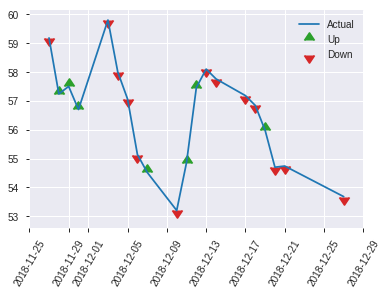


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20937857944617957
RMSE: 0.4575790417470839
LogLoss: 0.6089295292350468
Mean Per-Class Error: 0.2917690417690417
AUC: 0.7408544908544908
pr_auc: 0.6304763300928204
Gini: 0.4817089817089817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4932155133758537: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      102  46   0.3108   (46.0/148.0)
1      27   72   0.2727   (27.0/99.0)
Total  129  118  0.2955   (73.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493216     0.663594  117
max f2                       0.267485     0.781513  198
max f0point5                 0.526419     0.659341  88
max accuracy                 0.526419     0.724696  88
max precision                0.911978     1         0
max recall                   0.132759     1         242
max specificity              0.911978     1         0
max absolute_mcc             0.526419     0.41863   88
max min_per_class_accuracy   0.495259     0.689189  114
max mean_per_class_accuracy  0.493216     0.708231  117

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.890603           1.6633    1.6633             0.666667         0.903725  0.666667                    0.903725            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.879477           2.49495   1.99596            1                0.882585  0.8                         0.895269            0.020202        0.040404                   149.495   99.596
    3        0.0323887                   0.846032           2.49495   2.18308            1                0.862972  0.875                       0.883158            0.030303        0.0707071                  149.495   118.308
    4        0.0404858                   0.826049           1.24747   1.99596            0.5              0.836784  0.8                         0.873883            0.010101        0.0808081                  24.7475   99.596
    5        0.0526316                   0.814623           2.49495   2.11111            1                0.821009  0.846154                    0.861681            0.030303        0.111111                   149.495   111.111
    6        0.101215                    0.767839           1.24747   1.69657            0.5              0.794163  0.68                        0.829273            0.0606061       0.171717                   24.7475   69.6566
    7        0.149798                    0.7093             1.87121   1.75321            0.75             0.742554  0.702703                    0.801148            0.0909091       0.262626                   87.1212   75.3208
    8        0.202429                    0.616064           1.53535   1.69657            0.615385         0.647785  0.68                        0.761273            0.0808081       0.343434                   53.5354   69.6566
    9        0.299595                    0.543813           1.6633    1.68578            0.666667         0.57681   0.675676                    0.701447            0.161616        0.505051                   66.33     68.5777
    10       0.40081                     0.510769           1.29737   1.5877             0.52             0.528266  0.636364                    0.657715            0.131313        0.636364                   29.7374   58.7695
    11       0.502024                    0.49017            0.898182  1.44868            0.36             0.499784  0.580645                    0.625874            0.0909091       0.727273                   -10.1818  44.868
    12       0.59919                     0.452782           0.623737  1.31491            0.25             0.472588  0.527027                    0.601017            0.0606061       0.787879                   -37.6263  31.4906
    13       0.700405                    0.387124           0.698586  1.22584            0.28             0.422994  0.491329                    0.575291            0.0707071       0.858586                   -30.1414  22.5842
    14       0.797571                    0.269067           0.727694  1.16515            0.291667         0.326309  0.467005                    0.544958            0.0707071       0.929293                   -27.2306  16.5154
    15       0.898785                    0.21158            0.199596  1.05642            0.08             0.244688  0.423423                    0.511144            0.020202        0.949495                   -80.0404  5.64201
    16       1                           0.0739507          0.49899   1                  0.2              0.164154  0.40081                     0.476023            0.

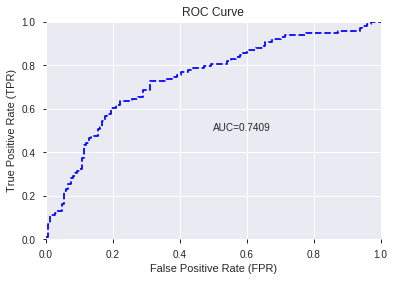

This function is available for GLM models only


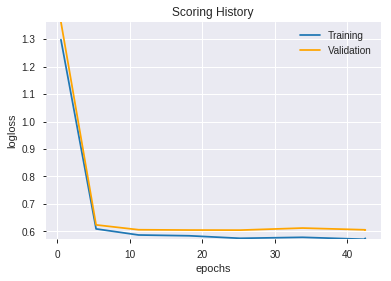

--2019-08-28 17:26:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_171732_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_171732_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'DIV',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'TRANGE',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'ULTOSC',
 'ROCP_8',
 'CCI_14',
 'STOCHRSI_fastk',
 'ROCR100_8',
 'ADOSC',
 'MOM_8',
 'WILLR_20',
 'CCI_12',
 'ROCR_8',
 'ROC_8',
 'CCI_8',
 'RSI_8',
 'WILLR_12',
 'RSI_12',
 'RSI_20',
 'CMO_8',
 'WILLR_8',
 'WILLR_24',
 'CMO_14',
 'CMO_20',
 'CMO_12',
 'WILLR_14',
 'RSI_14',
 'WILLR_30']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_172611_model_1  0.748635  0.587642              0.283374  0.448248  0.200926

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.797983           1.000000    0.157572
1                  SUB             0.566478           0.709888    0.111859
2         STOCHF_fastk             0.403049           0.505085    0.079588
3               CCI_14             0.394800           0.494748    0.077959
4                CCI_8             0.335000           0.419809    0.066150
5             WILLR_30             0.254536           0.318974    0.050261
6                MOM_8             0.247218           0.309803    0.048816
7               TRANGE             0.233226           0.292269    0.046054
8             WILLR_12             0.232309           0.291121    0.045873
9              WILLR_8             0.180849           0.226633    0.035711
10            WILLR_20             0.175739           0.220228    0.034702
11              CCI_12             0.142867           0.179036    0.028211
12        CDLENGULFING             0.128267           0.160740    0.025328
13         CDLMARUBOZU             0.106841           0.133889    0.021097
14      STOCHRSI_fastk             0.098678           0.123660    0.019485
15            WILLR_14             0.081450           0.102069    0.016083
16               ADOSC             0.068702           0.086095    0.013566
17        CDLSHORTLINE             0.066606           0.083468    0.013152
18              CMO_12             0.050514           0.063303    0.009975
19              RSI_14             0.049977           0.062630    0.009869
20              CMO_14             0.047545           0.059582    0.009388
21            WILLR_24             0.047266           0.059232    0.009333
22              RSI_12             0.039655           0.049694    0.007830
23         CDLLONGLINE             0.034262           0.042936    0.006766
24                 DIV             0.032251           0.040416    0.006368
25  CDLCLOSINGMARUBOZU             0.030339           0.038019    0.005991
26              ULTOSC             0.028559           0.035789    0.005639
27              ROCR_8             0.024858           0.031152    0.004909
28              ROCP_8             0.024145           0.030258    0.004768
29           ROCR100_8             0.023345           0.029255    0.004610
30               ROC_8             0.022816           0.028593    0.004505
31              CMO_20             0.020872           0.026156    0.004121
32               CMO_8             0.020746           0.025998    0.004097
33         CDLBELTHOLD             0.019483           0.024416    0.003847
34              RSI_20             0.019153           0.024001    0.003782
35               RSI_8             0.013840           0.017344    0.002733

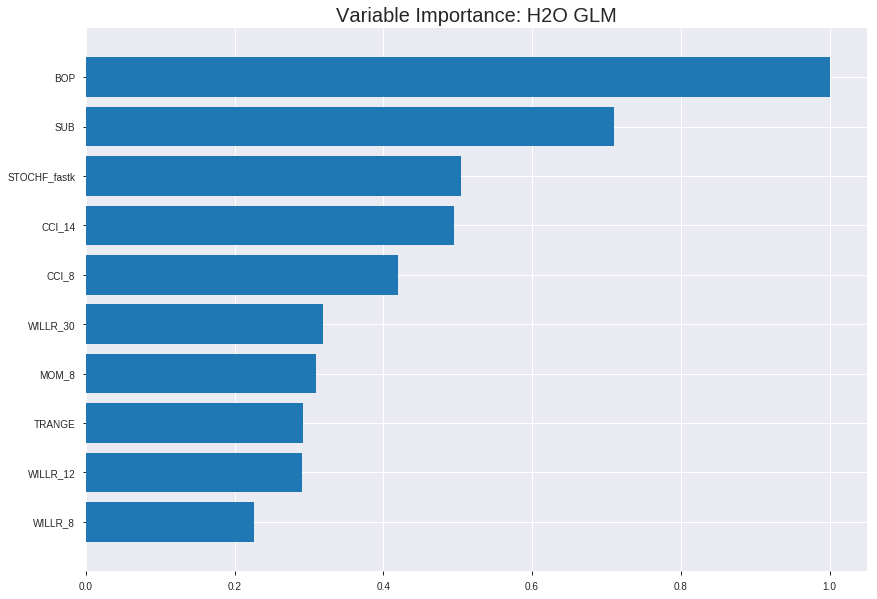

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_172611_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1966585849515621
RMSE: 0.4434620445444707
LogLoss: 0.5755539388647308
Null degrees of freedom: 1727
Residual degrees of freedom: 1691
Null deviance: 2395.329152624184
Residual deviance: 1989.1144127165098
AIC: 2063.11441271651
AUC: 0.7654079834944367
pr_auc: 0.7572579934450586
Gini: 0.5308159669888735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4031684347268448: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      477  378   0.4421   (378.0/855.0)
1      149  724   0.1707   (149.0/873.0)
Total  626  1102  0.305    (527.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403168     0.733165  247
max f2                       0.176072     0.847091  350
max f0point5                 0.593259     0.704828  154
max accuracy                 0.479889     0.700231  212
max precision                0.966786     1         0
max recall                   0.0682789    1         386
max specificity              0.966786     1         0
max absolute_mcc             0.431191     0.405712  234
max min_per_class_accuracy   0.513612     0.691228  194
max mean_per_class_accuracy  0.479889     0.699729  212

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.920947           1.97938   1.97938            1                0.936526  1                           0.936526            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.89781            1.74651   1.86627            0.882353         0.908817  0.942857                    0.923067            0.0171821       0.0378007                  74.6513   86.6274
    3        0.0300926                   0.874681           1.74651   1.82712            0.882353         0.886209  0.923077                    0.911017            0.0171821       0.0549828                  74.6513   82.7121
    4        0.0405093                   0.857331           1.97938   1.86627            1                0.866178  0.942857                    0.899487            0.0206186       0.0756014                  97.9381   86.6274
    5        0.0503472                   0.842951           1.39721   1.77462            0.705882         0.851041  0.896552                    0.890021            0.0137457       0.0893471                  39.721    77.4618
    6        0.100116                    0.796974           1.65716   1.71623            0.837209         0.818694  0.867052                    0.854564            0.0824742       0.171821                   65.7157   71.6227
    7        0.150463                    0.757936           1.59261   1.67486            0.804598         0.776351  0.846154                    0.828392            0.0801833       0.252005                   59.2606   67.4861
    8        0.200231                    0.723019           1.38096   1.60181            0.697674         0.739896  0.809249                    0.806396            0.0687285       0.320733                   38.0964   60.1812
    9        0.300347                    0.660065           1.33866   1.51409            0.676301         0.695463  0.764933                    0.769418            0.134021        0.454754                   33.8657   51.4093
    10       0.399884                    0.591323           1.33493   1.4695             0.674419         0.629039  0.742402                    0.734476            0.132875        0.587629                   33.4932   46.9497
    11       0.5                         0.514174           1.02974   1.38144            0.520231         0.555234  0.697917                    0.698586            0.103093        0.690722                   2.9736    38.1443
    12       0.600116                    0.431479           1.05262   1.32659            0.531792         0.47498   0.670203                    0.661282            0.105384        0.796105                   5.2619    32.6586
    13       0.699653                    0.359239           0.736514  1.24264            0.372093         0.392047  0.627792                    0.622979            0.0733104       0.869416                   -26.3486  24.2639
    14       0.799769                    0.282223           0.640725  1.16729            0.323699         0.323618  0.589725                    0.585505            0.0641466       0.933562                   -35.9275  16.7291
    15       0.899884                    0.19717            0.400453  1.08198            0.202312         0.239106  0.546624                    0.546967            0.0400916       0.973654                   -59.9547  8.1977
    16       1                           0.00391741         0.263155  1                  0.132948         0.129865  0.505208                    0.505208          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20168999567559184
RMSE: 0.44909909338095066
LogLoss: 0.5883708795087389
Null degrees of freedom: 493
Residual degrees of freedom: 457
Null deviance: 684.3830016464425
Residual deviance: 581.3104289546341
AIC: 655.3104289546341
AUC: 0.7545305183603056
pr_auc: 0.7548592176735901
Gini: 0.5090610367206112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4699025456369984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  95   0.4043   (95.0/235.0)
1      49   210  0.1892   (49.0/259.0)
Total  189  305  0.2915   (144.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469903     0.744681  240
max f2                       0.180682     0.854957  372
max f0point5                 0.561162     0.711987  193
max accuracy                 0.473066     0.708502  238
max precision                0.961783     1         0
max recall                   0.147497     1         384
max specificity              0.961783     1         0
max absolute_mcc             0.469903     0.417756  240
max min_per_class_accuracy   0.553754     0.689362  198
max mean_per_class_accuracy  0.473066     0.703475  238

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.91358            1.52587   1.52587            0.8              0.931866  0.8                         0.931866            0.015444        0.015444                   52.5869   52.5869
    2        0.0202429                   0.908573           1.90734   1.7166             1                0.911935  0.9                         0.921901            0.019305        0.034749                   90.7336   71.6602
    3        0.0303644                   0.882537           1.52587   1.65302            0.8              0.898139  0.866667                    0.91398             0.015444        0.0501931                  52.5869   65.3024
    4        0.0404858                   0.875964           1.90734   1.7166             1                0.879702  0.9                         0.905411            0.019305        0.0694981                  90.7336   71.6602
    5        0.0506073                   0.868665           1.90734   1.75475            1                0.873245  0.92                        0.898977            0.019305        0.0888031                  90.7336   75.4749
    6        0.101215                    0.834533           1.60216   1.67846            0.84             0.84679   0.88                        0.872884            0.0810811       0.169884                   60.2162   67.8456
    7        0.149798                    0.813612           1.50997   1.62381            0.791667         0.824364  0.851351                    0.857148            0.0733591       0.243243                   50.9974   62.3813
    8        0.200405                    0.7786             1.44958   1.57981            0.76             0.793193  0.828283                    0.840997            0.0733591       0.316602                   44.9575   57.9814
    9        0.299595                    0.707939           1.20668   1.45628            0.632653         0.74093   0.763514                    0.807867            0.119691        0.436293                   20.6682   45.6277
    10       0.40081                     0.632019           1.1444    1.37752            0.6              0.672551  0.722222                    0.773696            0.11583         0.552124                   14.4402   37.752
    11       0.5                         0.559635           1.32346   1.3668             0.693878         0.597949  0.716599                    0.738831            0.131274        0.683398                   32.3458   36.6795
    12       0.59919                     0.486847           1.01206   1.30807            0.530612         0.52203   0.685811                    0.702942            0.100386        0.783784                   1.20558   30.8072
    13       0.700405                    0.419394           0.686641  1.21827            0.36             0.451409  0.638728                    0.666593            0.0694981       0.853282                   -31.3359  21.8269
    14       0.799595                    0.339455           0.700654  1.15406            0.367347         0.379283  0.605063                    0.630952            0.0694981       0.92278                    -29.9346  15.4059
    15       0.898785                    0.257827           0.467103  1.07825            0.244898         0.304392  0.565315                    0.594913            0.046332        0.969112                   -53.2897  7.82462
    16       1                           0.0590777          0.305174  1                  0.16             0.174684  0.524291                    0.55238           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:26:12  0.000 sec   2            .21E2     37            1.3653271032133982  1.3680155695798306
     2019-08-28 17:26:12  0.019 sec   4            .13E2     37            1.3558973856150047  1.3601058394838128
     2019-08-28 17:26:12  0.033 sec   6            .81E1     37            1.3436549052011102  1.3497609858211328
     2019-08-28 17:26:12  0.042 sec   8            .5E1      37            1.328509776943922   1.3368184701596386
     2019-08-28 17:26:12  0.051 sec   10           .31E1     37            1.310444982550891   1.3211562040695262
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:26:12  0.196 sec   40           .25E-2    37            1.1499155635991913  1.1769347869172
     2019-08-28 17:26:12  0.207 sec   42           .15E-2    37            1.1491273237608377  1.1772835408962883
     2019-08-28 17:26:12  0.212 sec   43           .95E-3    37            1.1486211887662876  1.1776782347521442
     2019-08-28 17:26:12  0.218 sec   44           .59E-3    37            1.1483046885437973  1.1780372925275404
     2019-08-28 17:26:12  0.223 sec   45           .37E-3    37            1.1481183323391235  1.1783452883251317


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.708502024291498)

('F1', 0.6756756756756757)

('auc', 0.7486349986349986)

('logloss', 0.587641541245825)

('mean_per_class_error', 0.2833742833742834)

('rmse', 0.44824802056305213)

('mse', 0.20092628793869438)

glm prediction progress: |████████████████████████████████████████████████| 100%


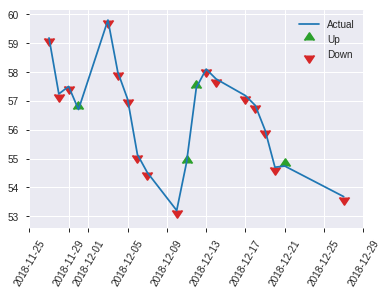


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20092628793869438
RMSE: 0.44824802056305213
LogLoss: 0.587641541245825
Null degrees of freedom: 246
Residual degrees of freedom: 210
Null deviance: 343.4623801242943
Residual deviance: 290.2949213754376
AIC: 364.2949213754376
AUC: 0.7486349986349986
pr_auc: 0.6421255246650471
Gini: 0.4972699972699972
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44800688139219785: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      100  48   0.3243   (48.0/148.0)
1      24   75   0.2424   (24.0/99.0)
Total  124  123  0.2915   (72.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448007     0.675676  122
max f2                       0.265653     0.791246  197
max f0point5                 0.451344     0.634648  120
max accuracy                 0.451344     0.708502  120
max precision                0.908057     1         0
max recall                   0.106761     1         239
max specificity              0.908057     1         0
max absolute_mcc             0.448007     0.424644  122
max min_per_class_accuracy   0.493534     0.69697   111
max mean_per_class_accuracy  0.448007     0.716626  122

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 46.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.885415           1.6633    1.6633             0.666667         0.897994  0.666667                    0.897994            0.020202        0.020202                   66.33     66.33
    2        0.0202429                   0.85533            2.49495   1.99596            1                0.871141  0.8                         0.887253            0.020202        0.040404                   149.495   99.596
    3        0.0323887                   0.832415           1.6633    1.87121            0.666667         0.845313  0.75                        0.871525            0.020202        0.0606061                  66.33     87.1212
    4        0.0404858                   0.818729           2.49495   1.99596            1                0.82877   0.8                         0.862974            0.020202        0.0808081                  149.495   99.596
    5        0.0526316                   0.807666           2.49495   2.11111            1                0.814367  0.846154                    0.851757            0.030303        0.111111                   149.495   111.111
    6        0.101215                    0.77423            2.07912   2.09576            0.833333         0.789504  0.84                        0.821876            0.10101         0.212121                   107.912   109.576
    7        0.149798                    0.722912           1.24747   1.82064            0.5              0.749615  0.72973                     0.79844             0.0606061       0.272727                   24.7475   82.0639
    8        0.202429                    0.670538           1.34343   1.69657            0.538462         0.695286  0.68                        0.77162             0.0707071       0.343434                   34.3434   69.6566
    9        0.299595                    0.598835           1.24747   1.55091            0.5              0.632675  0.621622                    0.726556            0.121212        0.464646                   24.7475   55.0915
    10       0.40081                     0.52213            1.49697   1.53729            0.6              0.558839  0.616162                    0.684204            0.151515        0.616162                   49.697    53.7292
    11       0.502024                    0.447434           1.39717   1.50904            0.56             0.485302  0.604839                    0.644102            0.141414        0.757576                   39.7172   50.9042
    12       0.59919                     0.398531           0.415825  1.33176            0.166667         0.419642  0.533784                    0.607703            0.040404        0.79798                    -58.4175  33.1764
    13       0.700405                    0.308865           0.698586  1.24026            0.28             0.348583  0.49711                     0.570258            0.0707071       0.868687                   -30.1414  24.0264
    14       0.797571                    0.266368           0.727694  1.17782            0.291667         0.290106  0.472081                    0.536128            0.0707071       0.939394                   -27.2306  17.7819
    15       0.898785                    0.195975           0.199596  1.06766            0.08             0.227386  0.427928                    0.50136             0.020202        0.959596                   -80.0404  6.76586
    16       1                           0.0325311          0.399192  1                  0.16             0.13304   0.40081                     0.46408             0

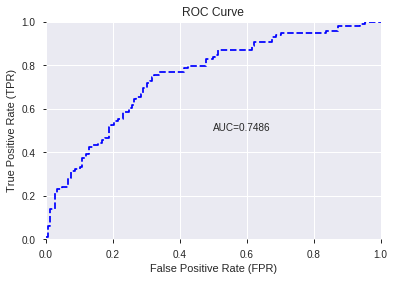

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


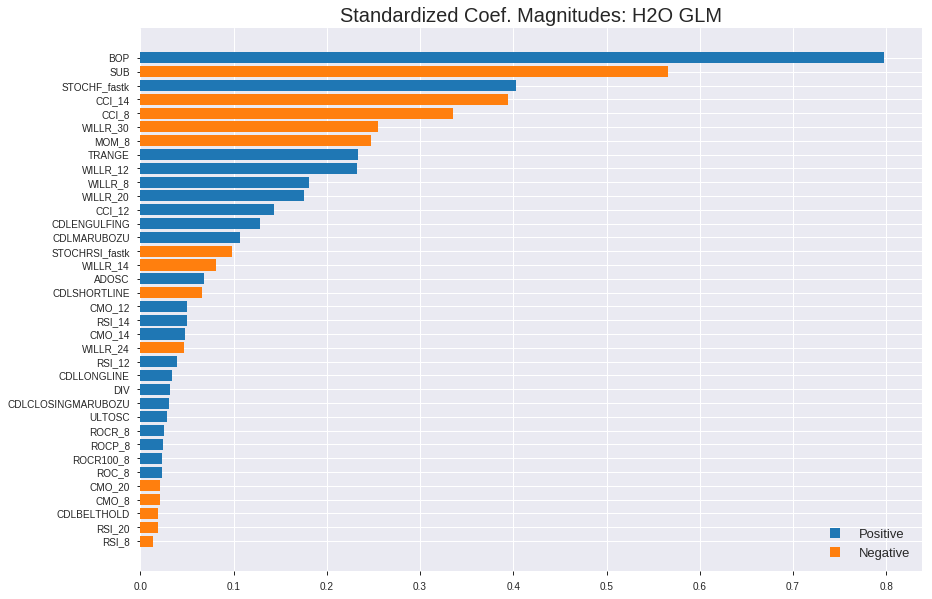

'log_likelihood'
--2019-08-28 17:26:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.33.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.33.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_172611_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_172611_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CCI_14',
 'CCI_8',
 'WILLR_30',
 'MOM_8',
 'TRANGE',
 'WILLR_12',
 'WILLR_8',
 'WILLR_20',
 'CCI_12',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'WILLR_14',
 'ADOSC',
 'CDLSHORTLINE',
 'CMO_12',
 'RSI_14',
 'CMO_14',
 'WILLR_24',
 'RSI_12',
 'CDLLONGLINE',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'ROCR_8',
 'ROCP_8',
 'ROCR100_8',
 'ROC_8',
 'CMO_20',
 'CMO_8',
 'CDLBELTHOLD',
 'RSI_20',
 'RSI_8']

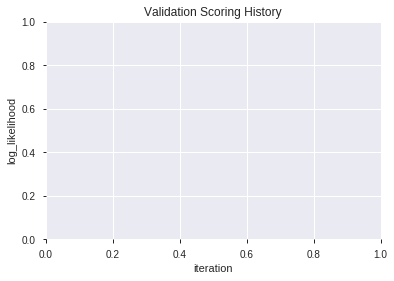

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_172623_model_1  0.745359  0.597300              0.346164  0.452426  0.204689
1  XGBoost_grid_1_AutoML_20190828_172623_model_4  0.744540  0.594980              0.306955  0.451813  0.204135
2  XGBoost_grid_1_AutoML_20190828_172623_model_2  0.738056  0.600286              0.295079  0.453979  0.206097
3               XGBoost_1_AutoML_20190828_172623  0.737647  0.608445              0.319001  0.457387  0.209203
4               XGBoost_3_AutoML_20190828_172623  0.736555  0.599349              0.320639  0.454326  0.206412
5  XGBoost_grid_1_AutoML_20190828_172623_model_3  0.734507  0.606906              0.320741  0.457148  0.208984
6               XGBoost_2_AutoML_20190828_172623  0.732255  0.606666              0.329068  0.457463  0.209272
7  XGBoost_grid_1_AutoML_20190828_172623_model_7  0.727068  0.618544              0.303610  0.460911  0.212439
8  XGBoost_grid_1_AutoML_20190828_172623_model_6  0.725293  0.611105              0.320741  0.459145  0.210814
9  XGBoost_grid_1_AutoML_20190828_172623_model_5  0.719014  0.630257              0.298628  0.464243  0.215522

variable  relative_importance  scaled_importance  percentage
0                  BOP          3038.707520           1.000000    0.383066
1                  DIV           578.838440           0.190488    0.072970
2                  SUB           496.970947           0.163547    0.062649
3       STOCHRSI_fastk           492.145264           0.161959    0.062041
4                CCI_8           333.320801           0.109692    0.042019
5         STOCHF_fastk           321.164032           0.105691    0.040487
6             WILLR_12           273.308655           0.089942    0.034454
7               TRANGE           226.470276           0.074528    0.028549
8             WILLR_24           220.203949           0.072466    0.027759
9               CCI_12           179.736374           0.059149    0.022658
10               ROC_8           172.707291           0.056836    0.021772
11               MOM_8           159.635284           0.052534    0.020124
12              ULTOSC           156.271179           0.051427    0.019700
13               CMO_8           146.079422           0.048073    0.018415
14            WILLR_30           137.778229           0.045341    0.017369
15               ADOSC           137.336578           0.045196    0.017313
16              CCI_14           125.373306           0.041259    0.015805
17             WILLR_8            93.300919           0.030704    0.011762
18              CMO_14            90.161346           0.029671    0.011366
19            WILLR_14            80.568275           0.026514    0.010157
20              CMO_12            66.053703           0.021737    0.008327
21              ROCP_8            65.942818           0.021701    0.008313
22               RSI_8            57.901962           0.019055    0.007299
23  CDLCLOSINGMARUBOZU            56.995586           0.018757    0.007185
24            WILLR_20            54.438652           0.017915    0.006863
25              CMO_20            53.513615           0.017611    0.006746
26        CDLENGULFING            33.795589           0.011122    0.004260
27              ROCR_8            27.395950           0.009016    0.003454
28              RSI_14            21.310635           0.007013    0.002686
29         CDLLONGLINE            13.895853           0.004573    0.001752
30              RSI_12            10.924011           0.003595    0.001377
31              RSI_20            10.340486           0.003403    0.001304

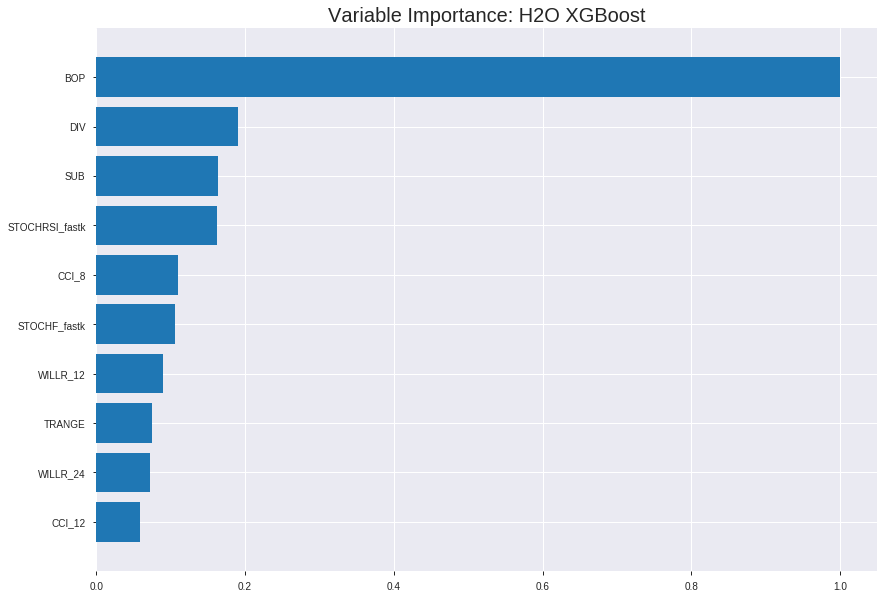

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_172623_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15022228207634303
RMSE: 0.38758519331411906
LogLoss: 0.4696619577533812
Mean Per-Class Error: 0.1984867667450413
AUC: 0.8870909614624571
pr_auc: 0.8928489494393572
Gini: 0.7741819229249143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4737040281295776: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      623  232  0.2713   (232.0/855.0)
1      123  750  0.1409   (123.0/873.0)
Total  746  982  0.2054   (355.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473704     0.808625  213
max f2                       0.254597     0.877086  317
max f0point5                 0.605323     0.82789   146
max accuracy                 0.52072      0.801505  189
max precision                0.926302     1         0
max recall                   0.168616     1         354
max specificity              0.926302     1         0
max absolute_mcc             0.564872     0.603188  167
max min_per_class_accuracy   0.519199     0.80117   190
max mean_per_class_accuracy  0.52072      0.801513  189

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.89851            1.97938    1.97938            1                0.908444  1                           0.908444            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.887132           1.97938    1.97938            1                0.893009  1                           0.900947            0.0194731       0.0400916                  97.9381   97.9381
    3        0.0300926                   0.876176           1.97938    1.97938            1                0.881108  1                           0.894461            0.0194731       0.0595647                  97.9381   97.9381
    4        0.0405093                   0.867294           1.97938    1.97938            1                0.871424  1                           0.888537            0.0206186       0.0801833                  97.9381   97.9381
    5        0.0503472                   0.857953           1.97938    1.97938            1                0.861878  1                           0.883328            0.0194731       0.0996564                  97.9381   97.9381
    6        0.100116                    0.808564           1.93335    1.9565             0.976744         0.833558  0.988439                    0.858587            0.0962199       0.195876                   93.3349   95.6498
    7        0.150463                    0.764823           1.84287    1.91848            0.931034         0.78864   0.969231                    0.835182            0.0927835       0.28866                    84.2872   91.8477
    8        0.200231                    0.723419           1.88732    1.91073            0.953488         0.743044  0.965318                    0.81228             0.093929        0.382589                   88.7317   91.0732
    9        0.300347                    0.657957           1.70479    1.84208            0.861272         0.687674  0.930636                    0.770745            0.170676        0.553265                   70.4785   84.2083
    10       0.399884                    0.592335           1.34644    1.71871            0.680233         0.626644  0.868307                    0.734876            0.134021        0.687285                   34.644    71.871
    11       0.5                         0.521291           1.08694    1.59221            0.549133         0.55593   0.804398                    0.699046            0.10882         0.796105                   8.69436   59.2211
    12       0.600116                    0.447906           0.800906   1.4602             0.404624         0.485506  0.737705                    0.663421            0.0801833       0.876289                   -19.9094  46.0199
    13       0.699653                    0.349616           0.609926   1.33923            0.30814          0.400821  0.676592                    0.626062            0.0607102       0.936999                   -39.0074  33.9234
    14       0.799769                    0.27299            0.411894   1.22315            0.208092         0.31154   0.617945                    0.58669             0.0412371       0.978236                   -58.8106  22.3149
    15       0.899884                    0.177462           0.205947   1.10998            0.104046         0.226245  0.560772                    0.546589            0.0206186       0.998855                   -79.4053  10.9981
    16       1                           0.0587273          0.0114415  1                  0.00578035       0.129636  0.505208                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21171534930182648
RMSE: 0.46012536259352893
LogLoss: 0.6090507541576484
Mean Per-Class Error: 0.33403433828965745
AUC: 0.7255976341082724
pr_auc: 0.7344674833801335
Gini: 0.45119526821654476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.349347323179245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   160  0.6809   (160.0/235.0)
1      17   242  0.0656   (17.0/259.0)
Total  92   402  0.3583   (177.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349347     0.732224  321
max f2                       0.205342     0.858283  376
max f0point5                 0.670832     0.684372  138
max accuracy                 0.492626     0.672065  247
max precision                0.92075      1         0
max recall                   0.157476     1         388
max specificity              0.92075      1         0
max absolute_mcc             0.490763     0.344456  248
max min_per_class_accuracy   0.587794     0.646809  197
max mean_per_class_accuracy  0.492626     0.665966  247

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 55.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.877138           1.90734   1.90734            1                0.898908  1                           0.898908            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.869666           1.52587   1.7166             0.8              0.873739  0.9                         0.886324            0.015444        0.034749                   52.5869   71.6602
    3        0.0303644                   0.864269           1.1444    1.52587            0.6              0.868167  0.8                         0.880271            0.011583        0.046332                   14.4402   52.5869
    4        0.0404858                   0.854627           1.90734   1.62124            1                0.860359  0.85                        0.875293            0.019305        0.0656371                  90.7336   62.1236
    5        0.0506073                   0.850245           1.90734   1.67846            1                0.852085  0.88                        0.870652            0.019305        0.0849421                  90.7336   67.8456
    6        0.101215                    0.821252           1.75475   1.7166             0.92             0.835626  0.9                         0.853139            0.0888031       0.173745                   75.4749   71.6602
    7        0.149798                    0.78154            1.35103   1.59804            0.708333         0.800881  0.837838                    0.83619             0.0656371       0.239382                   35.103    59.8038
    8        0.200405                    0.749452           1.22069   1.50275            0.64             0.75906   0.787879                    0.816713            0.0617761       0.301158                   22.0695   50.275
    9        0.299595                    0.692128           1.36238   1.45628            0.714286         0.718308  0.763514                    0.784133            0.135135        0.436293                   36.2383   45.6277
    10       0.40081                     0.653693           1.10625   1.36789            0.58             0.674503  0.717172                    0.756449            0.111969        0.548263                   10.6255   36.7887
    11       0.5                         0.596221           0.89528   1.27413            0.469388         0.627753  0.668016                    0.730918            0.0888031       0.637066                   -10.472   27.4131
    12       0.59919                     0.51713            1.08991   1.24363            0.571429         0.555263  0.652027                    0.70184             0.108108        0.745174                   8.99062   24.3635
    13       0.700405                    0.441469           0.953668  1.20173            0.5              0.481689  0.630058                    0.670026            0.0965251       0.841699                   -4.6332   20.1732
    14       0.799595                    0.369869           0.739579  1.1444             0.387755         0.410512  0.6                         0.637833            0.0733591       0.915058                   -26.0421  14.4402
    15       0.898785                    0.25468            0.544953  1.07825            0.285714         0.311764  0.565315                    0.601848            0.0540541       0.969112                   -45.5047  7.82462
    16       1                           0.0682534          0.305174  1                  0.16             0.182953  0.524291                    0.55945           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:26:27  0.022 sec   0                  0.5              0.693147            0.5             0                  1                0.494792                         0.5                0.693147              0.5               0                    1                  0.475709
    2019-08-28 17:26:27  0.127 sec   5                  0.470658         0.635788            0.838576        0.841532           1.97938          0.243056                         0.482606           0.65873               0.723035          0.725568             1.52587            0.338057
    2019-08-28 17:26:27  0.201 sec   10                 0.449847         0.595777            0.844694        0.847914           1.97938          0.239583                         0.471373           0.636345              0.726682          0.728989             1.58945            0.350202
    2019-08-28 17:26:27  0.274 sec   15                 0.434196         0.565455            0.853376        0.861229           1.97938          0.226852                         0.466705           0.626317              0.720866          0.729116             1.90734            0.331984
    2019-08-28 17:26:28  0.345 sec   20                 0.422508         0.542306            0.859932        0.866443           1.97938          0.212963                         0.463479           0.61905               0.722287          0.729272             1.90734            0.338057
    2019-08-28 17:26:28  0.412 sec   25                 0.413611         0.524046            0.864753        0.871032           1.97938          0.217593                         0.462622           0.616436              0.719165          0.722234             1.52587            0.334008
    2019-08-28 17:26:28  0.481 sec   30                 0.406697         0.509845            0.870134        0.876745           1.97938          0.223958                         0.462281           0.615075              0.71827           0.722718             1.90734            0.338057
    2019-08-28 17:26:28  0.554 sec   35                 0.400924         0.49776             0.874871        0.881795           1.97938          0.222222                         0.461349           0.612552              0.720611          0.727354             1.90734            0.348178
    2019-08-28 17:26:28  0.618 sec   40                 0.396815         0.488846            0.877331        0.882326           1.97938          0.21875                          0.460868           0.611154              0.723158          0.731309             1.90734            0.340081
    2019-08-28 17:26:28  0.679 sec   45                 0.393125         0.481249            0.881486        0.888413           1.97938          0.21412                          0.461063           0.611405              0.722648          0.730015             1.90734            0.34413
    2019-08-28 17:26:28  0.743 sec   50                 0.390182         0.4749              0.884274        0.891095           1.97938          0.211806                         0.460519           0.609858              0.724497          0.734024             1.90734            0.360324
    2019-08-28 17:26:28  0.801 sec   55                 0.387585         0.469662            0.887091        0.892849           1.97938          0.20544                          0.460125           0.609051              0.725598          0.

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             3038.70751953125       1.0                    0.3830663993555694
DIV             578.8384399414062      0.19048836922307602    0.07296969371739799
SUB             496.970947265625       0.16354681853102057    0.06264929090073676
STOCHRSI_fastk  492.145263671875       0.16195874743081334    0.06204095422245974
CCI_8           333.32080078125        0.10969163653916517    0.04201918024847781
---             ---                    ---                    ---
ROCR_8          27.395950317382812     0.009015658842220163   0.0034535959705074793
RSI_14          21.31063461303711      0.00701305883375195    0.0026864671959141283
CDLLONGLINE     13.895853042602539     0.0045729485161987915  0.0017517429225386647
RSI_12          10.92401123046875      0.0035949531701405355  0.0013771057667376246
RSI_20          10.340485572814941     0.0034029222971778674  0.0013035451916667087


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7044534412955465)

('F1', 0.6501766784452296)

('auc', 0.7453589953589953)

('logloss', 0.5972995626344064)

('mean_per_class_error', 0.30180180180180183)

('rmse', 0.45242611143762895)

('mse', 0.20468938631057387)

xgboost prediction progress: |████████████████████████████████████████████| 100%


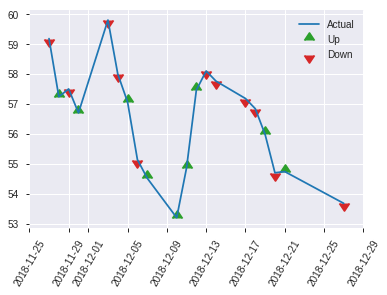


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20468938631057387
RMSE: 0.45242611143762895
LogLoss: 0.5972995626344064
Mean Per-Class Error: 0.30180180180180183
AUC: 0.7453589953589953
pr_auc: 0.6517372739849853
Gini: 0.4907179907179906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32631656527519226: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   92   0.6216   (92.0/148.0)
1      7    92   0.0707   (7.0/99.0)
Total  63   184  0.4008   (99.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326317     0.650177  183
max f2                       0.311075     0.793515  189
max f0point5                 0.625531     0.633423  67
max accuracy                 0.625531     0.704453  67
max precision                0.911921     1         0
max recall                   0.10835      1         240
max specificity              0.911921     1         0
max absolute_mcc             0.515281     0.392478  105
max min_per_class_accuracy   0.48554      0.689189  114
max mean_per_class_accuracy  0.515281     0.698198  105

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.870059           2.49495   2.49495            1                0.88874   1                           0.88874             0.030303        0.030303                   149.495   149.495
    2        0.0202429                   0.859087           2.49495   2.49495            1                0.866763  1                           0.879949            0.020202        0.0505051                  149.495   149.495
    3        0.0323887                   0.852151           0.83165   1.87121            0.333333         0.856388  0.75                        0.871114            0.010101        0.0606061                  -16.835   87.1212
    4        0.0404858                   0.838836           2.49495   1.99596            1                0.847486  0.8                         0.866389            0.020202        0.0808081                  149.495   99.596
    5        0.0526316                   0.83317            1.6633    1.91919            0.666667         0.837261  0.769231                    0.859667            0.020202        0.10101                    66.33     91.9192
    6        0.101215                    0.784782           2.07912   1.99596            0.833333         0.806797  0.8                         0.834289            0.10101         0.20202                    107.912   99.596
    7        0.149798                    0.745914           1.87121   1.9555             0.75             0.766836  0.783784                    0.812412            0.0909091       0.292929                   87.1212   95.5501
    8        0.202429                    0.683757           0.959596  1.69657            0.384615         0.714932  0.68                        0.787067            0.0505051       0.343434                   -4.0404   69.6566
    9        0.299595                    0.605556           1.6633    1.68578            0.666667         0.648655  0.675676                    0.742177            0.161616        0.505051                   66.33     68.5777
    10       0.40081                     0.526827           1.09778   1.53729            0.44             0.565218  0.616162                    0.69749             0.111111        0.616162                   9.77778   53.7292
    11       0.502024                    0.460714           1.09778   1.44868            0.44             0.49618   0.580645                    0.656904            0.111111        0.727273                   9.77778   44.868
    12       0.59919                     0.405868           0.519781  1.29805            0.208333         0.434749  0.52027                     0.620879            0.0505051       0.777778                   -48.0219  29.8048
    13       0.700405                    0.344772           0.99798   1.25469            0.4              0.373668  0.50289                     0.585154            0.10101         0.878788                   -0.20202  25.4686
    14       0.797571                    0.280603           0.623737  1.17782            0.25             0.317998  0.472081                    0.552607            0.0606061       0.939394                   -37.6263  17.7819
    15       0.898785                    0.19266            0.099798  1.05642            0.04             0.242983  0.423423                    0.51774             0.010101        0.949495                   -90.0202  5.64201
    16       1                           0.0635371          0.49899   1                  0.2              0.139583  0.40081                     0.479465            

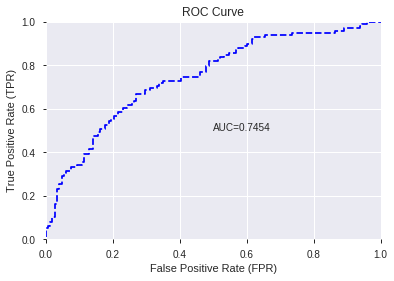

This function is available for GLM models only


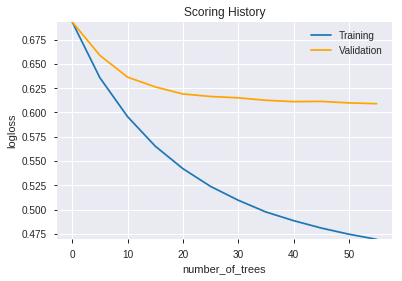

--2019-08-28 17:26:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_172623_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_172623_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'STOCHRSI_fastk',
 'CCI_8',
 'STOCHF_fastk',
 'WILLR_12',
 'TRANGE',
 'WILLR_24',
 'CCI_12',
 'ROC_8',
 'MOM_8',
 'ULTOSC',
 'CMO_8',
 'WILLR_30',
 'ADOSC',
 'CCI_14',
 'WILLR_8',
 'CMO_14',
 'WILLR_14',
 'CMO_12',
 'ROCP_8',
 'RSI_8',
 'CDLCLOSINGMARUBOZU',
 'WILLR_20',
 'CMO_20',
 'CDLENGULFING',
 'ROCR_8',
 'RSI_14',
 'CDLLONGLINE',
 'RSI_12',
 'RSI_20']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

55

['BBANDS_upperband_14_2_2',
 'BBANDS_upperband_14_4_2',
 'BBANDS_upperband_14_4_5',
 'BBANDS_upperband_14_7_3',
 'BBANDS_lowerband_24_6_3',
 'BBANDS_upperband_24_6_5',
 'BBANDS_middleband_30_0_4',
 'BOP',
 'MFI_8',
 'MINUS_DI_8',
 'ROCR_8',
 'WILLR_8',
 'MOM_12',
 'PLUS_DM_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'PLUS_DM_14',
 'WILLR_14',
 'CCI_20',
 'MACDFIX_hist_20',
 'MOM_20',
 'ROCP_20',
 'RSI_20',
 'WILLR_20',
 'ADX_24',
 'AROONOSC_24',
 'MACDFIX_24',
 'MINUS_DI_24',
 'ROC_24',
 'WILLR_24',
 'MOM_30',
 'PLUS_DI_30',
 'WILLR_30',
 'MACD_hist',
 'MACDEXT_signal',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ATR_8',
 'ATR_24',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CORREL_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'BETA_12',
 'LINEARREG_ANGLE_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_172759_model_2  0.717445  0.652815              0.312039  0.471872  0.222663
1  DeepLearning_grid_1_AutoML_20190828_172759_model_9  0.714646  0.620940              0.311971  0.463369  0.214711
2  DeepLearning_grid_1_AutoML_20190828_172759_model_8  0.711643  0.621210              0.308797  0.463463  0.214798
3  DeepLearning_grid_1_AutoML_20190828_172759_model_6  0.709459  0.652339              0.330740  0.467474  0.218532
4               DeepLearning_1_AutoML_20190828_172759  0.706593  0.639452              0.339305  0.470891  0.221738
5  DeepLearning_grid_1_AutoML_20190828_172759_model_5  0.700246  0.631889              0.337428  0.469154  0.220106
6  DeepLearning_grid_1_AutoML_20190828_172759_model_3  0.698676  0.739039              0.352750  0.504760  0.254783
7  DeepLearning_grid_1_AutoML_20190828_172759_model_7  0.696901  0.720682              0.359644  0.492535  0.242591
8  DeepLearning_grid_1_AutoML_20190828_172759_model_1  0.695127  0.740469              0.388343  0.488461  0.238595
9  DeepLearning_grid_1_AutoML_20190828_172759_model_4  0.656975  1.111442              0.423901  0.589802  0.347866

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.032277
1             CDLSPINNINGTOP             0.684382           0.684382    0.022090
2                STOCH_slowd             0.638927           0.638927    0.020623
3                   CORREL_8             0.632371           0.632371    0.020411
4                HT_DCPERIOD             0.629192           0.629192    0.020309
5             STOCHRSI_fastk             0.622430           0.622430    0.020090
6               STOCHF_fastk             0.622367           0.622367    0.020088
7                     TRANGE             0.617529           0.617529    0.019932
8   BBANDS_middleband_30_0_4             0.612845           0.612845    0.019781
9                STOCH_slowk             0.610925           0.610925    0.019719
10              MACDEXT_hist             0.608246           0.608246    0.019633
11            STOCHRSI_fastd             0.596672           0.596672    0.019259
12                    ATR_24             0.595528           0.595528    0.019222
13                    ADX_24             0.591374           0.591374    0.019088
14         LINEARREG_SLOPE_8             0.578594           0.578594    0.018675
15                    MOM_20             0.575122           0.575122    0.018563
16                PLUS_DI_30             0.573043           0.573043    0.018496
17                     ATR_8             0.572323           0.572323    0.018473
18               AROONOSC_24             0.570281           0.570281    0.018407
19               CDLBELTHOLD             0.569638           0.569638    0.018386
20        LINEARREG_ANGLE_12             0.565918           0.565918    0.018266
21   BBANDS_lowerband_24_6_3             0.564238           0.564238    0.018212
22                   BETA_12             0.563869           0.563869    0.018200
23               CDLLONGLINE             0.563728           0.563728    0.018196
24                     VAR_8             0.561799           0.561799    0.018133
25                   WILLR_8             0.558913           0.558913    0.018040
26   BBANDS_upperband_14_2_2             0.555689           0.555689    0.017936
27   BBANDS_upperband_24_6_5             0.552237           0.552237    0.017825
28                    RSI_12             0.548819           0.548819    0.017714
29                PLUS_DM_12             0.540361           0.540361    0.017441
30                     MFI_8             0.537533           0.537533    0.017350
31                  WILLR_20             0.535717           0.535717    0.017292
32   BBANDS_upperband_14_7_3             0.534166           0.534166    0.017241
33                  WILLR_12             0.530398           0.530398    0.017120
34           MACDFIX_hist_20             0.529630           0.529630    0.017095
35                    MOM_30             0.529012           0.529012    0.017075
36            MACDEXT_signal             0.528831           0.528831    0.017069
37         HT_PHASOR_inphase             0.528691           0.528691    0.017065
38                  WILLR_14             0.527897           0.527897    0.017039
39                    ROC_24             0.525601           0.525601    0.016965
40                 MACD_hist             0.523642           0.523642    0.016902
41                MINUS_DI_8             0.521558           0.521558    0.016834
42                   ROCP_20             0.519392           0.519392    0.016765
43   BBANDS_upperband_14_4_2             0.518875           0.518875    0.016748
44                    MOM_12             0.515435           0.515435    0.016637
45                  WILLR_24             0.512844           0.512844    0.016553
46                    ROCR_8             0.509947           0.509947    0.016460
47                PLUS_DM_14             0.509057           0.509057    0.016431
48               MINUS_DI_24             0.508897  

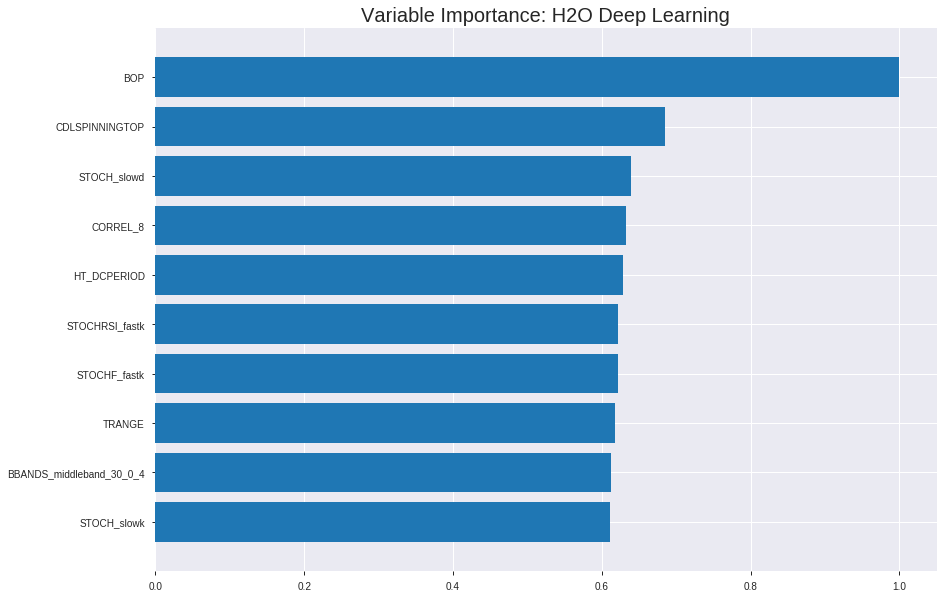

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_172759_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21283743684186265
RMSE: 0.46134307932585555
LogLoss: 0.63025891980027
Mean Per-Class Error: 0.303195273406885
AUC: 0.7594716076177462
pr_auc: 0.7568756480540056
Gini: 0.5189432152354925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19737568185545584: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      417  438   0.5123   (438.0/855.0)
1      131  742   0.1501   (131.0/873.0)
Total  548  1180  0.3293   (569.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197376     0.722845  299
max f2                       0.041709     0.84525   376
max f0point5                 0.428194     0.707559  206
max accuracy                 0.348034     0.696759  234
max precision                0.991382     1         0
max recall                   0.00717634   1         396
max specificity              0.991382     1         0
max absolute_mcc             0.428194     0.396251  206
max min_per_class_accuracy   0.360312     0.692398  230
max mean_per_class_accuracy  0.428194     0.696805  206

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 41.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.973131           1.97938   1.97938            1                0.980186   1                           0.980186            0.0206186       0.0206186                  97.9381   97.9381
    2        0.0202546                   0.955724           1.97938   1.97938            1                0.965096   1                           0.972856            0.0194731       0.0400916                  97.9381   97.9381
    3        0.0300926                   0.938685           1.63008   1.86519            0.823529         0.947253   0.942308                    0.964486            0.0160367       0.0561283                  63.0079   86.5186
    4        0.0405093                   0.926203           1.64948   1.80972            0.833333         0.931906   0.914286                    0.956108            0.0171821       0.0733104                  64.9485   80.972
    5        0.0503472                   0.912825           1.63008   1.77462            0.823529         0.918472   0.896552                    0.948754            0.0160367       0.0893471                  63.0079   77.4618
    6        0.100116                    0.854524           1.63414   1.70479            0.825581         0.88403    0.861272                    0.916579            0.0813288       0.170676                   63.414    70.4785
    7        0.150463                    0.795107           1.68361   1.6977             0.850575         0.824709   0.857692                    0.885838            0.0847652       0.255441                   68.3612   69.77
    8        0.200231                    0.740236           1.38096   1.61897            0.697674         0.765395   0.817919                    0.855901            0.0687285       0.32417                    38.0964   61.8974
    9        0.300347                    0.612891           1.39586   1.5446             0.705202         0.669115   0.780347                    0.793639            0.139748        0.463918                   39.5864   54.4604
    10       0.399884                    0.485172           1.19684   1.45804            0.604651         0.553377   0.736614                    0.733834            0.119129        0.583047                   19.6835   45.8039
    11       0.5                         0.362849           1.06406   1.37915            0.537572         0.42253    0.696759                    0.671501            0.106529        0.689576                   6.40605   37.9152
    12       0.600116                    0.269334           0.915321  1.30177            0.462428         0.317684   0.657666                    0.612475            0.091638        0.781214                   -8.46791  30.1773
    13       0.699653                    0.180738           0.782546  1.2279             0.395349         0.223549   0.620347                    0.557144            0.0778923       0.859107                   -21.7454  22.7904
    14       0.799769                    0.115156           0.560634  1.14437            0.283237         0.148103   0.578148                    0.50594             0.0561283       0.915235                   -43.9366  14.4375
    15       0.899884                    0.0611232          0.583517  1.08198            0.294798         0.0884184  0.546624                    0.459489            0.0584192       0.973654                   -41.6483  8.1977
    16       1                           0.000405174        0.263155  1                  0.132948         0.0328454  0.505208                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2287198255895901
RMSE: 0.4782466158684137
LogLoss: 0.6766772011937489
Mean Per-Class Error: 0.32913825679783126
AUC: 0.7193871683233386
pr_auc: 0.7250072619399572
Gini: 0.4387743366466772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19898833131501587: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   138  0.5872   (138.0/235.0)
1      33   226  0.1274   (33.0/259.0)
Total  130  364  0.3462   (171.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.198988     0.725522  301
max f2                       0.0249763    0.848624  396
max f0point5                 0.609775     0.696846  145
max accuracy                 0.466833     0.67004   197
max precision                0.961247     0.9       7
max recall                   0.0249763    1         396
max specificity              0.9837       0.995745  0
max absolute_mcc             0.609775     0.354199  145
max min_per_class_accuracy   0.441414     0.66383   204
max mean_per_class_accuracy  0.609775     0.670862  145

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.965956           1.52587   1.52587            0.8              0.972465   0.8                         0.972465            0.015444        0.015444                   52.5869   52.5869
    2        0.0202429                   0.960616           1.90734   1.7166             1                0.9644     0.9                         0.968433            0.019305        0.034749                   90.7336   71.6602
    3        0.0303644                   0.955146           1.52587   1.65302            0.8              0.957634   0.866667                    0.964833            0.015444        0.0501931                  52.5869   65.3024
    4        0.0404858                   0.946154           1.52587   1.62124            0.8              0.949898   0.85                        0.961099            0.015444        0.0656371                  52.5869   62.1236
    5        0.0506073                   0.935966           1.1444    1.52587            0.6              0.942997   0.8                         0.957479            0.011583        0.0772201                  14.4402   52.5869
    6        0.101215                    0.899229           1.83104   1.67846            0.96             0.91898    0.88                        0.938229            0.0926641       0.169884                   83.1042   67.8456
    7        0.149798                    0.847283           1.35103   1.57226            0.708333         0.870535   0.824324                    0.916274            0.0656371       0.235521                   35.103    57.2263
    8        0.200405                    0.804039           1.22069   1.48348            0.64             0.825806   0.777778                    0.893429            0.0617761       0.297297                   22.0695   48.3483
    9        0.299595                    0.698378           1.32346   1.4305             0.693878         0.749434   0.75                        0.845755            0.131274        0.428571                   32.3458   43.0502
    10       0.40081                     0.551061           1.22069   1.37752            0.64             0.625775   0.722222                    0.790204            0.123552        0.552124                   22.0695   37.752
    11       0.5                         0.449016           1.05098   1.31274            0.55102          0.504835   0.688259                    0.733593            0.104247        0.656371                   5.0981    31.2741
    12       0.59919                     0.339116           0.739579  1.21786            0.387755         0.394514   0.638514                    0.677462            0.0733591       0.72973                    -26.0421  21.786
    13       0.700405                    0.243726           1.06811   1.19622            0.56             0.285453   0.627168                    0.620813            0.108108        0.837838                   6.81081   19.6219
    14       0.799595                    0.148704           0.583878  1.12026            0.306122         0.188265   0.587342                    0.567155            0.0579151       0.895753                   -41.6122  12.0258
    15       0.898785                    0.0826646          0.622804  1.06536            0.326531         0.11414    0.558559                    0.51716             0.0617761       0.957529                   -37.7196  6.53588
    16       1                           0.00528274         0.419614  1                  0.22             0.0504489  0.524291                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:28:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:28:50  49.076 sec        5097 obs/sec      7.40162   1             12790      0.461343         0.630259            0.148558       0.759472        0.756876           1.97938          0.329282                         0.478247           0.676677              0.0829562        0.719387          0.725007             1.52587            0.346154
    2019-08-28 17:28:55  54.232 sec        6739 obs/sec      29.5608   4             51081      0.447709         0.599879            0.19814        0.776725        0.7668             1.86942          0.308449                         0.484625           0.683544              0.0583314        0.699754          0.70838              1.52587            0.41498
    2019-08-28 17:29:01  1 min  0.067 sec  8630 obs/sec      66.5666   9             115027     0.429291         0.553412            0.262757       0.812949        0.800898           1.86942          0.287037                         0.493727           0.723978              0.0226274        0.696936          0.698259             1.1444             0.406883
    2019-08-28 17:29:06  1 min  5.999 sec  9996 obs/sec      110.94    15            191704     0.411532         0.522505            0.322493       0.835023        0.805357           1.97938          0.266204                         0.50749            0.809751              -0.0326221       0.667255          0.657196             1.52587            0.406883
    2019-08-28 17:29:12  1 min 11.399 sec  10953 obs/sec     155.27    21            268306     0.386031         0.468633            0.403856       0.870035        0.844818           1.97938          0.212384                         0.517742           0.850373              -0.0747653       0.659106          0.656824             1.1444             0.431174
    2019-08-28 17:29:17  1 min 16.569 sec  11659 obs/sec     199.589   27            344889     0.333542         0.358915            0.554951       0.922753        0.863795           1.97938          0.149306                         0.507343           0.864122              -0.0320245       0.690159          0.668157             1.52587            0.376518
    2019-08-28 17:29:17  1 min 16.656 sec  11656 obs/sec     199.589   27            344889     0.461343         0.630259            0.148558       0.759472        0.756876           1.97938          0.329282                         0.478247           0.676677              0.0829562        0.719387          0.725007             1.52587            0.346154

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.032277329027559344
CDLSPINNINGTOP           0.6843820214271545     0.6843820214271545   0.022090023686150435
STOCH_slowd              0.6389268040657043     0.6389268040657043   0.02062285067935568
CORREL_8                 0.6323709487915039     0.6323709487915039   0.020411245181613254
HT_DCPERIOD              0.6291916966438293     0.6291916966438293   0.020308627413981185
---                      ---                    ---                  ---
CMO_14                   0.5079024434089661     0.5079024434089661   0.016393734279812538
BBANDS_upperband_14_4_5  0.4944664239883423     0.4944664239883423   0.015960055460152386
RSI_20                   0.49433040618896484    0.49433040618896484  0.015955665168888276
WILLR_30                 0.47903236746788025    0.47903236746788025  0.015461885339611486
MACDFIX_24               0.47248244285583496    0.47248244285583496  0.01525047126780279


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.680161943319838)

('F1', 0.6457399103139013)

('auc', 0.7174447174447175)

('logloss', 0.6528154186937233)

('mean_per_class_error', 0.312039312039312)

('rmse', 0.471872039174195)

('mse', 0.22266322135441305)

deeplearning prediction progress: |███████████████████████████████████████| 100%


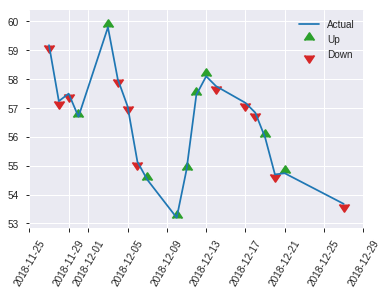


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22266322135441305
RMSE: 0.471872039174195
LogLoss: 0.6528154186937233
Mean Per-Class Error: 0.312039312039312
AUC: 0.7174447174447175
pr_auc: 0.600250135947067
Gini: 0.434889434889435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23822142227145782: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      96   52   0.3514   (52.0/148.0)
1      27   72   0.2727   (27.0/99.0)
Total  123  124  0.3198   (79.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238221     0.64574   123
max f2                       0.0560227    0.79288   221
max f0point5                 0.238221     0.605042  123
max accuracy                 0.487541     0.680162  69
max precision                0.949519     1         0
max recall                   0.0252829    1         241
max specificity              0.949519     1         0
max absolute_mcc             0.238221     0.368453  123
max min_per_class_accuracy   0.255641     0.655405  115
max mean_per_class_accuracy  0.238221     0.687961  123

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 33.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.924392           2.49495   2.49495            1                0.941021   1                           0.941021            0.030303        0.030303                   149.495   149.495
    2        0.0202429                   0.911474           1.24747   1.99596            0.5              0.917416   0.8                         0.931579            0.010101        0.040404                   24.7475   99.596
    3        0.0323887                   0.903756           0.83165   1.55934            0.333333         0.907928   0.625                       0.92271             0.010101        0.0505051                  -16.835   55.9343
    4        0.0404858                   0.896875           1.24747   1.49697            0.5              0.899081   0.6                         0.917984            0.010101        0.0606061                  24.7475   49.697
    5        0.0526316                   0.880213           2.49495   1.72727            1                0.887018   0.692308                    0.910838            0.030303        0.0909091                  149.495   72.7273
    6        0.101215                    0.781766           1.87121   1.79636            0.75             0.832864   0.72                        0.87341             0.0909091       0.181818                   87.1212   79.6364
    7        0.149798                    0.709738           1.45539   1.68578            0.583333         0.75092    0.675676                    0.833684            0.0707071       0.252525                   45.5387   68.5777
    8        0.202429                    0.5926             1.53535   1.64667            0.615385         0.648516   0.66                        0.78554             0.0808081       0.333333                   53.5354   64.6667
    9        0.299595                    0.453025           1.35143   1.55091            0.541667         0.529868   0.621622                    0.70262             0.131313        0.464646                   35.1431   55.0915
    10       0.40081                     0.334471           1.19758   1.46169            0.48             0.381746   0.585859                    0.621591            0.121212        0.585859                   19.7576   46.1688
    11       0.502024                    0.238221           1.39717   1.44868            0.56             0.275133   0.580645                    0.55174             0.141414        0.727273                   39.7172   44.868
    12       0.59919                     0.191639           0.623737  1.31491            0.25             0.213043   0.527027                    0.496816            0.0606061       0.787879                   -37.6263  31.4906
    13       0.700405                    0.142089           0.698586  1.22584            0.28             0.163581   0.491329                    0.448661            0.0707071       0.858586                   -30.1414  22.5842
    14       0.797571                    0.0944781          0.623737  1.15249            0.25             0.119508   0.461929                    0.408561            0.0606061       0.919192                   -37.6263  15.2489
    15       0.898785                    0.0560133          0.698586  1.10137            0.28             0.0763985  0.441441                    0.371156            0.0707071       0.989899                   -30.1414  10.1374
    16       1                           0.00681961         0.099798  1                  0.04             0.0362948  0.40081                     0.

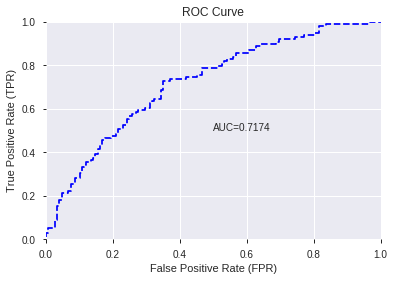

This function is available for GLM models only


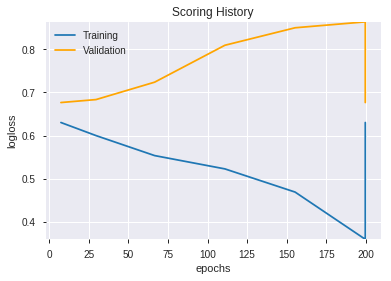

--2019-08-28 17:35:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_172759_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_172759_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLSPINNINGTOP',
 'STOCH_slowd',
 'CORREL_8',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'TRANGE',
 'BBANDS_middleband_30_0_4',
 'STOCH_slowk',
 'MACDEXT_hist',
 'STOCHRSI_fastd',
 'ATR_24',
 'ADX_24',
 'LINEARREG_SLOPE_8',
 'MOM_20',
 'PLUS_DI_30',
 'ATR_8',
 'AROONOSC_24',
 'CDLBELTHOLD',
 'LINEARREG_ANGLE_12',
 'BBANDS_lowerband_24_6_3',
 'BETA_12',
 'CDLLONGLINE',
 'VAR_8',
 'WILLR_8',
 'BBANDS_upperband_14_2_2',
 'BBANDS_upperband_24_6_5',
 'RSI_12',
 'PLUS_DM_12',
 'MFI_8',
 'WILLR_20',
 'BBANDS_upperband_14_7_3',
 'WILLR_12',
 'MACDFIX_hist_20',
 'MOM_30',
 'MACDEXT_signal',
 'HT_PHASOR_inphase',
 'WILLR_14',
 'ROC_24',
 'MACD_hist',
 'MINUS_DI_8',
 'ROCP_20',
 'BBANDS_upperband_14_4_2',
 'MOM_12',
 'WILLR_24',
 'ROCR_8',
 'PLUS_DM_14',
 'MINUS_DI_24',
 'CCI_20',
 'CMO_14',
 'BBANDS_upperband_14_4_5',
 'RSI_20',
 'WILLR_30',
 'MACDFIX_24']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_173548_model_1  0.722563  0.61033              0.320639  0.459419  0.211066

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.544501           1.000000    0.121971
1               STOCHF_fastk             0.288672           0.530158    0.064664
2             STOCHRSI_fastd             0.213758           0.392576    0.047883
3                     TRANGE             0.211814           0.389005    0.047447
4                     CCI_20             0.186816           0.343095    0.041847
5                    WILLR_8             0.183457           0.336927    0.041095
6                 MINUS_DI_8             0.180574           0.331632    0.040449
7                HT_DCPERIOD             0.146196           0.268494    0.032748
8                   WILLR_12             0.137228           0.252025    0.030740
9                CDLLONGLINE             0.123119           0.226113    0.027579
10               STOCH_slowk             0.121860           0.223801    0.027297
11                   BETA_12             0.112390           0.206410    0.025176
12   BBANDS_upperband_24_6_5             0.108545           0.199348    0.024315
13                    ROCR_8             0.107770           0.197923    0.024141
14               MINUS_DI_24             0.098540           0.180973    0.022073
15                    RSI_12             0.096020           0.176344    0.021509
16                   ROCP_20             0.095148           0.174743    0.021314
17         LINEARREG_SLOPE_8             0.086127           0.158176    0.019293
18        LINEARREG_ANGLE_12             0.086004           0.157949    0.019265
19               STOCH_slowd             0.081770           0.150174    0.018317
20                    CMO_14             0.080892           0.148562    0.018120
21                PLUS_DM_12             0.072155           0.132516    0.016163
22   BBANDS_lowerband_24_6_3             0.068923           0.126581    0.015439
23                  WILLR_30             0.067623           0.124193    0.015148
24                  WILLR_20             0.063526           0.116667    0.014230
25                  CORREL_8             0.063215           0.116097    0.014160
26            STOCHRSI_fastk             0.062743           0.115230    0.014055
27                 MACD_hist             0.059933           0.110070    0.013425
28                PLUS_DM_14             0.059206           0.108735    0.013262
29                     MFI_8             0.050745           0.093195    0.011367
30                  WILLR_14             0.050398           0.092558    0.011289
31                    MOM_12             0.048471           0.089020    0.010858
32                    ADX_24             0.047156           0.086604    0.010563
33               CDLBELTHOLD             0.044164           0.081109    0.009893
34           MACDFIX_hist_20             0.041624           0.076444    0.009324
35              MACDEXT_hist             0.039211           0.072013    0.008783
36                MACDFIX_24             0.038295           0.070330    0.008578
37            CDLSPINNINGTOP             0.034806           0.063922    0.007797
38                    MOM_20             0.033848           0.062163    0.007582
39                    RSI_20             0.032529           0.059740    0.007287
40               AROONOSC_24             0.029392           0.053980    0.006584
41                    MOM_30             0.028407           0.052171    0.006363
42   BBANDS_upperband_14_7_3             0.023041           0.042316    0.005161
43  BBANDS_middleband_30_0_4             0.019221           0.035299    0.004305
44   BBANDS_upperband_14_4_2             0.019017           0.034925    0.004260
45         HT_PHASOR_inphase             0.016008           0.029400    0.003586
46                    ROC_24             0.012078           0.022182    0.002706
47   BBANDS_upperband_14_2_2             0.011998           0.022035    0.002688
48                PLUS_DI_30             0.011462  

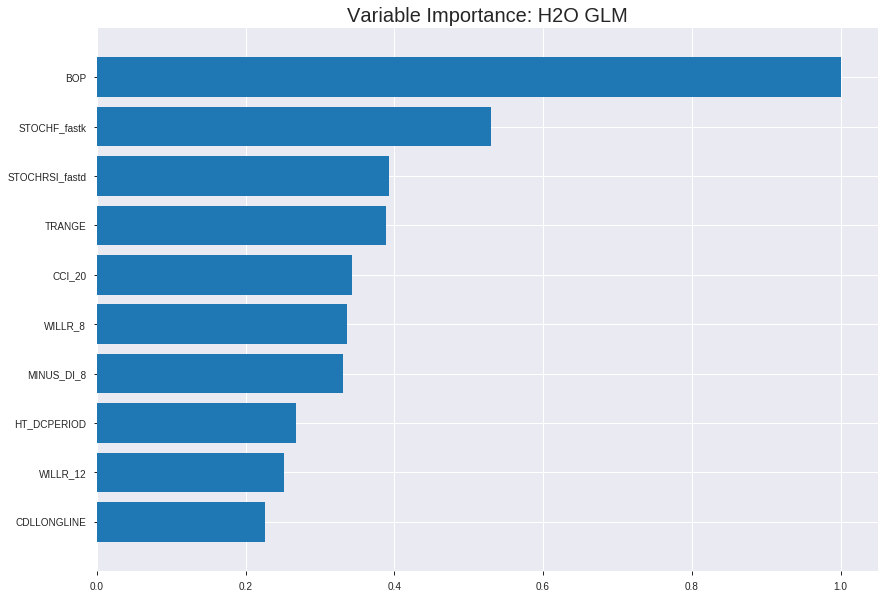

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_173548_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19524569989094226
RMSE: 0.44186615608229407
LogLoss: 0.5736512394082057
Null degrees of freedom: 1727
Residual degrees of freedom: 1672
Null deviance: 2395.329152624184
Residual deviance: 1982.5386833947591
AIC: 2094.538683394759
AUC: 0.7706255903217379
pr_auc: 0.7640210052198191
Gini: 0.5412511806434759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38737541537459547: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      442  413   0.483    (413.0/855.0)
1      124  749   0.142    (124.0/873.0)
Total  566  1162  0.3108   (537.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387375     0.736118  251
max f2                       0.220137     0.846108  337
max f0point5                 0.555646     0.710704  171
max accuracy                 0.449673     0.704861  223
max precision                0.941938     1         0
max recall                   0.0786926    1         393
max specificity              0.941938     1         0
max absolute_mcc             0.444376     0.416085  225
max min_per_class_accuracy   0.518936     0.701031  190
max mean_per_class_accuracy  0.449673     0.703901  223

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.891783           1.86942   1.86942            0.944444         0.90968   0.944444                    0.90968             0.0194731       0.0194731                  86.9416   86.9416
    2        0.0202546                   0.876503           1.86295   1.86627            0.941176         0.883117  0.942857                    0.896778            0.0183276       0.0378007                  86.2947   86.6274
    3        0.0300926                   0.86133            1.86295   1.86519            0.941176         0.868815  0.942308                    0.887636            0.0183276       0.0561283                  86.2947   86.5186
    4        0.0405093                   0.848956           1.64948   1.80972            0.833333         0.854546  0.914286                    0.879127            0.0171821       0.0733104                  64.9485   80.972
    5        0.0503472                   0.835889           1.86295   1.82012            0.941176         0.842783  0.91954                     0.872026            0.0183276       0.091638                   86.2947   82.0121
    6        0.100116                    0.785944           1.70319   1.76199            0.860465         0.807567  0.890173                    0.839983            0.0847652       0.176403                   70.3189   76.1993
    7        0.150463                    0.748128           1.4561    1.65964            0.735632         0.767352  0.838462                    0.815679            0.0733104       0.249714                   45.6097   65.9635
    8        0.200231                    0.71295            1.54208   1.63042            0.77907          0.730543  0.823699                    0.794518            0.0767468       0.32646                    54.2076   63.0415
    9        0.300347                    0.645891           1.38442   1.54842            0.699422         0.680016  0.782274                    0.756351            0.138603        0.465063                   38.4423   54.8418
    10       0.399884                    0.581914           1.21985   1.46663            0.616279         0.614195  0.740955                    0.720966            0.12142         0.586483                   21.9851   46.6633
    11       0.5                         0.519109           1.13271   1.39977            0.572254         0.553157  0.707176                    0.687365            0.113402        0.699885                   13.271    39.9771
    12       0.600116                    0.443438           1.01829   1.33613            0.514451         0.481692  0.675024                    0.653054            0.101947        0.801833                   1.82945   33.613
    13       0.699653                    0.362981           0.713498  1.24755            0.360465         0.404991  0.630273                    0.617763            0.0710195       0.872852                   -28.6502  24.7551
    14       0.799769                    0.295691           0.537751  1.1587             0.271676         0.326191  0.585384                    0.581263            0.0538373       0.92669                    -46.2249  15.8697
    15       0.899884                    0.206374           0.514868  1.08707            0.260116         0.254556  0.549196                    0.544916            0.0515464       0.978236                   -48.5132  8.70687
    16       1                           0.0156714          0.217389  1                  0.109827         0.148298  0.505208                    0.505208           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20944169000063032
RMSE: 0.45764799792048727
LogLoss: 0.6063110187717502
Null degrees of freedom: 493
Residual degrees of freedom: 438
Null deviance: 684.3830016464425
Residual deviance: 599.035286546489
AIC: 711.035286546489
AUC: 0.7310605438265012
pr_auc: 0.7265804851901589
Gini: 0.4621210876530024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3897489401688373: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  135  0.5745   (135.0/235.0)
1      30   229  0.1158   (30.0/259.0)
Total  130  364  0.334    (165.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389749     0.735152  288
max f2                       0.289998     0.860656  340
max f0point5                 0.578285     0.681629  190
max accuracy                 0.41686      0.672065  276
max precision                0.957502     1         0
max recall                   0.112526     1         395
max specificity              0.957502     1         0
max absolute_mcc             0.41686      0.356244  276
max min_per_class_accuracy   0.554429     0.655319  202
max mean_per_class_accuracy  0.578285     0.663411  190

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 54.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101215                   0.900983           1.90734   1.90734            1                0.924897  1                           0.924897            0.019305        0.019305                   90.7336    90.7336
    2        0.0202429                   0.878652           1.52587   1.7166             0.8              0.888976  0.9                         0.906937            0.015444        0.034749                   52.5869    71.6602
    3        0.0303644                   0.873497           1.52587   1.65302            0.8              0.876004  0.866667                    0.896626            0.015444        0.0501931                  52.5869    65.3024
    4        0.0404858                   0.868504           1.52587   1.62124            0.8              0.87119   0.85                        0.890267            0.015444        0.0656371                  52.5869    62.1236
    5        0.0506073                   0.861688           1.1444    1.52587            0.6              0.865753  0.8                         0.885364            0.011583        0.0772201                  14.4402    52.5869
    6        0.101215                    0.831265           1.52587   1.52587            0.8              0.846703  0.8                         0.866033            0.0772201       0.15444                    52.5869    52.5869
    7        0.149798                    0.797012           1.50997   1.52071            0.791667         0.812024  0.797297                    0.848517            0.0733591       0.227799                   50.9974    52.0714
    8        0.200405                    0.758718           1.67846   1.56055            0.88             0.778785  0.818182                    0.830908            0.0849421       0.312741                   67.8456    56.0548
    9        0.299595                    0.690069           1.16776   1.4305             0.612245         0.724595  0.75                        0.79571             0.11583         0.428571                   16.7757    43.0502
    10       0.40081                     0.627507           1.10625   1.34862            0.58             0.657622  0.707071                    0.760839            0.111969        0.540541                   10.6255    34.8621
    11       0.5                         0.557821           1.08991   1.2973             0.571429         0.595302  0.680162                    0.728               0.108108        0.648649                   8.99062    29.7297
    12       0.59919                     0.496219           1.01206   1.25008            0.530612         0.523744  0.655405                    0.694187            0.100386        0.749035                   1.20558    25.0078
    13       0.700405                    0.419193           0.991815  1.21276            0.52             0.460295  0.635838                    0.660388            0.100386        0.849421                   -0.818533  21.2757
    14       0.799595                    0.339463           0.739579  1.15406            0.387755         0.379391  0.605063                    0.62553             0.0733591       0.92278                    -26.0421   15.4059
    15       0.898785                    0.264615           0.544953  1.08684            0.285714         0.305307  0.56982                     0.59019             0.0540541       0.976834                   -45.5047   8.68378
    16       1                           0.0769707          0.22888   1                  0.12             0.183792  0.524291                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:35:49  0.000 sec   2            21        56            1.37023           1.37186
    2019-08-28 17:35:49  0.014 sec   4            13        56            1.36246           1.36523
    2019-08-28 17:35:49  0.028 sec   6            8.1       56            1.35179           1.35611
    2019-08-28 17:35:49  0.042 sec   8            5         56            1.33772           1.34411
    2019-08-28 17:35:49  0.056 sec   10           3.1       56            1.31988           1.32905
    2019-08-28 17:35:49  0.070 sec   12           1.9       56            1.29841           1.31128
    2019-08-28 17:35:49  0.084 sec   14           1.2       56            1.27434           1.29198
    2019-08-28 17:35:49  0.099 sec   16           0.75      56            1.24947           1.27296
    2019-08-28 17:35:49  0.112 sec   18           0.47      56            1.22572           1.25592
    2019-08-28 17:35:49  0.126 sec   20           0.29      56            1.20463           1.2419
    2019-08-28 17:35:49  0.139 sec   22           0.18      56            1.18695           1.23109
    2019-08-28 17:35:49  0.153 sec   24           0.11      56            1.17273           1.22307
    2019-08-28 17:35:49  0.170 sec   26           0.069     56            1.16168           1.21747
    2019-08-28 17:35:49  0.184 sec   28           0.043     56            1.15336           1.21405
    2019-08-28 17:35:49  0.197 sec   30           0.027     56            1.1473            1.21262
    2019-08-28 17:35:49  0.211 sec   32           0.017     56            1.14297           1.21277
    2019-08-28 17:35:49  0.225 sec   34           0.01      56            1.1398            1.21396
    2019-08-28 17:35:49  0.240 sec   36           0.0064    56            1.13733           1.21553
    2019-08-28 17:35:49  0.257 sec   38           0.004     56            1.13525           1.21713
    2019-08-28 17:35:49  0.271 sec   40           0.0025    56            1.13333           1.2191

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6963562753036437)

('F1', 0.6532258064516129)

('auc', 0.7225634725634725)

('logloss', 0.6103298747852184)

('mean_per_class_error', 0.3171921921921922)

('rmse', 0.45941949510568325)

('mse', 0.21106627248316093)

glm prediction progress: |████████████████████████████████████████████████| 100%


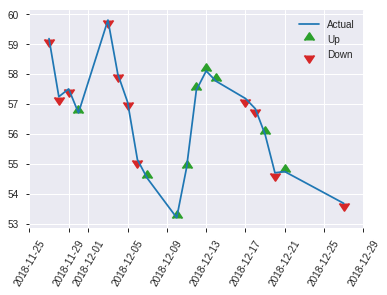


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21106627248316093
RMSE: 0.45941949510568325
LogLoss: 0.6103298747852184
Null degrees of freedom: 246
Residual degrees of freedom: 191
Null deviance: 343.4623801242943
Residual deviance: 301.5029581438979
AIC: 413.5029581438979
AUC: 0.7225634725634725
pr_auc: 0.6179692865210353
Gini: 0.44512694512694506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4018438462702372: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   68   0.4595   (68.0/148.0)
1      18   81   0.1818   (18.0/99.0)
Total  98   149  0.3482   (86.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401844     0.653226  148
max f2                       0.163772     0.783228  235
max f0point5                 0.576696     0.62069   83
max accuracy                 0.576696     0.696356  83
max precision                0.922484     1         0
max recall                   0.163772     1         235
max specificity              0.922484     1         0
max absolute_mcc             0.435939     0.360845  137
max min_per_class_accuracy   0.493093     0.656566  109
max mean_per_class_accuracy  0.435939     0.682808  137

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.840774           2.49495   2.49495            1                0.884924  1                           0.884924            0.030303        0.030303                   149.495   149.495
    2        0.0202429                   0.821291           1.24747   1.99596            0.5              0.828928  0.8                         0.862526            0.010101        0.040404                   24.7475   99.596
    3        0.0323887                   0.815955           2.49495   2.18308            1                0.818872  0.875                       0.846156            0.030303        0.0707071                  149.495   118.308
    4        0.0404858                   0.81334            2.49495   2.24545            1                0.814495  0.9                         0.839824            0.020202        0.0909091                  149.495   124.545
    5        0.0526316                   0.809153           0.83165   1.91919            0.333333         0.811961  0.769231                    0.833394            0.010101        0.10101                    -16.835   91.9192
    6        0.101215                    0.760666           1.6633    1.79636            0.666667         0.788488  0.72                        0.811839            0.0808081       0.181818                   66.33     79.6364
    7        0.149798                    0.720481           1.03956   1.55091            0.416667         0.735182  0.621622                    0.786977            0.0505051       0.232323                   3.95623   55.0915
    8        0.202429                    0.669522           1.91919   1.64667            0.769231         0.691652  0.66                        0.762193            0.10101         0.333333                   91.9192   64.6667
    9        0.299595                    0.596076           1.55934   1.61835            0.625            0.627205  0.648649                    0.718413            0.151515        0.484848                   55.9343   61.8346
    10       0.40081                     0.531519           1.19758   1.51209            0.48             0.566035  0.606061                    0.679934            0.121212        0.606061                   19.7576   51.2091
    11       0.502024                    0.462067           0.898182  1.38832            0.36             0.492955  0.556452                    0.642236            0.0909091       0.69697                    -10.1818  38.8319
    12       0.59919                     0.403781           1.14352   1.34862            0.458333         0.435819  0.540541                    0.608763            0.111111        0.808081                   14.3519   34.8621
    13       0.700405                    0.334736           0.299394  1.197              0.12             0.361814  0.479769                    0.573077            0.030303        0.838384                   -70.0606  19.6999
    14       0.797571                    0.289866           0.727694  1.13982            0.291667         0.311089  0.456853                    0.54116             0.0707071       0.909091                   -27.2306  13.9825
    15       0.898785                    0.222048           0.49899   1.06766            0.2              0.257687  0.427928                    0.509237            0.0505051       0.959596                   -50.101   6.76586
    16       1                           0.0567481          0.399192  1                  0.16             0.166475  0.40081                     0.474545          

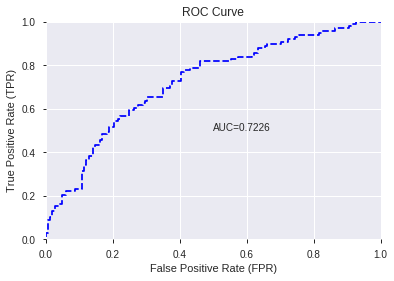

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


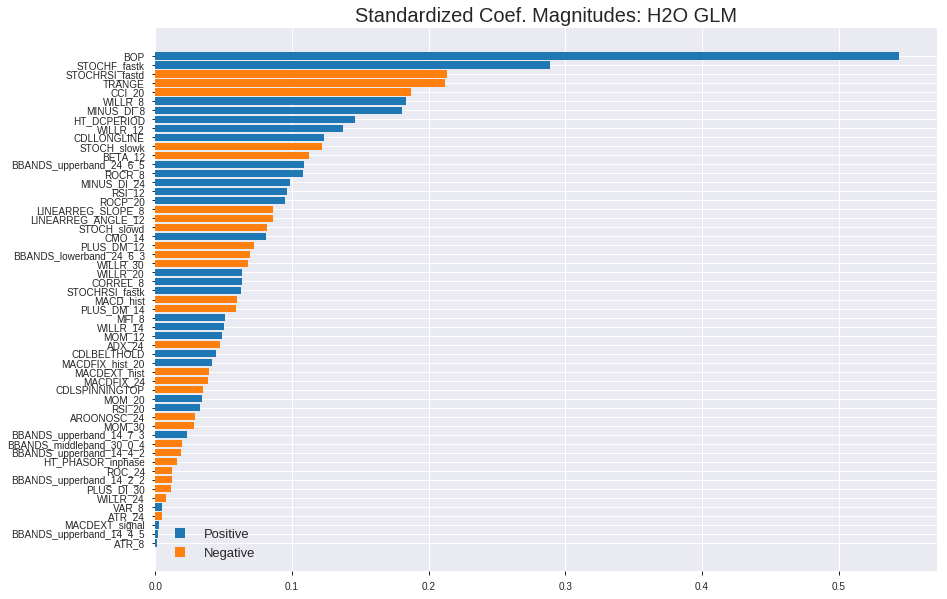

'log_likelihood'
--2019-08-28 17:35:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_173548_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_173548_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'TRANGE',
 'CCI_20',
 'WILLR_8',
 'MINUS_DI_8',
 'HT_DCPERIOD',
 'WILLR_12',
 'CDLLONGLINE',
 'STOCH_slowk',
 'BETA_12',
 'BBANDS_upperband_24_6_5',
 'ROCR_8',
 'MINUS_DI_24',
 'RSI_12',
 'ROCP_20',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_12',
 'STOCH_slowd',
 'CMO_14',
 'PLUS_DM_12',
 'BBANDS_lowerband_24_6_3',
 'WILLR_30',
 'WILLR_20',
 'CORREL_8',
 'STOCHRSI_fastk',
 'MACD_hist',
 'PLUS_DM_14',
 'MFI_8',
 'WILLR_14',
 'MOM_12',
 'ADX_24',
 'CDLBELTHOLD',
 'MACDFIX_hist_20',
 'MACDEXT_hist',
 'MACDFIX_24',
 'CDLSPINNINGTOP',
 'MOM_20',
 'RSI_20',
 'AROONOSC_24',
 'MOM_30',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_30_0_4',
 'BBANDS_upperband_14_4_2',
 'HT_PHASOR_inphase',
 'ROC_24',
 'BBANDS_upperband_14_2_2',
 'PLUS_DI_30',
 'WILLR_24',
 'VAR_8',
 'ATR_24',
 'MACDEXT_signal',
 'BBANDS_upperband_14_4_5',
 'ATR_8']

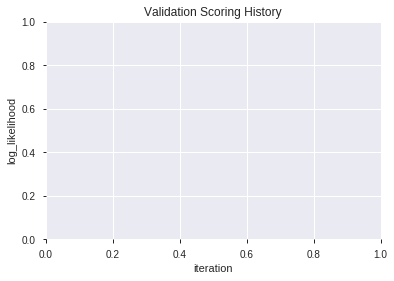

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_173600_model_4  0.726590  0.606991              0.339339  0.457889  0.209662
1  XGBoost_grid_1_AutoML_20190828_173600_model_6  0.724406  0.613637              0.325723  0.460289  0.211866
2  XGBoost_grid_1_AutoML_20190828_173600_model_2  0.722905  0.607999              0.327464  0.458296  0.210035
3               XGBoost_3_AutoML_20190828_173600  0.721130  0.615209              0.315554  0.461498  0.212981
4  XGBoost_grid_1_AutoML_20190828_173600_model_3  0.717513  0.616593              0.362954  0.462312  0.213733
5  XGBoost_grid_1_AutoML_20190828_173600_model_1  0.716626  0.617479              0.364660  0.462479  0.213887
6  XGBoost_grid_1_AutoML_20190828_173600_model_7  0.704682  0.623193              0.351010  0.464699  0.215945
7  XGBoost_grid_1_AutoML_20190828_173600_model_5  0.702566  0.642438              0.342581  0.472621  0.223371
8               XGBoost_1_AutoML_20190828_173600  0.694376  0.637755              0.349304  0.470943  0.221787
9               XGBoost_2_AutoML_20190828_173600  0.694308  0.636417              0.356026  0.471005  0.221846

variable  relative_importance  scaled_importance  percentage
0                        BOP          2258.172852           1.000000    0.453873
1                     TRANGE           482.638855           0.213730    0.097006
2               STOCHF_fastk           233.896606           0.103578    0.047011
3                     CCI_20           142.879715           0.063272    0.028718
4                HT_DCPERIOD           142.566544           0.063134    0.028655
5                   CORREL_8           119.060196           0.052724    0.023930
6          LINEARREG_SLOPE_8            95.506172           0.042294    0.019196
7                  MACD_hist            89.789948           0.039762    0.018047
8             STOCHRSI_fastd            85.638466           0.037924    0.017213
9                    BETA_12            76.342690           0.033807    0.015344
10                  WILLR_20            60.668987           0.026866    0.012194
11              MACDEXT_hist            60.158878           0.026641    0.012091
12   BBANDS_upperband_24_6_5            60.035839           0.026586    0.012067
13  BBANDS_middleband_30_0_4            57.980236           0.025676    0.011654
14        LINEARREG_ANGLE_12            57.909943           0.025645    0.011639
15                     MFI_8            56.029953           0.024812    0.011262
16                MINUS_DI_8            54.764244           0.024252    0.011007
17                PLUS_DM_14            50.140736           0.022204    0.010078
18               STOCH_slowd            49.046730           0.021720    0.009858
19                     VAR_8            42.404572           0.018778    0.008523
20                PLUS_DM_12            42.204056           0.018689    0.008483
21         HT_PHASOR_inphase            41.795647           0.018509    0.008401
22            STOCHRSI_fastk            39.754971           0.017605    0.007990
23               MINUS_DI_24            37.456932           0.016587    0.007529
24                    ADX_24            35.796604           0.015852    0.007195
25                    MOM_12            34.771236           0.015398    0.006989
26                  WILLR_24            33.479523           0.014826    0.006729
27                    ROCR_8            31.827318           0.014094    0.006397
28           MACDFIX_hist_20            30.047802           0.013306    0.006039
29                  WILLR_14            29.955399           0.013265    0.006021
30                   WILLR_8            27.181683           0.012037    0.005463
31                    ROC_24            26.711157           0.011829    0.005369
32                    MOM_20            26.679123           0.011814    0.005362
33            MACDEXT_signal            26.210144           0.011607    0.005268
34                PLUS_DI_30            21.359587           0.009459    0.004293
35                     ATR_8            21.123934           0.009354    0.004246
36                    ATR_24            18.995384           0.008412    0.003818
37   BBANDS_upperband_14_7_3            18.659771           0.008263    0.003750
38                  WILLR_12            18.581234           0.008228    0.003735
39                   ROCP_20            16.073233           0.007118    0.003231
40               AROONOSC_24            15.479631           0.006855    0.003111
41   BBANDS_upperband_14_4_5            14.178388           0.006279    0.002850
42               STOCH_slowk            11.985798           0.005308    0.002409
43                    MOM_30            10.414606           0.004612    0.002093
44                    RSI_20             9.978472           0.004419    0.002006
45                    CMO_14             9.815458           0.004347    0.001973
46                    RSI_12             9.613934           0.004257    0.001932
47   BBANDS_upperband_14_2_2             8.771623           0.003884    0.001763
48                MACDFIX_24             8.730289  

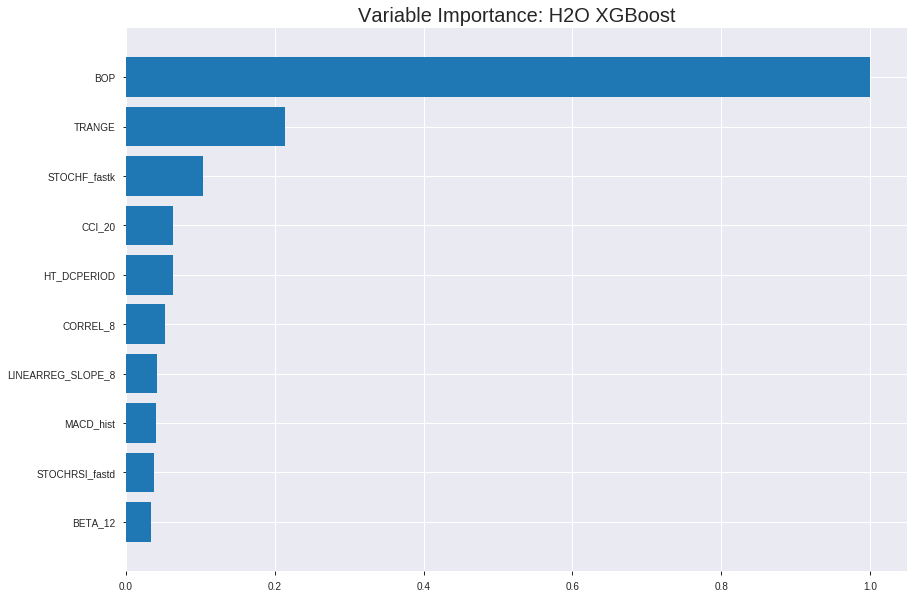

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_173600_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1760479594338506
RMSE: 0.41958069478212484
LogLoss: 0.5314497837429591
Mean Per-Class Error: 0.2509435099776933
AUC: 0.8251622756777397
pr_auc: 0.8216628259660265
Gini: 0.6503245513554794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44074028730392456: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      557  298   0.3485   (298.0/855.0)
1      138  735   0.1581   (138.0/873.0)
Total  695  1033  0.2523   (436.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44074      0.771249  235
max f2                       0.224673     0.860484  347
max f0point5                 0.563713     0.759283  170
max accuracy                 0.52557      0.748843  190
max precision                0.875795     1         0
max recall                   0.194165     1         365
max specificity              0.875795     1         0
max absolute_mcc             0.449665     0.503459  231
max min_per_class_accuracy   0.512949     0.74386   198
max mean_per_class_accuracy  0.52557      0.749056  190

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104167                   0.854943           1.97938    1.97938            1                0.860723  1                           0.860723            0.0206186       0.0206186                  97.9381    97.9381
    2        0.0202546                   0.847214           1.97938    1.97938            1                0.850754  1                           0.855881            0.0194731       0.0400916                  97.9381    97.9381
    3        0.0300926                   0.836221           1.74651    1.90325            0.882353         0.839946  0.961538                    0.850672            0.0171821       0.0572738                  74.6513    90.3251
    4        0.0405093                   0.82733            1.86942    1.89455            0.944444         0.830476  0.957143                    0.845479            0.0194731       0.0767468                  86.9416    89.4551
    5        0.0503472                   0.8157             1.86295    1.88838            0.941176         0.821201  0.954023                    0.840735            0.0183276       0.0950745                  86.2947    88.8375
    6        0.100116                    0.779447           1.84129    1.86497            0.930233         0.798417  0.942197                    0.819698            0.091638        0.186712                   84.1285    86.4966
    7        0.150463                    0.740653           1.70636    1.8119             0.862069         0.76126   0.915385                    0.800144            0.0859107       0.272623                   70.6363    81.1895
    8        0.200231                    0.713097           1.51906    1.73911            0.767442         0.726813  0.878613                    0.781917            0.0756014       0.348225                   51.906     73.911
    9        0.300347                    0.657452           1.43019    1.63614            0.722543         0.685013  0.82659                     0.749616            0.143184        0.491409                   43.0189    63.6136
    10       0.399884                    0.58572            1.38096    1.57262            0.697674         0.621208  0.794501                    0.717653            0.137457        0.628866                   38.0964    57.262
    11       0.5                         0.51449            1.14415    1.48683            0.578035         0.551693  0.751157                    0.684423            0.114548        0.743414                   14.4151    48.6827
    12       0.600116                    0.438955           0.995411   1.40485            0.50289          0.476179  0.70974                     0.649682            0.0996564       0.84307                    -0.458852  40.4845
    13       0.699653                    0.35621            0.655958   1.2983             0.331395         0.395309  0.655914                    0.613493            0.0652921       0.908362                   -34.4042   29.8304
    14       0.799769                    0.277679           0.45766    1.19307            0.231214         0.319086  0.60275                     0.576639            0.045819        0.954181                   -54.234    19.3071
    15       0.899884                    0.209089           0.37757    1.10234            0.190751         0.241517  0.556913                    0.539356            0.0378007       0.991982                   -62.243    10.2344
    16       1                           0.111132           0.0800906  1                  0.0404624        0.177564  0.505208    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20986770269260874
RMSE: 0.45811319855752763
LogLoss: 0.6071862147069468
Mean Per-Class Error: 0.3231495933623594
AUC: 0.7295654316930912
pr_auc: 0.7233177849047643
Gini: 0.45913086338618236
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3193758726119995: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   160  0.6809   (160.0/235.0)
1      18   241  0.0695   (18.0/259.0)
Total  93   401  0.3603   (178.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319376     0.730303  318
max f2                       0.189834     0.853739  382
max f0point5                 0.639665     0.704154  140
max accuracy                 0.639665     0.67004   140
max precision                0.850357     1         0
max recall                   0.176947     1         389
max specificity              0.850357     1         0
max absolute_mcc             0.639665     0.36619   140
max min_per_class_accuracy   0.538977     0.667954  196
max mean_per_class_accuracy  0.639665     0.67685   140

Gains/Lift Table: Avg response rate: 52.43 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.835485           1.90734   1.90734            1                0.841808  1                           0.841808            0.019305        0.019305                   90.7336   90.7336
    2        0.0202429                   0.831872           1.1444    1.52587            0.6              0.833751  0.8                         0.837779            0.011583        0.030888                   14.4402   52.5869
    3        0.0303644                   0.827773           1.1444    1.39871            0.6              0.830293  0.733333                    0.835284            0.011583        0.042471                   14.4402   39.8713
    4        0.0404858                   0.814979           1.1444    1.33514            0.6              0.821669  0.7                         0.83188             0.011583        0.0540541                  14.4402   33.5135
    5        0.0506073                   0.808857           1.52587   1.37328            0.8              0.811661  0.72                        0.827837            0.015444        0.0694981                  52.5869   37.3282
    6        0.101215                    0.785941           1.83104   1.60216            0.96             0.796406  0.84                        0.812121            0.0926641       0.162162                   83.1042   60.2162
    7        0.149798                    0.766002           1.58945   1.59804            0.833333         0.776121  0.837838                    0.800445            0.0772201       0.239382                   58.9447   59.8038
    8        0.200405                    0.734103           1.29699   1.52202            0.68             0.752411  0.79798                     0.788316            0.0656371       0.305019                   29.6988   52.2016
    9        0.299595                    0.685296           1.36238   1.46916            0.714286         0.710902  0.77027                     0.762685            0.135135        0.440154                   36.2383   46.9164
    10       0.40081                     0.621425           1.18255   1.39679            0.62             0.652013  0.732323                    0.734738            0.119691        0.559846                   18.2548   39.6786
    11       0.5                         0.549243           1.01206   1.32046            0.530612         0.585171  0.692308                    0.705067            0.100386        0.660232                   1.20558   32.0463
    12       0.59919                     0.465492           0.81743   1.23719            0.428571         0.507866  0.648649                    0.672422            0.0810811       0.741313                   -18.257   23.7191
    13       0.700405                    0.410123           0.801081  1.17417            0.42             0.438456  0.615607                    0.638612            0.0810811       0.822394                   -19.8919  17.4169
    14       0.799595                    0.331189           0.934205  1.1444             0.489796         0.374652  0.6                         0.605868            0.0926641       0.915058                   -6.57947  14.4402
    15       0.898785                    0.235968           0.544953  1.07825            0.285714         0.28579   0.565315                    0.570544            0.0540541       0.969112                   -45.5047  7.82462
    16       1                           0.105797           0.305174  1                  0.16             0.192427  0.524291                    0.532273         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:36:08  3.189 sec   0                  0.5              0.693147            0.5             0                  1                0.494792                         0.5                0.693147              0.5               0                    1                  0.475709
    2019-08-28 17:36:08  3.303 sec   5                  0.477893         0.649659            0.78688         0.757305           1.90021          0.306713                         0.483342           0.660208              0.723454          0.698655             1.52587            0.348178
    2019-08-28 17:36:08  3.364 sec   10                 0.462744         0.620167            0.792306        0.77125            1.88283          0.297454                         0.473686           0.64103               0.721211          0.718238             1.58945            0.354251
    2019-08-28 17:36:08  3.422 sec   15                 0.452034         0.598961            0.796285        0.775926           1.92283          0.288194                         0.466009           0.625415              0.729319          0.726964             1.63486            0.348178
    2019-08-28 17:36:08  3.486 sec   20                 0.444134         0.582943            0.799834        0.793347           1.97938          0.286458                         0.462746           0.61841               0.729549          0.72665              1.90734            0.354251
    2019-08-28 17:36:08  3.553 sec   25                 0.438834         0.571922            0.803296        0.80017            1.97938          0.287616                         0.460723           0.613918              0.730822          0.723708             1.90734            0.356275
    2019-08-28 17:36:08  3.617 sec   30                 0.43422          0.562259            0.806983        0.802264           1.86942          0.288194                         0.459633           0.611238              0.730075          0.726559             1.90734            0.342105
    2019-08-28 17:36:08  3.681 sec   35                 0.430596         0.554755            0.812038        0.808005           1.97938          0.282407                         0.459642           0.610799              0.727356          0.712172             1.52587            0.34413
    2019-08-28 17:36:08  3.759 sec   40                 0.427364         0.54787             0.815199        0.810156           1.97938          0.283565                         0.459433           0.610074              0.727257          0.721822             1.90734            0.354251
    2019-08-28 17:36:08  3.842 sec   45                 0.424916         0.542459            0.817494        0.814738           1.97938          0.277199                         0.458947           0.608959              0.72775           0.715968             1.1444             0.338057
    2019-08-28 17:36:08  3.917 sec   50                 0.421772         0.536245            0.823092        0.819197           1.97938          0.259259                         0.458301           0.607505              0.729409          0.720691             1.52587            0.360324
    2019-08-28 17:36:08  3.988 sec   55                 0.419581         0.53145             0.825162        0.821663           1.97938          0.252315                         0.458113           0.607186              0.729565          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2258.1728515625        1.0                    0.4538734244613699
TRANGE                   482.63885498046875     0.2137298102076269     0.09700628086841427
STOCHF_fastk             233.8966064453125      0.10357781348911009    0.04701121690652347
CCI_20                   142.8797149658203      0.0632722667208391     0.028717600370020416
HT_DCPERIOD              142.56654357910156     0.06313358318892875    0.028654655600475868
---                      ---                    ---                    ---
BBANDS_upperband_14_2_2  8.771622657775879      0.0038843893866257937  0.0017630211128492493
MACDFIX_24               8.730289459228516      0.003866085562576734   0.0017547134935473642
WILLR_30                 7.921664237976074      0.003507997287494989   0.0015921867418765474
BBANDS_upperband_14_4_2  7.406249046325684      0.003279752938842157   0.0014885926977395317
BBANDS_lowerband_24_6_3  6.743131637573242      0.002986100746409851   0.0013553117715596917


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6923076923076923)

('F1', 0.6494464944649447)

('auc', 0.7265902265902267)

('logloss', 0.6069913231449071)

('mean_per_class_error', 0.32214032214032207)

('rmse', 0.45788897663360983)

('mse', 0.2096623149225745)

xgboost prediction progress: |████████████████████████████████████████████| 100%


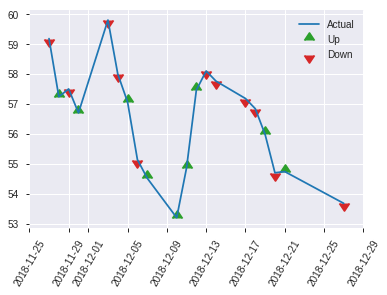


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2096623149225745
RMSE: 0.45788897663360983
LogLoss: 0.6069913231449071
Mean Per-Class Error: 0.32214032214032207
AUC: 0.7265902265902267
pr_auc: 0.6333658642520609
Gini: 0.4531804531804533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3207016587257385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   84   0.5676   (84.0/148.0)
1      11   88   0.1111   (11.0/99.0)
Total  75   172  0.3846   (95.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320702     0.649446  171
max f2                       0.268702     0.785473  195
max f0point5                 0.650577     0.61194   58
max accuracy                 0.653551     0.692308  56
max precision                0.871065     1         0
max recall                   0.148897     1         240
max specificity              0.871065     1         0
max absolute_mcc             0.460019     0.348675  121
max min_per_class_accuracy   0.498541     0.656566  113
max mean_per_class_accuracy  0.460019     0.67786   121

Gains/Lift Table: Avg response rate: 40.08 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.853294           2.49495   2.49495            1                0.860878  1                           0.860878            0.030303        0.030303                   149.495   149.495
    2        0.0202429                   0.833115           1.24747   1.99596            0.5              0.849189  0.8                         0.856202            0.010101        0.040404                   24.7475   99.596
    3        0.0323887                   0.826532           2.49495   2.18308            1                0.829165  0.875                       0.846063            0.030303        0.0707071                  149.495   118.308
    4        0.0404858                   0.816086           1.24747   1.99596            0.5              0.823792  0.8                         0.841609            0.010101        0.0808081                  24.7475   99.596
    5        0.0526316                   0.80556            1.6633    1.91919            0.666667         0.810474  0.769231                    0.834424            0.020202        0.10101                    66.33     91.9192
    6        0.101215                    0.74045            2.07912   1.99596            0.833333         0.783813  0.8                         0.810131            0.10101         0.20202                    107.912   99.596
    7        0.149798                    0.716404           1.45539   1.82064            0.583333         0.72832   0.72973                     0.783598            0.0707071       0.272727                   45.5387   82.0639
    8        0.202429                    0.670093           1.53535   1.74646            0.615385         0.687327  0.7                         0.758567            0.0808081       0.353535                   53.5354   74.6465
    9        0.299595                    0.607099           1.24747   1.58463            0.5              0.640508  0.635135                    0.720278            0.121212        0.474747                   24.7475   58.463
    10       0.40081                     0.534255           0.99798   1.43649            0.4              0.573819  0.575758                    0.683293            0.10101         0.575758                   -0.20202  43.6486
    11       0.502024                    0.457803           1.29737   1.40844            0.52             0.500103  0.564516                    0.64636             0.131313        0.707071                   29.7374   40.8439
    12       0.59919                     0.39383            0.83165   1.31491            0.333333         0.430198  0.527027                    0.611306            0.0808081       0.787879                   -16.835   31.4906
    13       0.700405                    0.317009           0.99798   1.26911            0.4              0.349485  0.508671                    0.573471            0.10101         0.888889                   -0.20202  26.9107
    14       0.797571                    0.26476            0.519781  1.17782            0.208333         0.290394  0.472081                    0.538985            0.0505051       0.939394                   -48.0219  17.7819
    15       0.898785                    0.23064            0.199596  1.06766            0.08             0.245588  0.427928                    0.505944            0.020202        0.959596                   -80.0404  6.76586
    16       1                           0.114346           0.399192  1                  0.16             0.182606  0.40081                     0.473218            0

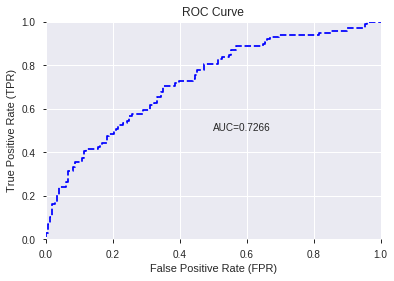

This function is available for GLM models only


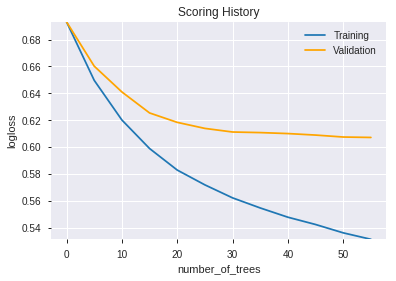

--2019-08-28 17:36:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_173600_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_173600_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9fbb',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_20',
 'HT_DCPERIOD',
 'CORREL_8',
 'LINEARREG_SLOPE_8',
 'MACD_hist',
 'STOCHRSI_fastd',
 'BETA_12',
 'WILLR_20',
 'MACDEXT_hist',
 'BBANDS_upperband_24_6_5',
 'BBANDS_middleband_30_0_4',
 'LINEARREG_ANGLE_12',
 'MFI_8',
 'MINUS_DI_8',
 'PLUS_DM_14',
 'STOCH_slowd',
 'VAR_8',
 'PLUS_DM_12',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastk',
 'MINUS_DI_24',
 'ADX_24',
 'MOM_12',
 'WILLR_24',
 'ROCR_8',
 'MACDFIX_hist_20',
 'WILLR_14',
 'WILLR_8',
 'ROC_24',
 'MOM_20',
 'MACDEXT_signal',
 'PLUS_DI_30',
 'ATR_8',
 'ATR_24',
 'BBANDS_upperband_14_7_3',
 'WILLR_12',
 'ROCP_20',
 'AROONOSC_24',
 'BBANDS_upperband_14_4_5',
 'STOCH_slowk',
 'MOM_30',
 'RSI_20',
 'CMO_14',
 'RSI_12',
 'BBANDS_upperband_14_2_2',
 'MACDFIX_24',
 'WILLR_30',
 'BBANDS_upperband_14_4_2',
 'BBANDS_lowerband_24_6_3']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.729
GLM             0.709
XGBoost         0.725
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.709    0.700
DLF          0.729  0.688    0.725
Fwe          0.725  0.709    0.704
RFE          0.680  0.696    0.692
XGBF         0.709  0.688    0.725





F1


DeepLearning    0.664
GLM             0.676
XGBoost         0.656
dtype: float64

DeepLearning    GLM  XGBoost
All          0.651  0.635    0.656
DLF          0.640  0.648    0.635
Fwe          0.664  0.676    0.650
RFE          0.646  0.653    0.649
XGBF         0.646  0.648    0.635





auc


DeepLearning    0.741
GLM             0.749
XGBoost         0.745
dtype: float64

DeepLearning    GLM  XGBoost
All          0.719  0.720    0.737
DLF          0.728  0.714    0.727
Fwe          0.741  0.749    0.745
RFE          0.717  0.723    0.727
XGBF         0.715  0.714    0.727





logloss


DeepLearning    0.653
GLM             0.623
XGBoost         0.620
dtype: float64

DeepLearning    GLM  XGBoost
All          0.639  0.620    0.608
DLF          0.613  0.623    0.620
Fwe          0.609  0.588    0.597
RFE          0.653  0.610    0.607
XGBF         0.625  0.623    0.620





mean_per_class_error


DeepLearning    0.315
GLM             0.319
XGBoost         0.322
dtype: float64

DeepLearning    GLM  XGBoost
All          0.315  0.312    0.304
DLF          0.297  0.319    0.297
Fwe          0.292  0.283    0.302
RFE          0.312  0.317    0.322
XGBF         0.315  0.319    0.297





rmse


DeepLearning    0.472
GLM             0.464
XGBoost         0.460
dtype: float64

DeepLearning    GLM  XGBoost
All          0.472  0.463    0.456
DLF          0.459  0.464    0.460
Fwe          0.458  0.448    0.452
RFE          0.472  0.459    0.458
XGBF         0.464  0.464    0.460





mse


DeepLearning    0.223
GLM             0.215
XGBoost         0.212
dtype: float64

DeepLearning    GLM  XGBoost
All          0.222  0.215    0.208
DLF          0.211  0.215    0.212
Fwe          0.209  0.201    0.205
RFE          0.223  0.211    0.210
XGBF         0.216  0.215    0.212

{'F1':       DeepLearning    GLM  XGBoost
 All          0.651    NaN      NaN
 DLF          0.640    NaN      NaN
 DLF            NaN  0.648      NaN
 DLF            NaN    NaN    0.635
 All            NaN  0.635      NaN
 All            NaN    NaN    0.656
 XGBF         0.646    NaN      NaN
 XGBF           NaN  0.648      NaN
 XGBF           NaN    NaN    0.635
 Fwe          0.664    NaN      NaN
 Fwe            NaN  0.676      NaN
 Fwe            NaN    NaN    0.650
 RFE          0.646    NaN      NaN
 RFE            NaN  0.653      NaN
 RFE            NaN    NaN    0.649,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.700    NaN      NaN
 DLF          0.729    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.725
 All            NaN  0.709      NaN
 All            NaN    NaN    0.700
 XGBF         0.709    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.725
 Fwe          0.725    NaN      NaN
 Fwe     